In [1]:
%cd ..
%ls

C:\Users\Dongmin Kim\Documents\OnlineTSAD
 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 067D-FB3E

 C:\Users\Dongmin Kim\Documents\OnlineTSAD 디렉터리

2023-05-09  오후 12:28    <DIR>          .
2023-05-09  오후 12:28    <DIR>          ..
2023-04-10  오후 01:01               156 .gitignore
2023-05-09  오후 06:11    <DIR>          .idea
2023-04-14  오후 04:53    <DIR>          .ipynb_checkpoints
2023-05-07  오후 04:03    <DIR>          cfgs
2023-05-04  오후 08:21    <DIR>          checkpoints
2023-05-06  오후 01:47    <DIR>          data
2023-05-06  오후 01:54    <DIR>          EDA
2023-05-08  오후 04:12    <DIR>          Exp
2023-05-09  오후 07:25    <DIR>          figures
2023-05-09  오후 05:25    <DIR>          hptune
2023-05-04  오후 08:21    <DIR>          logs
2023-05-07  오후 01:57    <DIR>          models
2023-04-26  오후 09:18    <DIR>          outputs
2023-05-04  오후 08:21    <DIR>          plots
2023-05-09  오전 11:29    <DIR>          results
2023-05-09  오후 06:11    <DIR>          scripts
2023-05-07  오후 04:00             

In [2]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

import warnings
from data.load_data import DataFactory
from Exp.MLP import MLP

from easydict import EasyDict as edict
import yaml
import re
import copy
import os
import pandas as pd
warnings.filterwarnings("ignore")

# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [3]:
cfg['dataset'] = 'SWaT'
cfg["RevIN"] = 'SlowRevIN'
cfg["gamma"] = 0.99
args = prepare_arguments(cfg)
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-05-09 19:25:23,878] Configurations: {'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': True, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}
[2023-05-09 19:25:23,879] Preparing SWaT dataset...
[2023-05-09 19:25:23,880] current location: C:\Users\Dongmin Kim\Documents\Onl

{'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': True, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}


[2023-05-09 19:25:33,619] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-05-09 19:25:33,697] Complete.
[2023-05-09 19:25:33,698] Preparing dataloader...
[2023-05-09 19:25:34,182] total train dataset- 647, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-05-09 19:25:34,183] total test dataset- 37494, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-05-09 19:25:34,184] Complete.


(496800, 51) (496800,) (449928, 51) (449928,)


## Visualize

In [5]:
data_df = pd.read_csv("data/SWaT/SWaT_Dataset_Attack_v0.csv", index_col=0)
data_df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1,Normal
2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal
2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal


In [6]:
cols = list(data_df.columns)

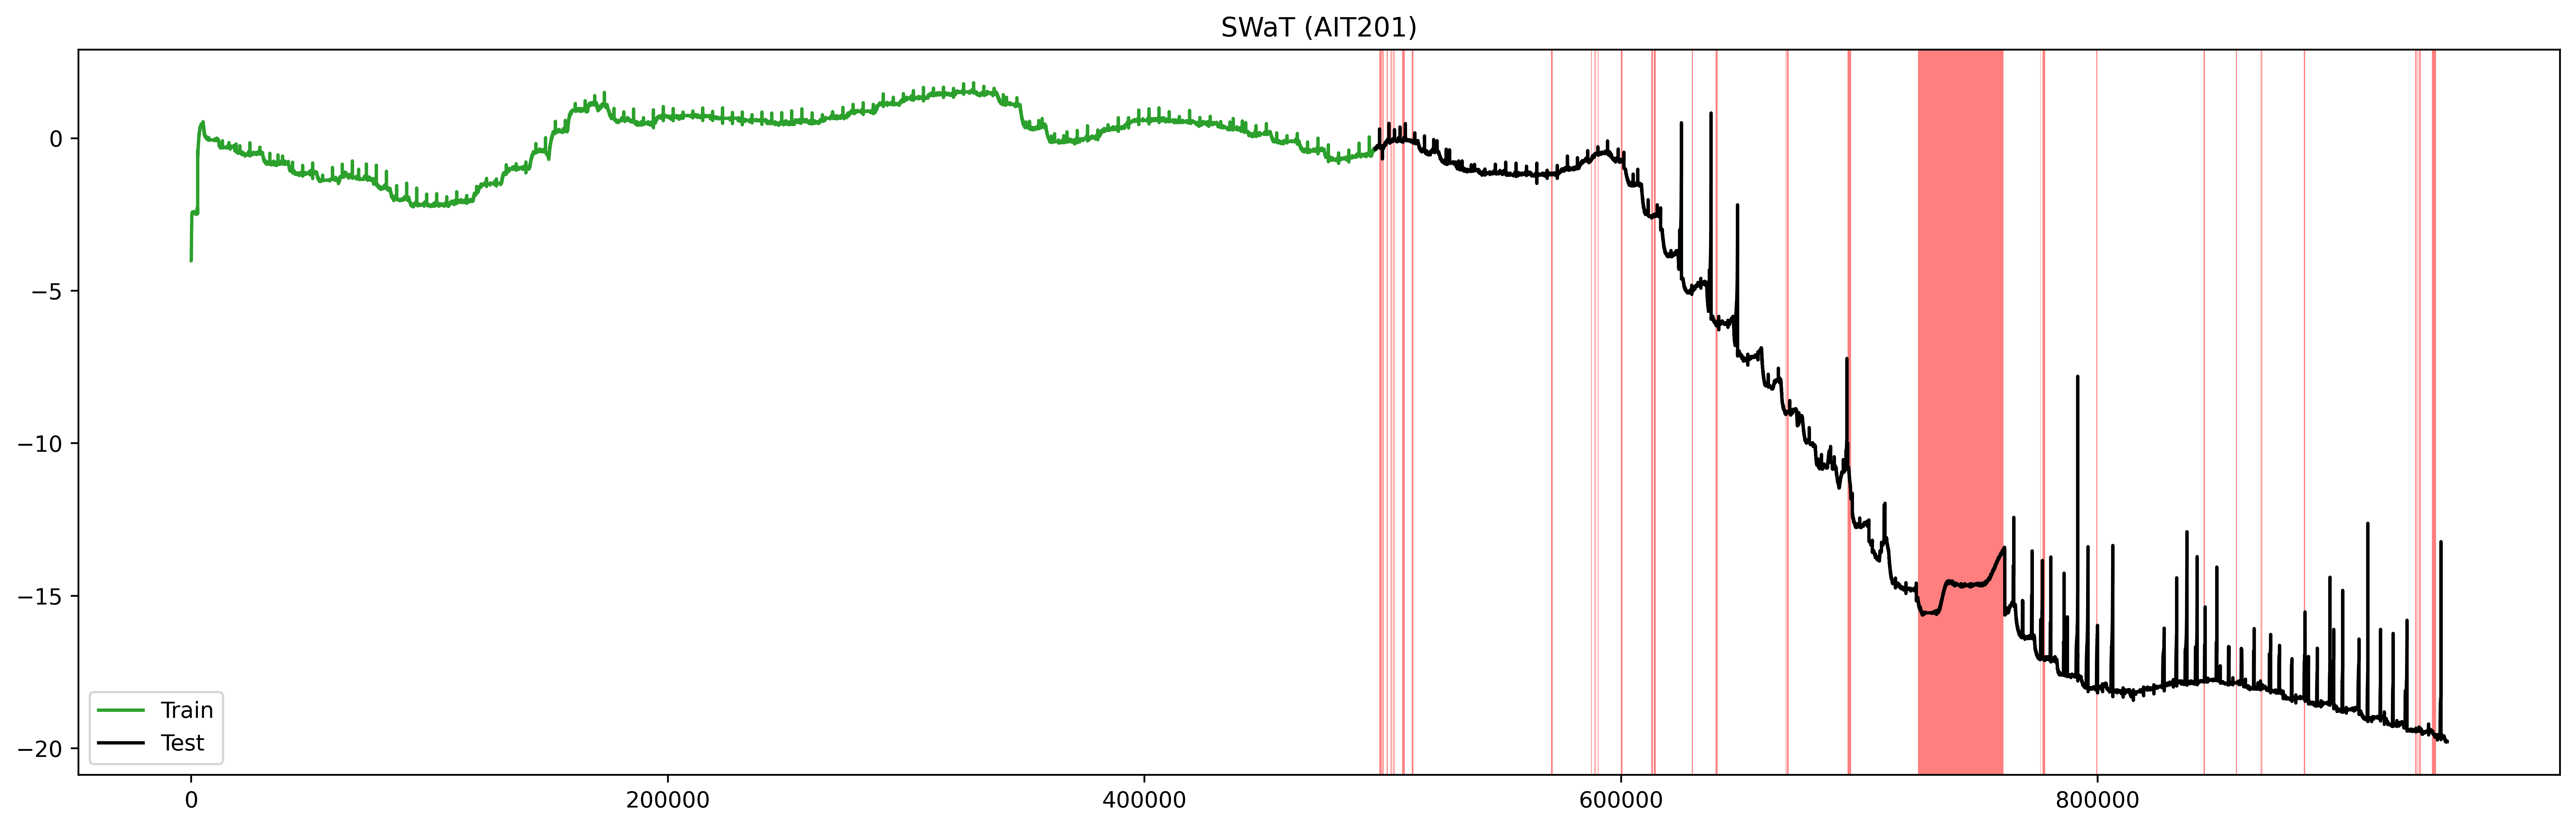

In [7]:
c = 5
dataset_name = "SWaT"

plt.figure(figsize=(20, 6), dpi=500)
plt.plot(train_X[:, c], color="C2", label="Train")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], color="black", label="Test")
label = np.concatenate([np.array([0]*len(train_X)), test_y])
plot_interval(plt, label)
#plt.title(f"{dataset_name} ({cols[c]})")
plt.title(f"SWaT (AIT201)")

plt.legend()
plt.ticklabel_format(style="plain")
plt.show()

## PCA plots

In [5]:
from scipy.stats import gaussian_kde, entropy
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [6]:
import scipy

In [14]:
import numpy as np

In [15]:
"https://gist.github.com/ChuaCheowHuan/18977a3e77c0655d945e8af60633e4df"
def kl_mvn(to, fr):
    """Calculate `KL(to||fr)`, where `to` and `fr` are pairs of means and covariance matrices"""
    m_to, S_to = to
    m_fr, S_fr = fr
    
    d = m_fr - m_to
    
    c, lower = scipy.linalg.cho_factor(S_fr)
    def solve(B):
        return scipy.linalg.cho_solve((c, lower), B)
    
    def logdet(S):
        return np.linalg.slogdet(S)[1]

    term1 = np.trace(solve(S_to))
    term2 = logdet(S_fr) - logdet(S_to)
    term3 = d.T @ solve(d)
    return (term1 + term2 + term3 - len(d))/2.

def plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, data, load=True):
    print("="*20)
    print(f"KLD for {data}")
    base_dir = os.path.join("figures", "PCA", "datasearch", data)
    os.makedirs(base_dir, exist_ok=True)
    
    #import pdb;pdb.set_trace();
    if (load==True) and (os.path.exists(os.path.join(base_dir, "Xpca_train.npy"))):
        Xpca_train = np.load(os.path.join(base_dir, "Xpca_train.npy"))
        Xpca_test = np.load(os.path.join(base_dir, "Xpca_test.npy"))
    else:
        print("finding PCA...")
        T, C = train_X.shape

        # filter anomalies
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
        mask = (1-test_y).astype(bool)
        test_X = test_X[mask]
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

        data = np.concatenate([train_X, test_X])
        print(data.shape)

        if C < 2:
            Xpca_train = train_X
            Xpca_test = test_X
        else:
            x = range(1, min(C, 31))
            d = -1
            evar = []
            for n in x:
                pca = PCA(n_components=n)
                Xpca = pca.fit_transform(data)
                evar.append(sum(pca.explained_variance_ratio_))
                if d == -1 and sum(pca.explained_variance_ratio_) > 0.99 :
                    d = n
            print("Done!")
            plt.plot(x, evar)
            plt.axvline(d)
            plt.show()

            # kde of PCA'ed outputs.
            pca = PCA(n_components=d) 
            pca_data = pca.fit_transform(data)
            Xpca_train = pca_data[:len(train_X)]
            Xpca_test = pca_data[len(train_X):]
        
        print("saving...")
        with open(os.path.join(base_dir, "Xpca_train.npy"), "wb") as f:
            np.save(f, Xpca_train)
        with open(os.path.join(base_dir, "Xpca_test.npy"), "wb") as f:
            np.save(f, Xpca_test)
            
    print("Estimating Gaussian KLD...")
    _, C = Xpca_train.shape
    train_mu = np.mean(Xpca_train, axis=0)
    test_mu = np.mean(Xpca_test, axis=0)
    train_var = np.array([[np.var(Xpca_train)]]) if C < 2 else np.cov(Xpca_train.T)
    test_var = np.array([[np.var(Xpca_test)]]) if C < 2 else np.cov(Xpca_test.T)
    train_stats = (train_mu, train_var)
    test_stats = (test_mu, test_var)
    e = kl_mvn(test_stats, train_stats)    
    print("KLD: ", e)
    print("train_stats: ", train_stats)
    print("test_stats: ", test_stats)
    print("done")
    print("="*20)
    return e, Xpca_train, Xpca_test

KLD for A-1
finding PCA...
(3682, 55) (3682,) (2856, 55) (2856,)
(3682, 55) (3682,) (2836, 55) (2856,)
(6518, 55)
Done!


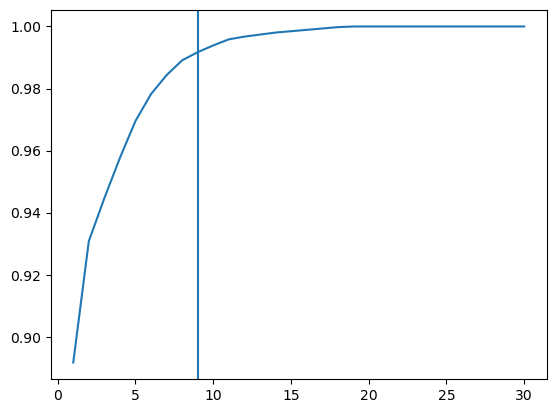

saving...
Estimating Gaussian KLD...
KLD:  743.2571599555365
train_stats:  (array([-4.3744171e-01,  7.4433058e-04,  2.5386742e-04, -4.2299923e-04,
        1.2056631e-03, -1.1084900e-03, -7.5301307e-04, -1.7610221e-04,
        8.4817444e-04], dtype=float32), array([[ 1.30069146e-03, -4.31164813e-04, -8.92554906e-05,
        -3.51030735e-04, -3.03782164e-04, -2.18346715e-05,
         1.09421962e-05, -1.17634516e-04,  1.05879352e-06],
       [-4.31164813e-04,  2.82372842e-02, -6.94148061e-06,
         1.52891467e-05, -2.93804427e-05,  3.60589325e-05,
         1.74678387e-05,  4.71711961e-06, -4.32519988e-05],
       [-8.92554906e-05, -6.94148061e-06,  9.95836448e-03,
         6.89305849e-05, -3.21285023e-05,  2.36632055e-05,
         8.27837627e-06,  2.17607855e-06, -1.45172890e-05],
       [-3.51030735e-04,  1.52891467e-05,  6.89305849e-05,
         8.90332267e-03, -1.23182040e-04,  2.33255808e-05,
         7.72717092e-06,  1.33893702e-06, -1.68333429e-05],
       [-3.03782164e-04, -2.93

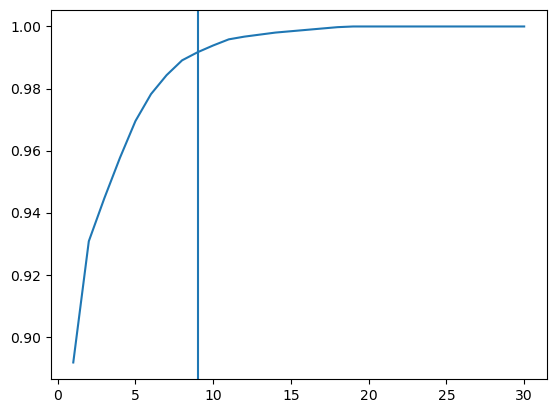

saving...
Estimating Gaussian KLD...
KLD:  743.2572270047849
train_stats:  (array([-4.3744171e-01,  7.4431865e-04,  2.5387012e-04, -4.2299397e-04,
        1.2056698e-03, -1.1084895e-03, -7.5300917e-04, -1.7610108e-04,
        8.4817683e-04], dtype=float32), array([[ 1.30069176e-03, -4.31173207e-04, -8.92532971e-05,
        -3.51032388e-04, -3.03781216e-04, -2.18347853e-05,
         1.09425863e-05, -1.17634576e-04,  1.05914731e-06],
       [-4.31173207e-04,  2.82373007e-02, -6.94169982e-06,
         1.52890239e-05, -2.93808331e-05,  3.60589394e-05,
         1.74677118e-05,  4.71708719e-06, -4.32520659e-05],
       [-8.92532971e-05, -6.94169982e-06,  9.95837299e-03,
         6.89319400e-05, -3.21298113e-05,  2.36608542e-05,
         8.27804093e-06,  2.17532072e-06, -1.45171162e-05],
       [-3.51032388e-04,  1.52890239e-05,  6.89319400e-05,
         8.90330588e-03, -1.23177167e-04,  2.33256249e-05,
         7.72700167e-06,  1.33875933e-06, -1.68340526e-05],
       [-3.03781216e-04, -2.93

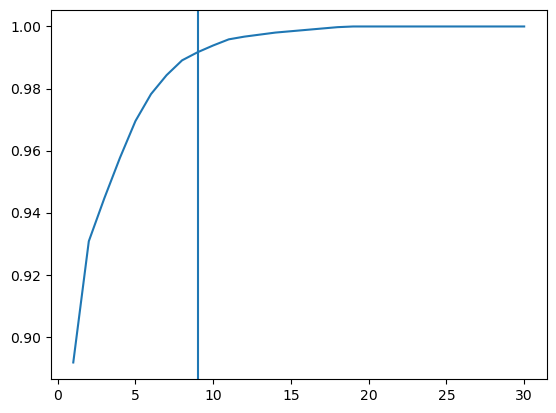

saving...
Estimating Gaussian KLD...
KLD:  743.2575440801096
train_stats:  (array([-4.3744171e-01,  7.4431393e-04,  2.5386660e-04, -4.2299746e-04,
        1.2056687e-03, -1.1084847e-03, -7.5301214e-04, -1.7610045e-04,
        8.4817794e-04], dtype=float32), array([[ 1.30069197e-03, -4.31178775e-04, -8.92583478e-05,
        -3.51029080e-04, -3.03782230e-04, -2.18354137e-05,
         1.09421348e-05, -1.17634989e-04,  1.05951312e-06],
       [-4.31178775e-04,  2.82373161e-02, -6.94179040e-06,
         1.52893422e-05, -2.93806325e-05,  3.60588842e-05,
         1.74678093e-05,  4.71708242e-06, -4.32522897e-05],
       [-8.92583478e-05, -6.94179040e-06,  9.95837159e-03,
         6.89234598e-05, -3.21299564e-05,  2.36610023e-05,
         8.27803171e-06,  2.17568226e-06, -1.45174279e-05],
       [-3.51029080e-04,  1.52893422e-05,  6.89234598e-05,
         8.90331608e-03, -1.23181449e-04,  2.33257331e-05,
         7.72700566e-06,  1.33897917e-06, -1.68334096e-05],
       [-3.03782230e-04, -2.93

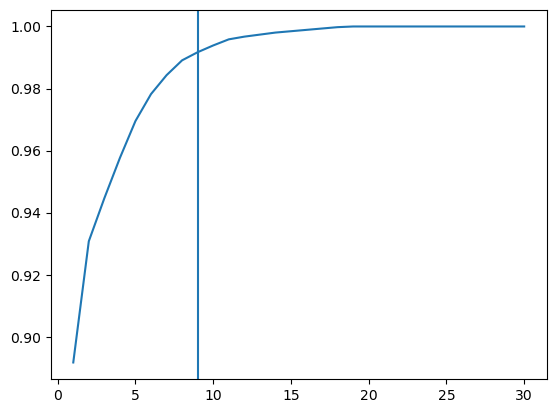

saving...
Estimating Gaussian KLD...
KLD:  743.2575346236941
train_stats:  (array([-4.3744165e-01,  7.4431807e-04,  2.5386523e-04, -4.2299964e-04,
        1.2056662e-03, -1.1084906e-03, -7.5301173e-04, -1.7610245e-04,
        8.4817858e-04], dtype=float32), array([[ 1.30069123e-03, -4.31177316e-04, -8.92570945e-05,
        -3.51030390e-04, -3.03783396e-04, -2.18366254e-05,
         1.09422355e-05, -1.17635069e-04,  1.05905071e-06],
       [-4.31177316e-04,  2.82373103e-02, -6.93777635e-06,
         1.52871402e-05, -2.93815829e-05,  3.60589037e-05,
         1.74677356e-05,  4.71716575e-06, -4.32522838e-05],
       [-8.92570945e-05, -6.93777635e-06,  9.95836617e-03,
         6.89296610e-05, -3.21313319e-05,  2.36615662e-05,
         8.27870772e-06,  2.17556208e-06, -1.45173967e-05],
       [-3.51030390e-04,  1.52871402e-05,  6.89296610e-05,
         8.90331769e-03, -1.23185860e-04,  2.33269252e-05,
         7.72741060e-06,  1.33920934e-06, -1.68348219e-05],
       [-3.03783396e-04, -2.93

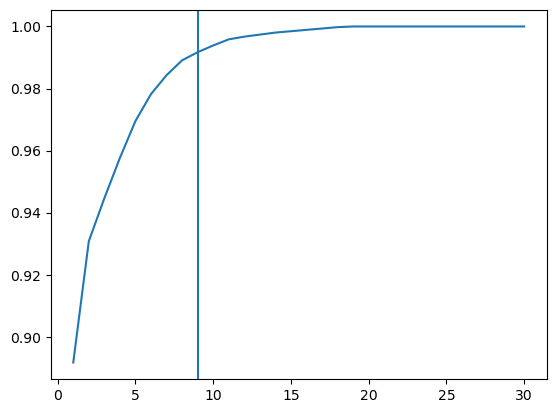

saving...
Estimating Gaussian KLD...
KLD:  743.2570471364511
train_stats:  (array([-4.3744171e-01,  7.4432517e-04,  2.5386389e-04, -4.2299597e-04,
        1.2056720e-03, -1.1084896e-03, -7.5301214e-04, -1.7610265e-04,
        8.4817578e-04], dtype=float32), array([[ 1.30069164e-03, -4.31172344e-04, -8.92591542e-05,
        -3.51031179e-04, -3.03781219e-04, -2.18353393e-05,
         1.09422105e-05, -1.17635213e-04,  1.05942452e-06],
       [-4.31172344e-04,  2.82373356e-02, -6.94135003e-06,
         1.52894648e-05, -2.93809255e-05,  3.60588809e-05,
         1.74677930e-05,  4.71714171e-06, -4.32521239e-05],
       [-8.92591542e-05, -6.94135003e-06,  9.95836997e-03,
         6.89246255e-05, -3.21342419e-05,  2.36602301e-05,
         8.27836113e-06,  2.17607731e-06, -1.45187096e-05],
       [-3.51031179e-04,  1.52894648e-05,  6.89246255e-05,
         8.90332930e-03, -1.23177206e-04,  2.33265474e-05,
         7.72846223e-06,  1.33988848e-06, -1.68343986e-05],
       [-3.03781219e-04, -2.93

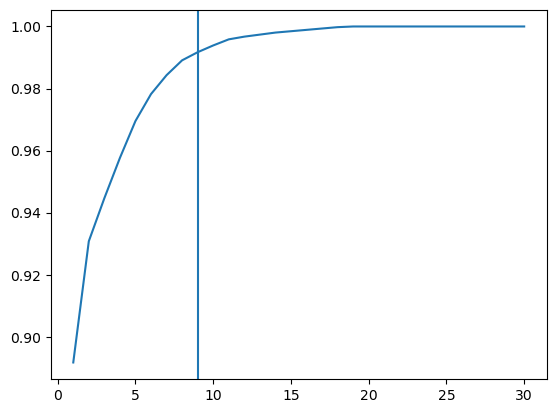

saving...
Estimating Gaussian KLD...
KLD:  743.2569860844827
train_stats:  (array([-4.3744171e-01,  7.4431748e-04,  2.5386747e-04, -4.2300188e-04,
        1.2056701e-03, -1.1084898e-03, -7.5301097e-04, -1.7610035e-04,
        8.4817572e-04], dtype=float32), array([[ 1.30069236e-03, -4.31181195e-04, -8.92584656e-05,
        -3.51030136e-04, -3.03781838e-04, -2.18342365e-05,
         1.09422336e-05, -1.17634680e-04,  1.05910487e-06],
       [-4.31181195e-04,  2.82373084e-02, -6.94136670e-06,
         1.52891283e-05, -2.93805759e-05,  3.60589090e-05,
         1.74677913e-05,  4.71705664e-06, -4.32520558e-05],
       [-8.92584656e-05, -6.94136670e-06,  9.95837279e-03,
         6.89229349e-05, -3.21264842e-05,  2.36597465e-05,
         8.27743202e-06,  2.17701107e-06, -1.45172020e-05],
       [-3.51030136e-04,  1.52891283e-05,  6.89229349e-05,
         8.90331957e-03, -1.23181054e-04,  2.33240273e-05,
         7.72687485e-06,  1.33992350e-06, -1.68333196e-05],
       [-3.03781838e-04, -2.93

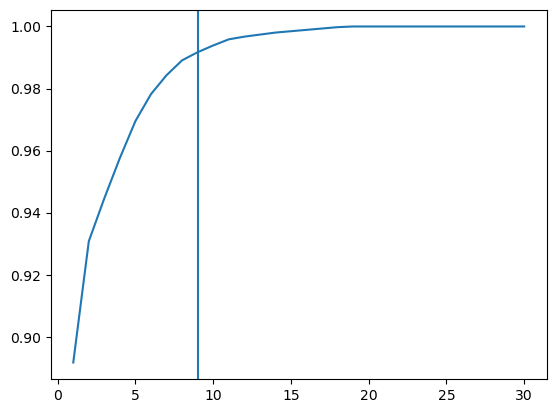

saving...
Estimating Gaussian KLD...
KLD:  743.2574782034883
train_stats:  (array([-4.3744171e-01,  7.4431649e-04,  2.5386541e-04, -4.2300872e-04,
        1.2056655e-03, -1.1084890e-03, -7.5301132e-04, -1.7609859e-04,
        8.4817625e-04], dtype=float32), array([[ 1.30069150e-03, -4.31172307e-04, -8.92610665e-05,
        -3.51029294e-04, -3.03783588e-04, -2.18354791e-05,
         1.09414446e-05, -1.17635398e-04,  1.05921721e-06],
       [-4.31172307e-04,  2.82373016e-02, -6.94184314e-06,
         1.52890986e-05, -2.93809199e-05,  3.60589924e-05,
         1.74682226e-05,  4.71726207e-06, -4.32521419e-05],
       [-8.92610665e-05, -6.94184314e-06,  9.95837848e-03,
         6.89236504e-05, -3.21326180e-05,  2.36607482e-05,
         8.27618526e-06,  2.17560005e-06, -1.45173083e-05],
       [-3.51029294e-04,  1.52890986e-05,  6.89236504e-05,
         8.90333266e-03, -1.23187107e-04,  2.33251338e-05,
         7.72745686e-06,  1.33936855e-06, -1.68325176e-05],
       [-3.03783588e-04, -2.93

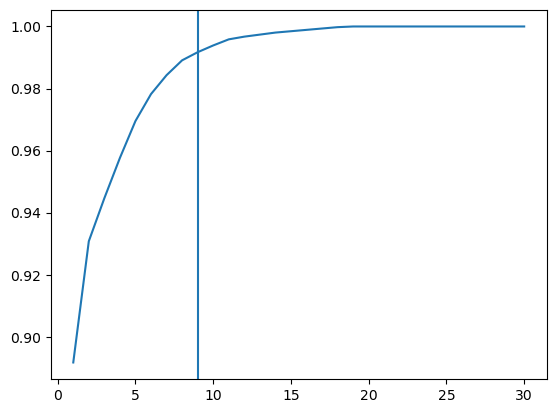

saving...
Estimating Gaussian KLD...
KLD:  743.2567303688292
train_stats:  (array([-4.3744171e-01,  7.4432360e-04,  2.5386381e-04, -4.2299737e-04,
        1.2056766e-03, -1.1084882e-03, -7.5301173e-04, -1.7610069e-04,
        8.4817677e-04], dtype=float32), array([[ 1.30069134e-03, -4.31163299e-04, -8.92588981e-05,
        -3.51030698e-04, -3.03781773e-04, -2.18351958e-05,
         1.09421174e-05, -1.17634897e-04,  1.05872321e-06],
       [-4.31163299e-04,  2.82373074e-02, -6.94175455e-06,
         1.52895403e-05, -2.93805515e-05,  3.60588752e-05,
         1.74678175e-05,  4.71710860e-06, -4.32519187e-05],
       [-8.92588981e-05, -6.94175455e-06,  9.95836753e-03,
         6.89268280e-05, -3.21292149e-05,  2.36625240e-05,
         8.27761255e-06,  2.17545914e-06, -1.45177836e-05],
       [-3.51030698e-04,  1.52895403e-05,  6.89268280e-05,
         8.90331845e-03, -1.23174953e-04,  2.33250256e-05,
         7.72801046e-06,  1.33935284e-06, -1.68336253e-05],
       [-3.03781773e-04, -2.93

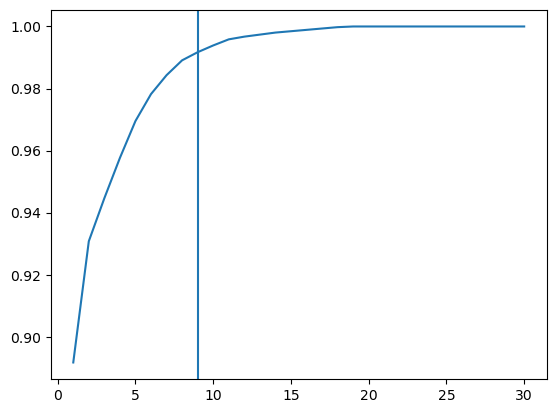

saving...
Estimating Gaussian KLD...
KLD:  743.2570248009883
train_stats:  (array([-4.3744165e-01,  7.4433343e-04,  2.5387193e-04, -4.2300025e-04,
        1.2056658e-03, -1.1084900e-03, -7.5301097e-04, -1.7610067e-04,
        8.4817485e-04], dtype=float32), array([[ 1.30069122e-03, -4.31161097e-04, -8.92541092e-05,
        -3.51029985e-04, -3.03783905e-04, -2.18364986e-05,
         1.09411929e-05, -1.17634479e-04,  1.05871302e-06],
       [-4.31161097e-04,  2.82373409e-02, -6.94183240e-06,
         1.52891438e-05, -2.93806364e-05,  3.60588924e-05,
         1.74678244e-05,  4.71713336e-06, -4.32520672e-05],
       [-8.92541092e-05, -6.94183240e-06,  9.95836496e-03,
         6.89319929e-05, -3.21278585e-05,  2.36620441e-05,
         8.27712092e-06,  2.17515416e-06, -1.45170997e-05],
       [-3.51029985e-04,  1.52891438e-05,  6.89319929e-05,
         8.90330878e-03, -1.23186023e-04,  2.33262923e-05,
         7.72758331e-06,  1.33866962e-06, -1.68335755e-05],
       [-3.03783905e-04, -2.93

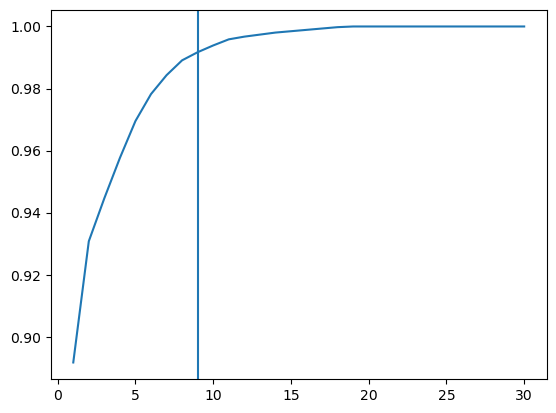

saving...
Estimating Gaussian KLD...
KLD:  743.2572418496304
train_stats:  (array([-4.3744171e-01,  7.4433064e-04,  2.5386779e-04, -4.2299728e-04,
        1.2056670e-03, -1.1084897e-03, -7.5301289e-04, -1.7610048e-04,
        8.4817508e-04], dtype=float32), array([[ 1.30069215e-03, -4.31176235e-04, -8.92535540e-05,
        -3.51030465e-04, -3.03783874e-04, -2.18360432e-05,
         1.09419109e-05, -1.17634954e-04,  1.05907958e-06],
       [-4.31176235e-04,  2.82373689e-02, -6.94188625e-06,
         1.52897339e-05, -2.93806688e-05,  3.60589395e-05,
         1.74678100e-05,  4.71704667e-06, -4.32520599e-05],
       [-8.92535540e-05, -6.94188625e-06,  9.95836385e-03,
         6.89306397e-05, -3.21319140e-05,  2.36606344e-05,
         8.27701080e-06,  2.17544429e-06, -1.45172783e-05],
       [-3.51030465e-04,  1.52897339e-05,  6.89306397e-05,
         8.90331279e-03, -1.23184811e-04,  2.33249703e-05,
         7.72813759e-06,  1.33946221e-06, -1.68333154e-05],
       [-3.03783874e-04, -2.93

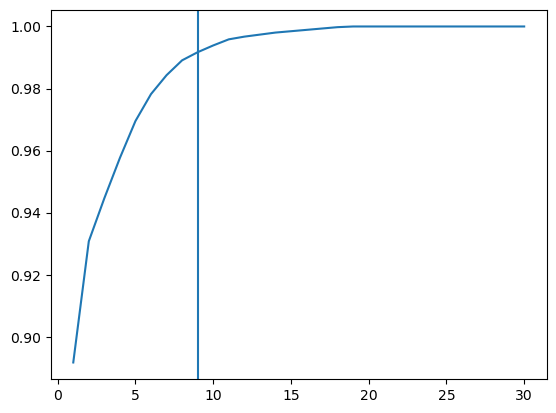

saving...
Estimating Gaussian KLD...
KLD:  743.257087306202
train_stats:  (array([-4.3744171e-01,  7.4432435e-04,  2.5386747e-04, -4.2300223e-04,
        1.2056668e-03, -1.1084850e-03, -7.5301359e-04, -1.7610098e-04,
        8.4817398e-04], dtype=float32), array([[ 1.30069127e-03, -4.31163421e-04, -8.92544350e-05,
        -3.51030243e-04, -3.03783137e-04, -2.18337930e-05,
         1.09417661e-05, -1.17633597e-04,  1.05829471e-06],
       [-4.31163421e-04,  2.82372695e-02, -6.94181098e-06,
         1.52893565e-05, -2.93805984e-05,  3.60588945e-05,
         1.74678064e-05,  4.71711128e-06, -4.32519385e-05],
       [-8.92544350e-05, -6.94181098e-06,  9.95836942e-03,
         6.89343659e-05, -3.21307051e-05,  2.36618174e-05,
         8.27733829e-06,  2.17546911e-06, -1.45157664e-05],
       [-3.51030243e-04,  1.52893565e-05,  6.89343659e-05,
         8.90330813e-03, -1.23181781e-04,  2.33260059e-05,
         7.72871870e-06,  1.34020066e-06, -1.68352234e-05],
       [-3.03783137e-04, -2.938

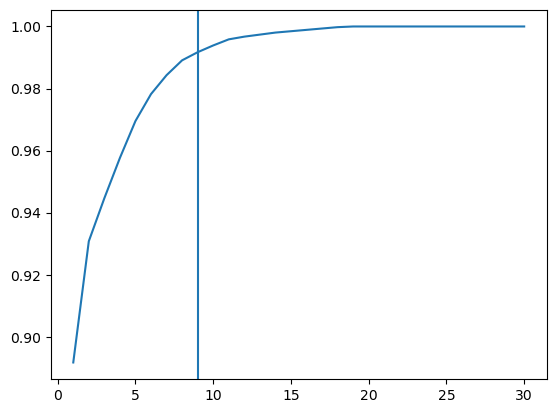

saving...
Estimating Gaussian KLD...
KLD:  743.2570424747669
train_stats:  (array([-4.3744171e-01,  7.4430753e-04,  2.5386646e-04, -4.2300081e-04,
        1.2056723e-03, -1.1084863e-03, -7.5301208e-04, -1.7610117e-04,
        8.4817433e-04], dtype=float32), array([[ 1.30069237e-03, -4.31180662e-04, -8.92598081e-05,
        -3.51030755e-04, -3.03781970e-04, -2.18356213e-05,
         1.09418201e-05, -1.17634795e-04,  1.05912613e-06],
       [-4.31180662e-04,  2.82372876e-02, -6.94137316e-06,
         1.52893366e-05, -2.93806974e-05,  3.60587908e-05,
         1.74677868e-05,  4.71712835e-06, -4.32519345e-05],
       [-8.92598081e-05, -6.94137316e-06,  9.95837415e-03,
         6.89278877e-05, -3.21304135e-05,  2.36612805e-05,
         8.27758721e-06,  2.17594198e-06, -1.45174945e-05],
       [-3.51030755e-04,  1.52893366e-05,  6.89278877e-05,
         8.90331469e-03, -1.23177137e-04,  2.33275260e-05,
         7.72828628e-06,  1.33846043e-06, -1.68333565e-05],
       [-3.03781970e-04, -2.93

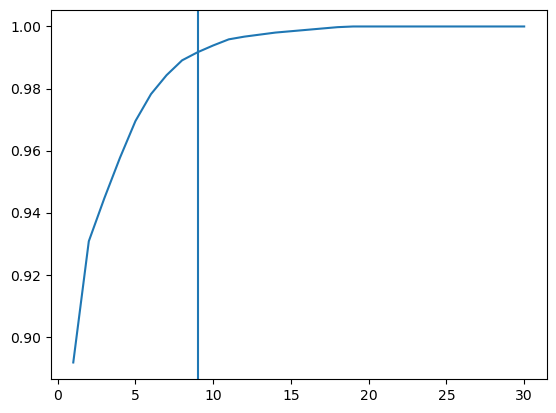

saving...
Estimating Gaussian KLD...
KLD:  743.2574492135202
train_stats:  (array([-4.3744171e-01,  7.4430607e-04,  2.5386680e-04, -4.2300599e-04,
        1.2056670e-03, -1.1084854e-03, -7.5301336e-04, -1.7610003e-04,
        8.4817520e-04], dtype=float32), array([[ 1.30069179e-03, -4.31182608e-04, -8.92567148e-05,
        -3.51029372e-04, -3.03783961e-04, -2.18354122e-05,
         1.09420150e-05, -1.17634968e-04,  1.05919277e-06],
       [-4.31182608e-04,  2.82373033e-02, -6.94194074e-06,
         1.52894784e-05, -2.93806494e-05,  3.60588587e-05,
         1.74678370e-05,  4.71710784e-06, -4.32520419e-05],
       [-8.92567148e-05, -6.94194074e-06,  9.95838193e-03,
         6.89276927e-05, -3.21310536e-05,  2.36621276e-05,
         8.27747989e-06,  2.17596826e-06, -1.45175488e-05],
       [-3.51029372e-04,  1.52894784e-05,  6.89276927e-05,
         8.90331069e-03, -1.23183787e-04,  2.33255250e-05,
         7.72826686e-06,  1.34064422e-06, -1.68341906e-05],
       [-3.03783961e-04, -2.93

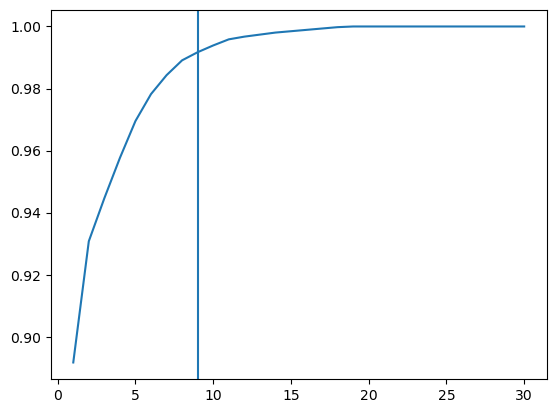

saving...
Estimating Gaussian KLD...
KLD:  743.257216890791
train_stats:  (array([-4.3744165e-01,  7.4431981e-04,  2.5386753e-04, -4.2299490e-04,
        1.2056722e-03, -1.1084866e-03, -7.5301330e-04, -1.7610073e-04,
        8.4817572e-04], dtype=float32), array([[ 1.30069107e-03, -4.31174827e-04, -8.92552667e-05,
        -3.51031977e-04, -3.03781169e-04, -2.18351533e-05,
         1.09422714e-05, -1.17635306e-04,  1.05942131e-06],
       [-4.31174827e-04,  2.82372999e-02, -6.94279563e-06,
         1.52897939e-05, -2.93790504e-05,  3.60587801e-05,
         1.74677501e-05,  4.71726299e-06, -4.32521772e-05],
       [-8.92552667e-05, -6.94279563e-06,  9.95838807e-03,
         6.89283119e-05, -3.21287791e-05,  2.36610304e-05,
         8.27774537e-06,  2.17535866e-06, -1.45171975e-05],
       [-3.51031977e-04,  1.52897939e-05,  6.89283119e-05,
         8.90332255e-03, -1.23177748e-04,  2.33253954e-05,
         7.72606558e-06,  1.33949201e-06, -1.68338808e-05],
       [-3.03781169e-04, -2.937

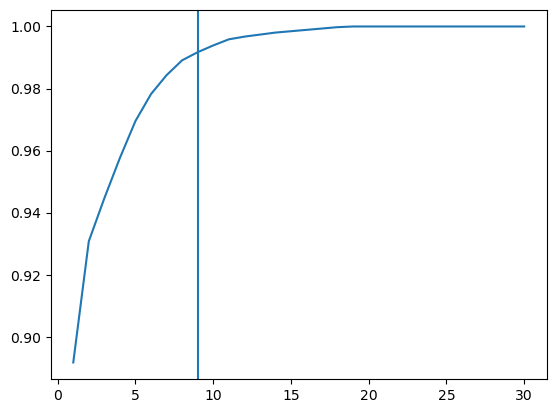

saving...
Estimating Gaussian KLD...
KLD:  743.2573731899411
train_stats:  (array([-4.3744171e-01,  7.4431614e-04,  2.5386002e-04, -4.2299909e-04,
        1.2056669e-03, -1.1084890e-03, -7.5301237e-04, -1.7610159e-04,
        8.4817503e-04], dtype=float32), array([[ 1.30069161e-03, -4.31173264e-04, -8.92573534e-05,
        -3.51031163e-04, -3.03782322e-04, -2.18358685e-05,
         1.09422266e-05, -1.17634828e-04,  1.05867405e-06],
       [-4.31173264e-04,  2.82373102e-02, -6.94357275e-06,
         1.52961936e-05, -2.93817116e-05,  3.60585367e-05,
         1.74677780e-05,  4.71714667e-06, -4.32522543e-05],
       [-8.92573534e-05, -6.94357275e-06,  9.95836787e-03,
         6.89277447e-05, -3.21319225e-05,  2.36613130e-05,
         8.27775115e-06,  2.17526041e-06, -1.45162420e-05],
       [-3.51031163e-04,  1.52961936e-05,  6.89277447e-05,
         8.90331307e-03, -1.23177693e-04,  2.33253845e-05,
         7.72800454e-06,  1.33916717e-06, -1.68329904e-05],
       [-3.03782322e-04, -2.93

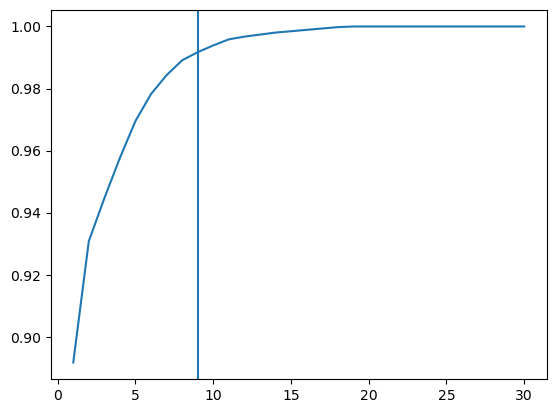

saving...
Estimating Gaussian KLD...
KLD:  743.2568082711125
train_stats:  (array([-4.3744171e-01,  7.4431684e-04,  2.5386264e-04, -4.2299036e-04,
        1.2056759e-03, -1.1084882e-03, -7.5301062e-04, -1.7610023e-04,
        8.4817503e-04], dtype=float32), array([[ 1.30069194e-03, -4.31171484e-04, -8.92568116e-05,
        -3.51030533e-04, -3.03781262e-04, -2.18356845e-05,
         1.09421032e-05, -1.17634637e-04,  1.05897185e-06],
       [-4.31171484e-04,  2.82373221e-02, -6.94129465e-06,
         1.52889287e-05, -2.93814635e-05,  3.60588609e-05,
         1.74677757e-05,  4.71708509e-06, -4.32520103e-05],
       [-8.92568116e-05, -6.94129465e-06,  9.95837384e-03,
         6.89281009e-05, -3.21355292e-05,  2.36597935e-05,
         8.27723366e-06,  2.17566929e-06, -1.45172688e-05],
       [-3.51030533e-04,  1.52889287e-05,  6.89281009e-05,
         8.90330962e-03, -1.23173869e-04,  2.33262048e-05,
         7.72825069e-06,  1.33967213e-06, -1.68333154e-05],
       [-3.03781262e-04, -2.93

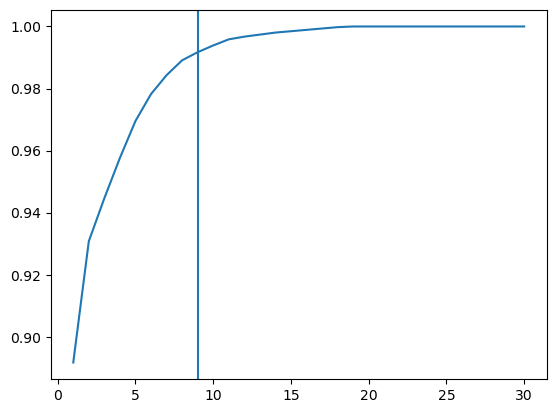

saving...
Estimating Gaussian KLD...
KLD:  743.2571591683475
train_stats:  (array([-4.3744171e-01,  7.4431801e-04,  2.5386343e-04, -4.2300104e-04,
        1.2056689e-03, -1.1084864e-03, -7.5301307e-04, -1.7610130e-04,
        8.4817718e-04], dtype=float32), array([[ 1.30069209e-03, -4.31175918e-04, -8.92580797e-05,
        -3.51030098e-04, -3.03781195e-04, -2.18346982e-05,
         1.09423632e-05, -1.17634661e-04,  1.05956629e-06],
       [-4.31175918e-04,  2.82373162e-02, -6.94155382e-06,
         1.52894033e-05, -2.93804661e-05,  3.60588299e-05,
         1.74678286e-05,  4.71709838e-06, -4.32521393e-05],
       [-8.92580797e-05, -6.94155382e-06,  9.95836241e-03,
         6.89277678e-05, -3.21313873e-05,  2.36602012e-05,
         8.27698938e-06,  2.17565467e-06, -1.45178917e-05],
       [-3.51030098e-04,  1.52894033e-05,  6.89277678e-05,
         8.90330505e-03, -1.23180507e-04,  2.33241133e-05,
         7.72899357e-06,  1.34015694e-06, -1.68336727e-05],
       [-3.03781195e-04, -2.93

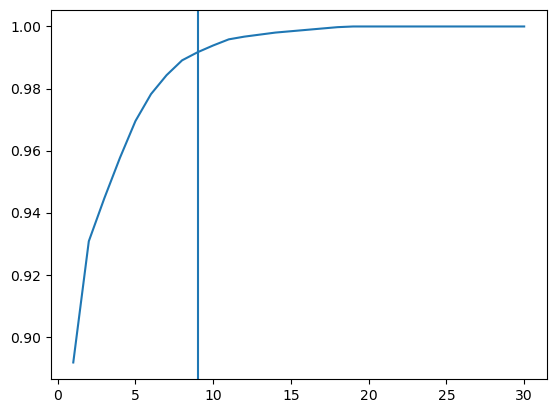

saving...
Estimating Gaussian KLD...
KLD:  743.2575590692961
train_stats:  (array([-4.3744165e-01,  7.4431504e-04,  2.5386154e-04, -4.2300113e-04,
        1.2056709e-03, -1.1084864e-03, -7.5301173e-04, -1.7610277e-04,
        8.4817572e-04], dtype=float32), array([[ 1.30069065e-03, -4.31169190e-04, -8.92536278e-05,
        -3.51029527e-04, -3.03783626e-04, -2.18357042e-05,
         1.09422223e-05, -1.17634788e-04,  1.05942132e-06],
       [-4.31169190e-04,  2.82372744e-02, -6.94179320e-06,
         1.52901156e-05, -2.93805123e-05,  3.60587626e-05,
         1.74677427e-05,  4.71716825e-06, -4.32519703e-05],
       [-8.92536278e-05, -6.94179320e-06,  9.95836595e-03,
         6.89338434e-05, -3.21335142e-05,  2.36631510e-05,
         8.27817013e-06,  2.17554782e-06, -1.45170132e-05],
       [-3.51029527e-04,  1.52901156e-05,  6.89338434e-05,
         8.90331935e-03, -1.23183746e-04,  2.33258028e-05,
         7.72802453e-06,  1.33929729e-06, -1.68336313e-05],
       [-3.03783626e-04, -2.93

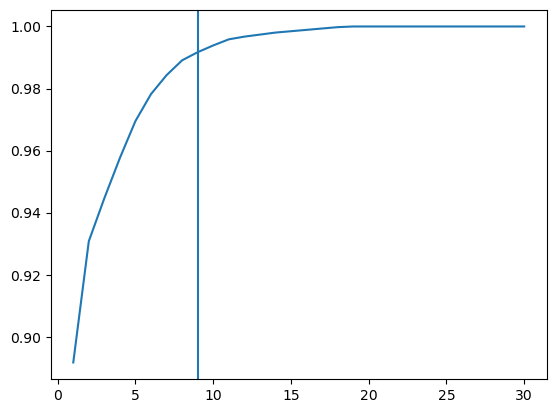

saving...
Estimating Gaussian KLD...
KLD:  743.2566524550906
train_stats:  (array([-4.3744171e-01,  7.4432930e-04,  2.5386727e-04, -4.2298820e-04,
        1.2056709e-03, -1.1084890e-03, -7.5301074e-04, -1.7610234e-04,
        8.4817695e-04], dtype=float32), array([[ 1.30069183e-03, -4.31174403e-04, -8.92566838e-05,
        -3.51032695e-04, -3.03779865e-04, -2.18356281e-05,
         1.09423998e-05, -1.17634930e-04,  1.05913800e-06],
       [-4.31174403e-04,  2.82373546e-02, -6.94365973e-06,
         1.52879525e-05, -2.93805058e-05,  3.60584882e-05,
         1.74677627e-05,  4.71713603e-06, -4.32520603e-05],
       [-8.92566838e-05, -6.94365973e-06,  9.95837743e-03,
         6.89271312e-05, -3.21274693e-05,  2.36613333e-05,
         8.27712178e-06,  2.17612775e-06, -1.45172155e-05],
       [-3.51032695e-04,  1.52879525e-05,  6.89271312e-05,
         8.90332738e-03, -1.23175158e-04,  2.33269872e-05,
         7.72779145e-06,  1.33959211e-06, -1.68346529e-05],
       [-3.03779865e-04, -2.93

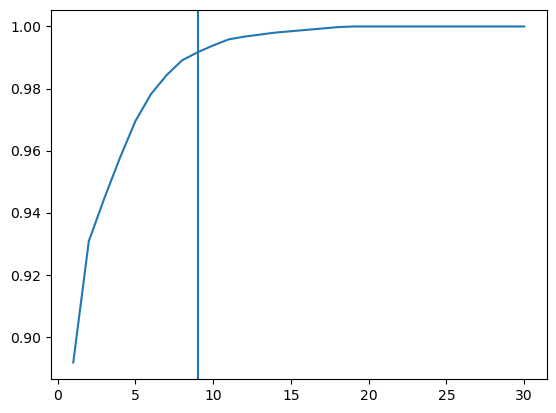

saving...
Estimating Gaussian KLD...
KLD:  743.2576538935106
train_stats:  (array([-4.3744165e-01,  7.4431230e-04,  2.5387123e-04, -4.2298858e-04,
        1.2056696e-03, -1.1084866e-03, -7.5301109e-04, -1.7610168e-04,
        8.4817491e-04], dtype=float32), array([[ 1.30069113e-03, -4.31190624e-04, -8.92545999e-05,
        -3.51033249e-04, -3.03780323e-04, -2.18353741e-05,
         1.09419088e-05, -1.17634652e-04,  1.05912244e-06],
       [-4.31190624e-04,  2.82373111e-02, -6.94197260e-06,
         1.52891881e-05, -2.93801085e-05,  3.60588063e-05,
         1.74677383e-05,  4.71710633e-06, -4.32519665e-05],
       [-8.92545999e-05, -6.94197260e-06,  9.95837091e-03,
         6.89317326e-05, -3.21270648e-05,  2.36623860e-05,
         8.27897538e-06,  2.17594605e-06, -1.45176212e-05],
       [-3.51033249e-04,  1.52891881e-05,  6.89317326e-05,
         8.90332110e-03, -1.23173672e-04,  2.33266004e-05,
         7.72666682e-06,  1.33937836e-06, -1.68335236e-05],
       [-3.03780323e-04, -2.93

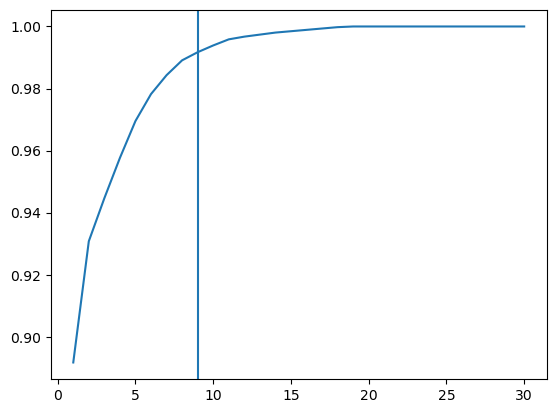

saving...
Estimating Gaussian KLD...
KLD:  743.25763415644
train_stats:  (array([-4.3744171e-01,  7.4432010e-04,  2.5386678e-04, -4.2300747e-04,
        1.2056674e-03, -1.1084868e-03, -7.5301272e-04, -1.7610144e-04,
        8.4817619e-04], dtype=float32), array([[ 1.30069110e-03, -4.31162350e-04, -8.92586805e-05,
        -3.51028892e-04, -3.03785414e-04, -2.18354239e-05,
         1.09420762e-05, -1.17635159e-04,  1.05895067e-06],
       [-4.31162350e-04,  2.82372617e-02, -6.94168169e-06,
         1.52894276e-05, -2.93804494e-05,  3.60588680e-05,
         1.74678402e-05,  4.71711991e-06, -4.32521062e-05],
       [-8.92586805e-05, -6.94168169e-06,  9.95836780e-03,
         6.89261933e-05, -3.21328162e-05,  2.36596095e-05,
         8.27698944e-06,  2.17474669e-06, -1.45176699e-05],
       [-3.51028892e-04,  1.52894276e-05,  6.89261933e-05,
         8.90330292e-03, -1.23187219e-04,  2.33277155e-05,
         7.72801275e-06,  1.33957615e-06, -1.68338284e-05],
       [-3.03785414e-04, -2.9380

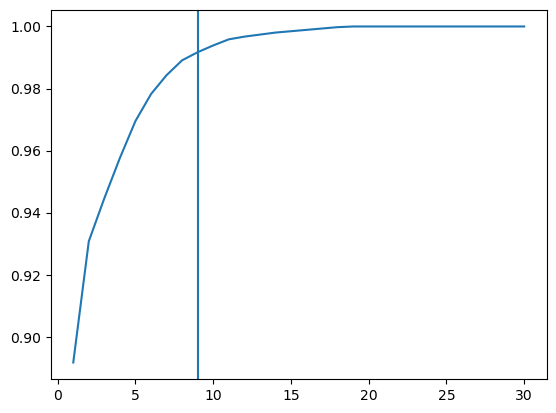

saving...
Estimating Gaussian KLD...
KLD:  743.2573792392628
train_stats:  (array([-4.3744165e-01,  7.4432901e-04,  2.5386506e-04, -4.2300156e-04,
        1.2056665e-03, -1.1084861e-03, -7.5301417e-04, -1.7610287e-04,
        8.4817351e-04], dtype=float32), array([[ 1.30069095e-03, -4.31177811e-04, -8.92593912e-05,
        -3.51029736e-04, -3.03782190e-04, -2.18348483e-05,
         1.09422124e-05, -1.17635619e-04,  1.05862977e-06],
       [-4.31177811e-04,  2.82373526e-02, -6.94271199e-06,
         1.52895362e-05, -2.93807544e-05,  3.60590011e-05,
         1.74678521e-05,  4.71682867e-06, -4.32520445e-05],
       [-8.92593912e-05, -6.94271199e-06,  9.95835211e-03,
         6.89284369e-05, -3.21315511e-05,  2.36624924e-05,
         8.27731586e-06,  2.17508246e-06, -1.45176627e-05],
       [-3.51029736e-04,  1.52895362e-05,  6.89284369e-05,
         8.90331563e-03, -1.23180366e-04,  2.33244895e-05,
         7.72929557e-06,  1.33922475e-06, -1.68336094e-05],
       [-3.03782190e-04, -2.93

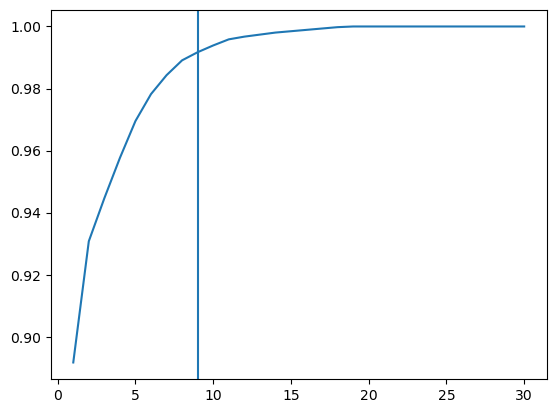

saving...
Estimating Gaussian KLD...
KLD:  743.2571465788425
train_stats:  (array([-4.3744168e-01,  7.4432511e-04,  2.5386523e-04, -4.2300328e-04,
        1.2056652e-03, -1.1084904e-03, -7.5301295e-04, -1.7610204e-04,
        8.4817421e-04], dtype=float32), array([[ 1.30069113e-03, -4.31159023e-04, -8.92586296e-05,
        -3.51029361e-04, -3.03784103e-04, -2.18349121e-05,
         1.09427323e-05, -1.17634722e-04,  1.05848242e-06],
       [-4.31159023e-04,  2.82372927e-02, -6.94155228e-06,
         1.52892906e-05, -2.93804149e-05,  3.60589009e-05,
         1.74678610e-05,  4.71716800e-06, -4.32519259e-05],
       [-8.92586296e-05, -6.94155228e-06,  9.95837894e-03,
         6.89257944e-05, -3.21279170e-05,  2.36616402e-05,
         8.27782765e-06,  2.17555148e-06, -1.45174788e-05],
       [-3.51029361e-04,  1.52892906e-05,  6.89257944e-05,
         8.90332501e-03, -1.23182144e-04,  2.33252077e-05,
         7.72871543e-06,  1.33923177e-06, -1.68339927e-05],
       [-3.03784103e-04, -2.93

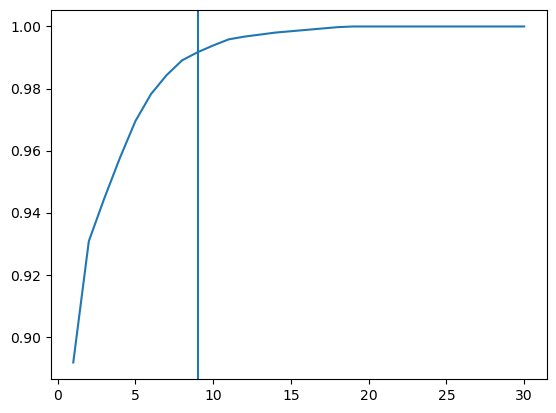

saving...
Estimating Gaussian KLD...
KLD:  743.256868001077
train_stats:  (array([-4.3744171e-01,  7.4433384e-04,  2.5386902e-04, -4.2299947e-04,
        1.2056716e-03, -1.1084870e-03, -7.5301103e-04, -1.7610048e-04,
        8.4817619e-04], dtype=float32), array([[ 1.30069147e-03, -4.31163850e-04, -8.92569359e-05,
        -3.51031395e-04, -3.03782611e-04, -2.18356604e-05,
         1.09417480e-05, -1.17634727e-04,  1.05842227e-06],
       [-4.31163850e-04,  2.82373398e-02, -6.94187637e-06,
         1.52894401e-05, -2.93804035e-05,  3.60588739e-05,
         1.74677740e-05,  4.71707092e-06, -4.32520417e-05],
       [-8.92569359e-05, -6.94187637e-06,  9.95838404e-03,
         6.89295051e-05, -3.21279662e-05,  2.36610666e-05,
         8.27743282e-06,  2.17503034e-06, -1.45181302e-05],
       [-3.51031395e-04,  1.52894401e-05,  6.89295051e-05,
         8.90332303e-03, -1.23180045e-04,  2.33259816e-05,
         7.72828825e-06,  1.33954996e-06, -1.68334559e-05],
       [-3.03782611e-04, -2.938

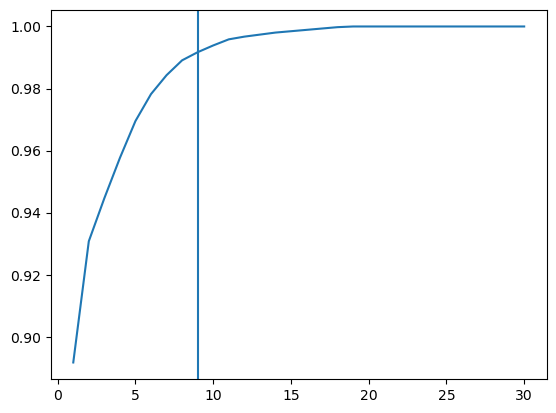

saving...
Estimating Gaussian KLD...
KLD:  743.2565320798018
train_stats:  (array([-4.3744171e-01,  7.4431929e-04,  2.5386387e-04, -4.2301419e-04,
        1.2056653e-03, -1.1084899e-03, -7.5301237e-04, -1.7610252e-04,
        8.4817357e-04], dtype=float32), array([[ 1.30069210e-03, -4.31177657e-04, -8.92619874e-05,
        -3.51025707e-04, -3.03785208e-04, -2.18350346e-05,
         1.09424459e-05, -1.17635003e-04,  1.05861333e-06],
       [-4.31177657e-04,  2.82372917e-02, -6.94220502e-06,
         1.52877917e-05, -2.93792873e-05,  3.60588397e-05,
         1.74677598e-05,  4.71717142e-06, -4.32517818e-05],
       [-8.92619874e-05, -6.94220502e-06,  9.95836799e-03,
         6.89243076e-05, -3.21308396e-05,  2.36615625e-05,
         8.27805157e-06,  2.17564140e-06, -1.45175787e-05],
       [-3.51025707e-04,  1.52877917e-05,  6.89243076e-05,
         8.90330874e-03, -1.23192166e-04,  2.33254278e-05,
         7.72792914e-06,  1.33899560e-06, -1.68327910e-05],
       [-3.03785208e-04, -2.93

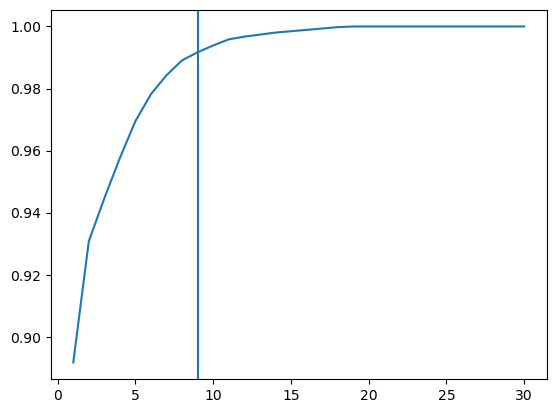

saving...
Estimating Gaussian KLD...
KLD:  743.2568670012629
train_stats:  (array([-4.3744165e-01,  7.4431387e-04,  2.5386384e-04, -4.2300159e-04,
        1.2056704e-03, -1.1084885e-03, -7.5301243e-04, -1.7610082e-04,
        8.4817602e-04], dtype=float32), array([[ 1.30069228e-03, -4.31183436e-04, -8.92556711e-05,
        -3.51030986e-04, -3.03783345e-04, -2.18358878e-05,
         1.09420840e-05, -1.17635132e-04,  1.05956718e-06],
       [-4.31183436e-04,  2.82372902e-02, -6.94196075e-06,
         1.52892331e-05, -2.93807265e-05,  3.60588366e-05,
         1.74678016e-05,  4.71711988e-06, -4.32521604e-05],
       [-8.92556711e-05, -6.94196075e-06,  9.95837373e-03,
         6.89344781e-05, -3.21309036e-05,  2.36615289e-05,
         8.27716126e-06,  2.17618704e-06, -1.45175045e-05],
       [-3.51030986e-04,  1.52892331e-05,  6.89344781e-05,
         8.90333539e-03, -1.23182790e-04,  2.33284328e-05,
         7.72834038e-06,  1.33872273e-06, -1.68335969e-05],
       [-3.03783345e-04, -2.93

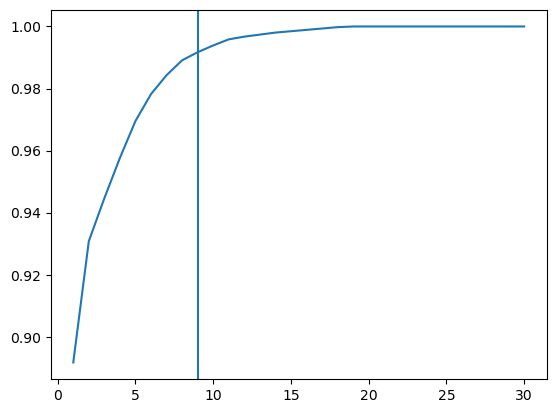

saving...
Estimating Gaussian KLD...
KLD:  743.2577642825154
train_stats:  (array([-4.3744165e-01,  7.4432092e-04,  2.5386890e-04, -4.2299993e-04,
        1.2056720e-03, -1.1084897e-03, -7.5301144e-04, -1.7610106e-04,
        8.4817561e-04], dtype=float32), array([[ 1.30069069e-03, -4.31175377e-04, -8.92613312e-05,
        -3.51029964e-04, -3.03782569e-04, -2.18356499e-05,
         1.09421324e-05, -1.17634993e-04,  1.05901611e-06],
       [-4.31175377e-04,  2.82372854e-02, -6.94161862e-06,
         1.52892370e-05, -2.93806519e-05,  3.60588871e-05,
         1.74677568e-05,  4.71709606e-06, -4.32520593e-05],
       [-8.92613312e-05, -6.94161862e-06,  9.95837827e-03,
         6.89235156e-05, -3.21308630e-05,  2.36611616e-05,
         8.27753711e-06,  2.17559096e-06, -1.45177464e-05],
       [-3.51029964e-04,  1.52892370e-05,  6.89235156e-05,
         8.90332370e-03, -1.23179113e-04,  2.33262558e-05,
         7.72742938e-06,  1.33930476e-06, -1.68335114e-05],
       [-3.03782569e-04, -2.93

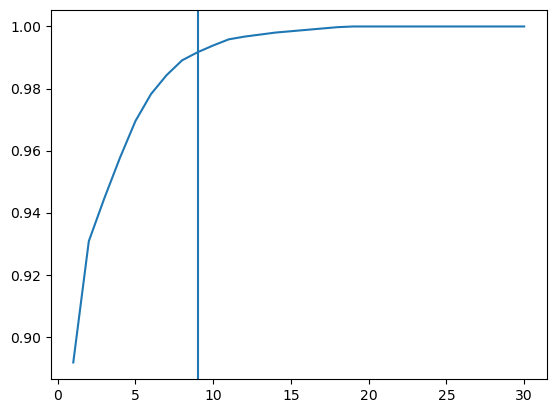

saving...
Estimating Gaussian KLD...
KLD:  743.2571533905083
train_stats:  (array([-4.3744171e-01,  7.4431539e-04,  2.5386381e-04, -4.2299225e-04,
        1.2056715e-03, -1.1084876e-03, -7.5301173e-04, -1.7610053e-04,
        8.4817474e-04], dtype=float32), array([[ 1.30069142e-03, -4.31167728e-04, -8.92572744e-05,
        -3.51032360e-04, -3.03780000e-04, -2.18346336e-05,
         1.09414735e-05, -1.17634779e-04,  1.05885696e-06],
       [-4.31167728e-04,  2.82372668e-02, -6.94185329e-06,
         1.52893096e-05, -2.93807179e-05,  3.60588987e-05,
         1.74677747e-05,  4.71708512e-06, -4.32519939e-05],
       [-8.92572744e-05, -6.94185329e-06,  9.95837172e-03,
         6.89292895e-05, -3.21305901e-05,  2.36621319e-05,
         8.27702127e-06,  2.17588407e-06, -1.45176696e-05],
       [-3.51032360e-04,  1.52893096e-05,  6.89292895e-05,
         8.90331614e-03, -1.23172610e-04,  2.33253412e-05,
         7.72666328e-06,  1.33973182e-06, -1.68341641e-05],
       [-3.03780000e-04, -2.93

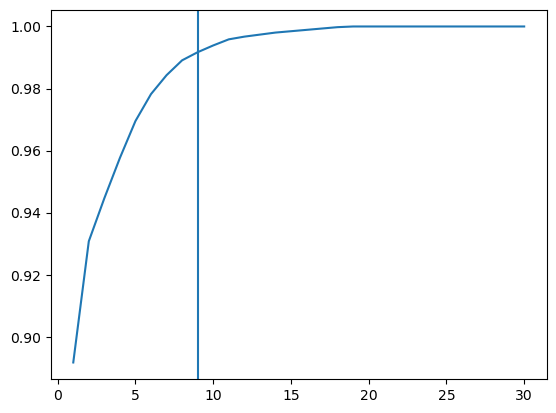

saving...
Estimating Gaussian KLD...
KLD:  743.2571781929142
train_stats:  (array([-4.3744171e-01,  7.4431224e-04,  2.5386893e-04, -4.2300290e-04,
        1.2056681e-03, -1.1084853e-03, -7.5301435e-04, -1.7609991e-04,
        8.4817538e-04], dtype=float32), array([[ 1.30069208e-03, -4.31180186e-04, -8.92578530e-05,
        -3.51030283e-04, -3.03783349e-04, -2.18351100e-05,
         1.09413334e-05, -1.17634235e-04,  1.05933428e-06],
       [-4.31180186e-04,  2.82373221e-02, -6.94173012e-06,
         1.52894668e-05, -2.93805417e-05,  3.60587440e-05,
         1.74678491e-05,  4.71706035e-06, -4.32520755e-05],
       [-8.92578530e-05, -6.94173012e-06,  9.95837109e-03,
         6.89296847e-05, -3.21293069e-05,  2.36603750e-05,
         8.27628303e-06,  2.17708328e-06, -1.45173604e-05],
       [-3.51030283e-04,  1.52894668e-05,  6.89296847e-05,
         8.90332562e-03, -1.23181531e-04,  2.33273768e-05,
         7.72756695e-06,  1.34135399e-06, -1.68313968e-05],
       [-3.03783349e-04, -2.93

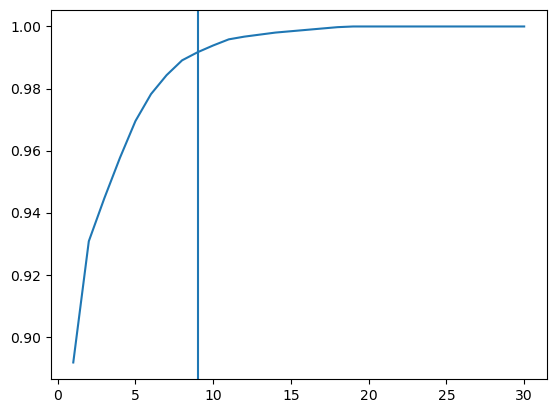

saving...
Estimating Gaussian KLD...
KLD:  743.2576794472052
train_stats:  (array([-4.3744165e-01,  7.4432400e-04,  2.5386675e-04, -4.2299778e-04,
        1.2056696e-03, -1.1084854e-03, -7.5300975e-04, -1.7610245e-04,
        8.4817701e-04], dtype=float32), array([[ 1.30069080e-03, -4.31173213e-04, -8.92572104e-05,
        -3.51030872e-04, -3.03781957e-04, -2.18355115e-05,
         1.09422668e-05, -1.17635002e-04,  1.05962870e-06],
       [-4.31173213e-04,  2.82372850e-02, -6.94173885e-06,
         1.52893052e-05, -2.93806347e-05,  3.60588195e-05,
         1.74677483e-05,  4.71714392e-06, -4.32521914e-05],
       [-8.92572104e-05, -6.94173885e-06,  9.95836036e-03,
         6.89284019e-05, -3.21300816e-05,  2.36619068e-05,
         8.27747691e-06,  2.17570922e-06, -1.45173127e-05],
       [-3.51030872e-04,  1.52893052e-05,  6.89284019e-05,
         8.90331609e-03, -1.23180391e-04,  2.33238551e-05,
         7.72749199e-06,  1.33986122e-06, -1.68346245e-05],
       [-3.03781957e-04, -2.93

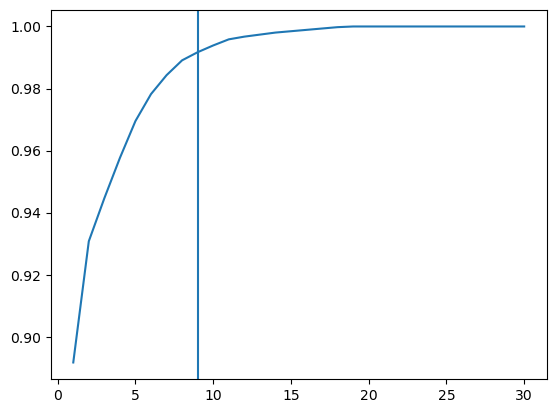

saving...
Estimating Gaussian KLD...
KLD:  743.2571932119974
train_stats:  (array([-4.3744171e-01,  7.4432266e-04,  2.5386800e-04, -4.2299705e-04,
        1.2056720e-03, -1.1084839e-03, -7.5301219e-04, -1.7610198e-04,
        8.4817508e-04], dtype=float32), array([[ 1.30069174e-03, -4.31168505e-04, -8.92567321e-05,
        -3.51030310e-04, -3.03782527e-04, -2.18355097e-05,
         1.09422389e-05, -1.17634793e-04,  1.05879464e-06],
       [-4.31168505e-04,  2.82372809e-02, -6.94145658e-06,
         1.52894103e-05, -2.93804807e-05,  3.60587255e-05,
         1.74678334e-05,  4.71713748e-06, -4.32519789e-05],
       [-8.92567321e-05, -6.94145658e-06,  9.95838020e-03,
         6.89312611e-05, -3.21295410e-05,  2.36625630e-05,
         8.27739832e-06,  2.17607876e-06, -1.45182466e-05],
       [-3.51030310e-04,  1.52894103e-05,  6.89312611e-05,
         8.90331788e-03, -1.23183039e-04,  2.33262744e-05,
         7.72838937e-06,  1.33835197e-06, -1.68343163e-05],
       [-3.03782527e-04, -2.93

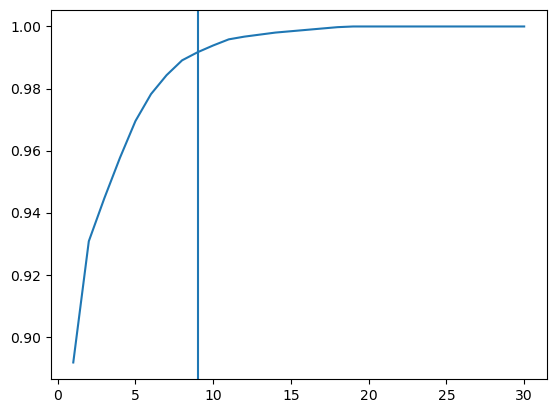

saving...
Estimating Gaussian KLD...
KLD:  743.2574065941697
train_stats:  (array([-4.3744165e-01,  7.4433093e-04,  2.5386745e-04, -4.2299164e-04,
        1.2056713e-03, -1.1084888e-03, -7.5301353e-04, -1.7610098e-04,
        8.4817712e-04], dtype=float32), array([[ 1.30069082e-03, -4.31168758e-04, -8.92598695e-05,
        -3.51030680e-04, -3.03782056e-04, -2.18359695e-05,
         1.09415443e-05, -1.17635059e-04,  1.05910141e-06],
       [-4.31168758e-04,  2.82373123e-02, -6.94172432e-06,
         1.52894123e-05, -2.93807391e-05,  3.60587581e-05,
         1.74678262e-05,  4.71711945e-06, -4.32521995e-05],
       [-8.92598695e-05, -6.94172432e-06,  9.95835666e-03,
         6.89248081e-05, -3.21302849e-05,  2.36620308e-05,
         8.27717906e-06,  2.17551148e-06, -1.45172596e-05],
       [-3.51030680e-04,  1.52894123e-05,  6.89248081e-05,
         8.90330336e-03, -1.23176316e-04,  2.33278332e-05,
         7.72689125e-06,  1.33980599e-06, -1.68318091e-05],
       [-3.03782056e-04, -2.93

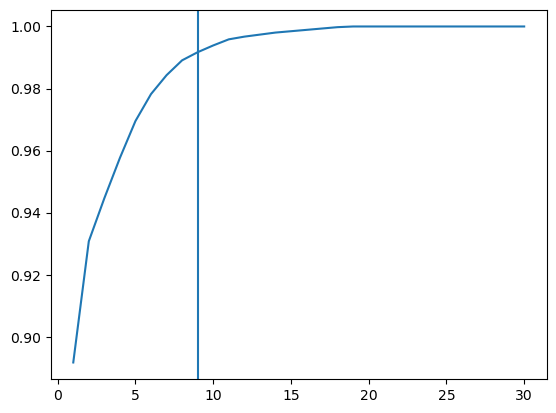

saving...
Estimating Gaussian KLD...
KLD:  743.257492506626
train_stats:  (array([-4.3744168e-01,  7.4433355e-04,  2.5386611e-04, -4.2300258e-04,
        1.2056710e-03, -1.1084930e-03, -7.5300917e-04, -1.7610322e-04,
        8.4817706e-04], dtype=float32), array([[ 1.30069101e-03, -4.31159234e-04, -8.92554972e-05,
        -3.51028491e-04, -3.03784022e-04, -2.18355389e-05,
         1.09425430e-05, -1.17634938e-04,  1.05937251e-06],
       [-4.31159234e-04,  2.82373182e-02, -6.94186865e-06,
         1.52895986e-05, -2.93806928e-05,  3.60589522e-05,
         1.74677176e-05,  4.71714968e-06, -4.32521585e-05],
       [-8.92554972e-05, -6.94186865e-06,  9.95835678e-03,
         6.89296958e-05, -3.21295976e-05,  2.36613721e-05,
         8.27722917e-06,  2.17577033e-06, -1.45173045e-05],
       [-3.51028491e-04,  1.52895986e-05,  6.89296958e-05,
         8.90331810e-03, -1.23186012e-04,  2.33270133e-05,
         7.72750718e-06,  1.33924853e-06, -1.68338621e-05],
       [-3.03784022e-04, -2.938

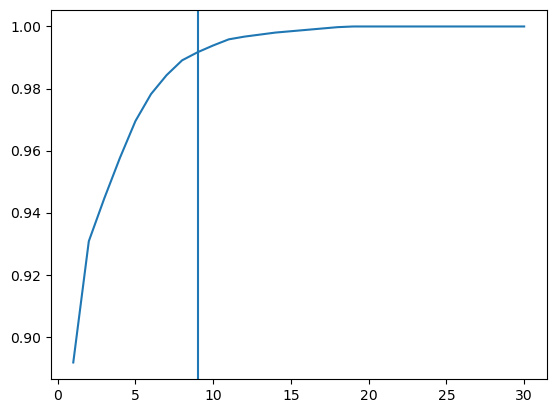

saving...
Estimating Gaussian KLD...
KLD:  743.2569033152894
train_stats:  (array([-4.3744171e-01,  7.4431172e-04,  2.5386908e-04, -4.2300104e-04,
        1.2056686e-03, -1.1084867e-03, -7.5301318e-04, -1.7610112e-04,
        8.4817392e-04], dtype=float32), array([[ 1.30069223e-03, -4.31177294e-04, -8.92565853e-05,
        -3.51030406e-04, -3.03782754e-04, -2.18356579e-05,
         1.09418327e-05, -1.17634995e-04,  1.05876638e-06],
       [-4.31177294e-04,  2.82372762e-02, -6.94257490e-06,
         1.52885140e-05, -2.93804586e-05,  3.60587246e-05,
         1.74678029e-05,  4.71712798e-06, -4.32519700e-05],
       [-8.92565853e-05, -6.94257490e-06,  9.95837059e-03,
         6.89273384e-05, -3.21308263e-05,  2.36612866e-05,
         8.27762583e-06,  2.17525339e-06, -1.45181243e-05],
       [-3.51030406e-04,  1.52885140e-05,  6.89273384e-05,
         8.90330976e-03, -1.23182256e-04,  2.33257922e-05,
         7.72681076e-06,  1.33811519e-06, -1.68338230e-05],
       [-3.03782754e-04, -2.93

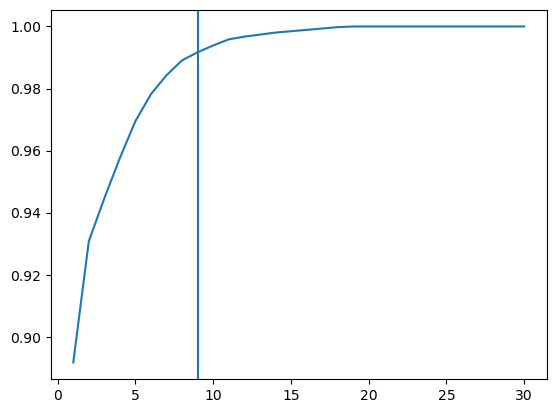

saving...
Estimating Gaussian KLD...
KLD:  743.2570215418327
train_stats:  (array([-4.3744171e-01,  7.4431271e-04,  2.5387437e-04, -4.2300145e-04,
        1.2056698e-03, -1.1084855e-03, -7.5301068e-04, -1.7610146e-04,
        8.4817369e-04], dtype=float32), array([[ 1.30069160e-03, -4.31173138e-04, -8.92583868e-05,
        -3.51028821e-04, -3.03782746e-04, -2.18350921e-05,
         1.09424945e-05, -1.17634705e-04,  1.05873976e-06],
       [-4.31173138e-04,  2.82373124e-02, -6.94157342e-06,
         1.52900176e-05, -2.93807201e-05,  3.60589272e-05,
         1.74679046e-05,  4.71716648e-06, -4.32519444e-05],
       [-8.92583868e-05, -6.94157342e-06,  9.95836385e-03,
         6.89291002e-05, -3.21250763e-05,  2.36626397e-05,
         8.27828776e-06,  2.17567125e-06, -1.45179809e-05],
       [-3.51028821e-04,  1.52900176e-05,  6.89291002e-05,
         8.90330413e-03, -1.23184126e-04,  2.33256300e-05,
         7.72817982e-06,  1.33953049e-06, -1.68327866e-05],
       [-3.03782746e-04, -2.93

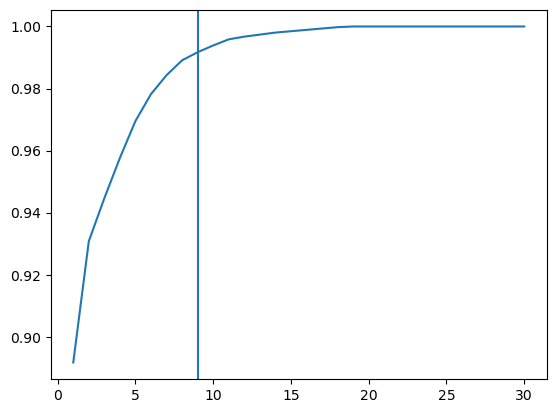

saving...
Estimating Gaussian KLD...
KLD:  743.2578244247097
train_stats:  (array([-4.3744165e-01,  7.4431760e-04,  2.5386296e-04, -4.2299196e-04,
        1.2056758e-03, -1.1084867e-03, -7.5301179e-04, -1.7610073e-04,
        8.4817468e-04], dtype=float32), array([[ 1.30069096e-03, -4.31176364e-04, -8.92547159e-05,
        -3.51032172e-04, -3.03780960e-04, -2.18358212e-05,
         1.09418640e-05, -1.17634950e-04,  1.05904766e-06],
       [-4.31176364e-04,  2.82372621e-02, -6.94164321e-06,
         1.52892733e-05, -2.93804184e-05,  3.60588284e-05,
         1.74677684e-05,  4.71712825e-06, -4.32519929e-05],
       [-8.92547159e-05, -6.94164321e-06,  9.95836008e-03,
         6.89285668e-05, -3.21300395e-05,  2.36602315e-05,
         8.27736031e-06,  2.17535980e-06, -1.45177928e-05],
       [-3.51032172e-04,  1.52892733e-05,  6.89285668e-05,
         8.90331130e-03, -1.23176170e-04,  2.33242358e-05,
         7.72651440e-06,  1.34051699e-06, -1.68336163e-05],
       [-3.03780960e-04, -2.93

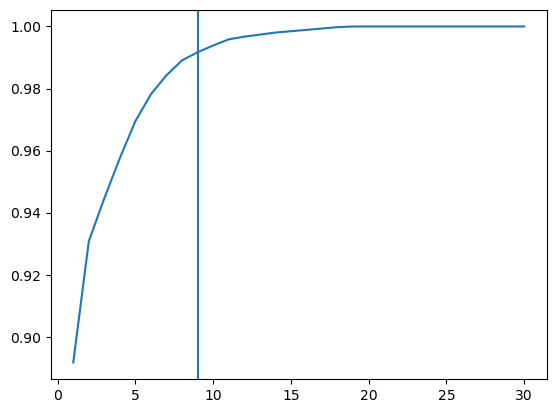

saving...
Estimating Gaussian KLD...
KLD:  743.2570580928801
train_stats:  (array([-4.3744171e-01,  7.4433046e-04,  2.5386631e-04, -4.2300584e-04,
        1.2056663e-03, -1.1084887e-03, -7.5301202e-04, -1.7610047e-04,
        8.4817508e-04], dtype=float32), array([[ 1.30069183e-03, -4.31168877e-04, -8.92592649e-05,
        -3.51029923e-04, -3.03782524e-04, -2.18350705e-05,
         1.09422052e-05, -1.17634734e-04,  1.05940815e-06],
       [-4.31168877e-04,  2.82373131e-02, -6.94186845e-06,
         1.52895100e-05, -2.93805573e-05,  3.60588332e-05,
         1.74677828e-05,  4.71706680e-06, -4.32520378e-05],
       [-8.92592649e-05, -6.94186845e-06,  9.95836642e-03,
         6.89314834e-05, -3.21311846e-05,  2.36601522e-05,
         8.27692974e-06,  2.17568806e-06, -1.45174954e-05],
       [-3.51029923e-04,  1.52895100e-05,  6.89314834e-05,
         8.90331975e-03, -1.23181395e-04,  2.33252312e-05,
         7.72924557e-06,  1.33888849e-06, -1.68333860e-05],
       [-3.03782524e-04, -2.93

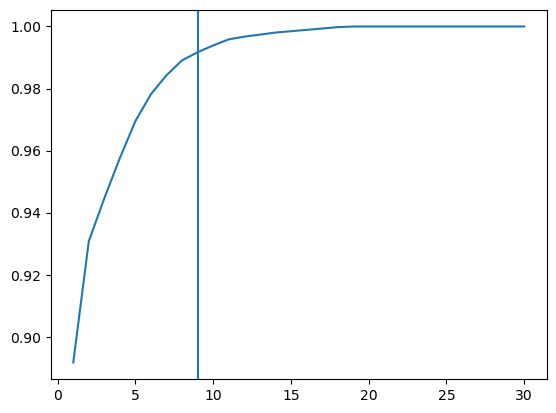

saving...
Estimating Gaussian KLD...
KLD:  743.2570553811433
train_stats:  (array([-4.3744165e-01,  7.4432266e-04,  2.5386605e-04, -4.2299187e-04,
        1.2056752e-03, -1.1084859e-03, -7.5301202e-04, -1.7610067e-04,
        8.4817398e-04], dtype=float32), array([[ 1.30069115e-03, -4.31172152e-04, -8.92549348e-05,
        -3.51033752e-04, -3.03780704e-04, -2.18354609e-05,
         1.09413584e-05, -1.17635026e-04,  1.05855379e-06],
       [-4.31172152e-04,  2.82373076e-02, -6.94137074e-06,
         1.52894244e-05, -2.93810201e-05,  3.60587668e-05,
         1.74679144e-05,  4.71709687e-06, -4.32518295e-05],
       [-8.92549348e-05, -6.94137074e-06,  9.95836551e-03,
         6.89307742e-05, -3.21308337e-05,  2.36603682e-05,
         8.27689328e-06,  2.17622441e-06, -1.45179717e-05],
       [-3.51033752e-04,  1.52894244e-05,  6.89307742e-05,
         8.90331904e-03, -1.23176031e-04,  2.33243508e-05,
         7.72738335e-06,  1.33971947e-06, -1.68340949e-05],
       [-3.03780704e-04, -2.93

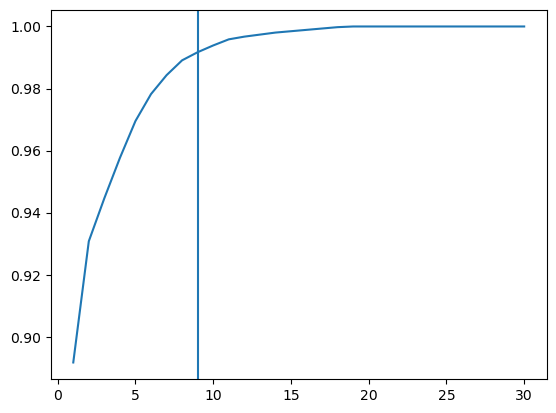

saving...
Estimating Gaussian KLD...
KLD:  743.2573264922065
train_stats:  (array([-4.3744165e-01,  7.4431149e-04,  2.5386541e-04, -4.2299481e-04,
        1.2056736e-03, -1.1084889e-03, -7.5300946e-04, -1.7609887e-04,
        8.4817654e-04], dtype=float32), array([[ 1.30069076e-03, -4.31170582e-04, -8.92555110e-05,
        -3.51031235e-04, -3.03781471e-04, -2.18359259e-05,
         1.09418820e-05, -1.17634653e-04,  1.05952456e-06],
       [-4.31170582e-04,  2.82373208e-02, -6.94196451e-06,
         1.52894887e-05, -2.93805897e-05,  3.60588117e-05,
         1.74677549e-05,  4.71702945e-06, -4.32520519e-05],
       [-8.92555110e-05, -6.94196451e-06,  9.95834510e-03,
         6.89301852e-05, -3.21275978e-05,  2.36613081e-05,
         8.27718820e-06,  2.17564926e-06, -1.45175075e-05],
       [-3.51031235e-04,  1.52894887e-05,  6.89301852e-05,
         8.90330949e-03, -1.23177732e-04,  2.33241265e-05,
         7.72758617e-06,  1.34110087e-06, -1.68336347e-05],
       [-3.03781471e-04, -2.93

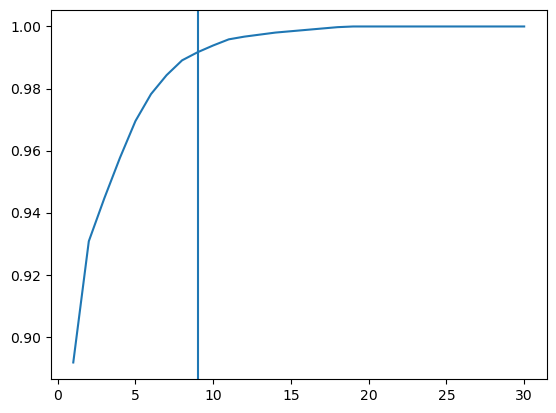

saving...
Estimating Gaussian KLD...
KLD:  743.25776621006
train_stats:  (array([-4.3744159e-01,  7.4431341e-04,  2.5386768e-04, -4.2299824e-04,
        1.2056712e-03, -1.1084883e-03, -7.5301185e-04, -1.7610163e-04,
        8.4817538e-04], dtype=float32), array([[ 1.30069076e-03, -4.31178607e-04, -8.92596896e-05,
        -3.51031678e-04, -3.03783073e-04, -2.18348723e-05,
         1.09422744e-05, -1.17635003e-04,  1.05914026e-06],
       [-4.31178607e-04,  2.82373603e-02, -6.94153640e-06,
         1.52895225e-05, -2.93806774e-05,  3.60589122e-05,
         1.74678298e-05,  4.71711864e-06, -4.32521884e-05],
       [-8.92596896e-05, -6.94153640e-06,  9.95838015e-03,
         6.89260653e-05, -3.21306328e-05,  2.36612735e-05,
         8.27730800e-06,  2.17585917e-06, -1.45174777e-05],
       [-3.51031678e-04,  1.52895225e-05,  6.89260653e-05,
         8.90333028e-03, -1.23180288e-04,  2.33248834e-05,
         7.72733580e-06,  1.33942161e-06, -1.68338349e-05],
       [-3.03783073e-04, -2.9380

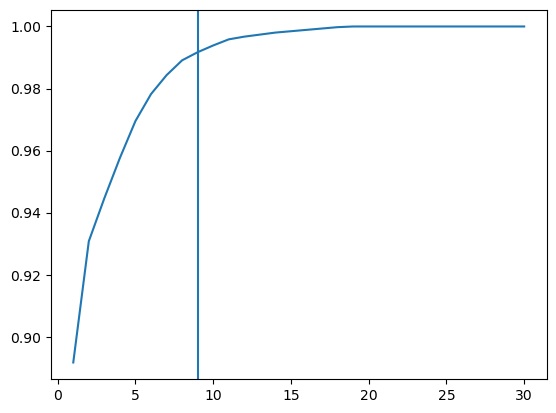

saving...
Estimating Gaussian KLD...
KLD:  743.2569706709417
train_stats:  (array([-4.3744168e-01,  7.4433256e-04,  2.5386579e-04, -4.2299894e-04,
        1.2056698e-03, -1.1084868e-03, -7.5301190e-04, -1.7610061e-04,
        8.4817293e-04], dtype=float32), array([[ 1.30069118e-03, -4.31158982e-04, -8.92588198e-05,
        -3.51030041e-04, -3.03782924e-04, -2.18354555e-05,
         1.09416417e-05, -1.17634924e-04,  1.05857383e-06],
       [-4.31158982e-04,  2.82373135e-02, -6.94154463e-06,
         1.52896979e-05, -2.93805981e-05,  3.60588007e-05,
         1.74678139e-05,  4.71708021e-06, -4.32518396e-05],
       [-8.92588198e-05, -6.94154463e-06,  9.95836059e-03,
         6.89264140e-05, -3.21295434e-05,  2.36604744e-05,
         8.27816175e-06,  2.17545458e-06, -1.45173790e-05],
       [-3.51030041e-04,  1.52896979e-05,  6.89264140e-05,
         8.90332756e-03, -1.23178983e-04,  2.33268658e-05,
         7.72779531e-06,  1.33880862e-06, -1.68340220e-05],
       [-3.03782924e-04, -2.93

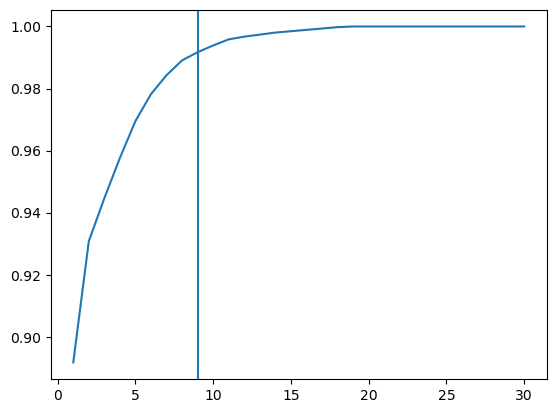

saving...
Estimating Gaussian KLD...
KLD:  743.2574212567074
train_stats:  (array([-4.3744165e-01,  7.4432162e-04,  2.5386680e-04, -4.2299778e-04,
        1.2056691e-03, -1.1084867e-03, -7.5301295e-04, -1.7610083e-04,
        8.4817328e-04], dtype=float32), array([[ 1.30069040e-03, -4.31163401e-04, -8.92553862e-05,
        -3.51030893e-04, -3.03781432e-04, -2.18349574e-05,
         1.09419171e-05, -1.17634737e-04,  1.05808340e-06],
       [-4.31163401e-04,  2.82373057e-02, -6.94162884e-06,
         1.52894223e-05, -2.93806525e-05,  3.60588652e-05,
         1.74678154e-05,  4.71709276e-06, -4.32519970e-05],
       [-8.92553862e-05, -6.94162884e-06,  9.95836544e-03,
         6.89275739e-05, -3.21303218e-05,  2.36618332e-05,
         8.27797421e-06,  2.17545087e-06, -1.45163998e-05],
       [-3.51030893e-04,  1.52894223e-05,  6.89275739e-05,
         8.90331972e-03, -1.23180002e-04,  2.33247522e-05,
         7.72725584e-06,  1.33899238e-06, -1.68336118e-05],
       [-3.03781432e-04, -2.93

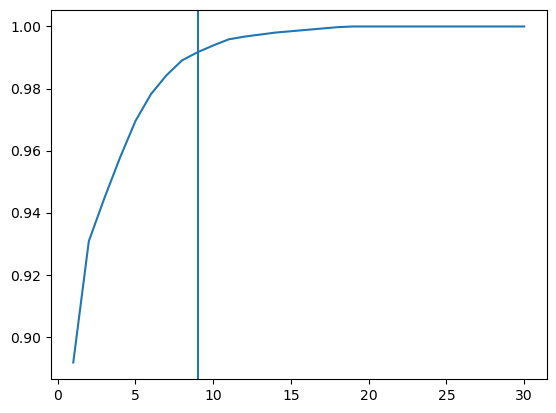

saving...
Estimating Gaussian KLD...
KLD:  743.257102020341
train_stats:  (array([-4.3744162e-01,  7.4432022e-04,  2.5386529e-04, -4.2299382e-04,
        1.2056684e-03, -1.1084882e-03, -7.5301167e-04, -1.7610124e-04,
        8.4817549e-04], dtype=float32), array([[ 1.30069056e-03, -4.31172930e-04, -8.92554076e-05,
        -3.51031329e-04, -3.03781747e-04, -2.18361785e-05,
         1.09414171e-05, -1.17635146e-04,  1.05897193e-06],
       [-4.31172930e-04,  2.82372808e-02, -6.94168534e-06,
         1.52892377e-05, -2.93807515e-05,  3.60588447e-05,
         1.74678024e-05,  4.71711943e-06, -4.32518557e-05],
       [-8.92554076e-05, -6.94168534e-06,  9.95835679e-03,
         6.89291931e-05, -3.21310402e-05,  2.36608532e-05,
         8.27795021e-06,  2.17587043e-06, -1.45172938e-05],
       [-3.51031329e-04,  1.52892377e-05,  6.89291931e-05,
         8.90331508e-03, -1.23176709e-04,  2.33264859e-05,
         7.72890459e-06,  1.33878230e-06, -1.68341067e-05],
       [-3.03781747e-04, -2.938

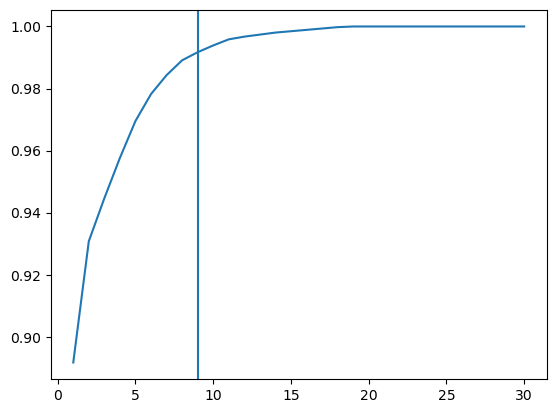

saving...
Estimating Gaussian KLD...
KLD:  743.2568362305918
train_stats:  (array([-4.3744171e-01,  7.4431521e-04,  2.5386433e-04, -4.2299516e-04,
        1.2056642e-03, -1.1084877e-03, -7.5301190e-04, -1.7610278e-04,
        8.4817392e-04], dtype=float32), array([[ 1.30069260e-03, -4.31176602e-04, -8.92560518e-05,
        -3.51031314e-04, -3.03781782e-04, -2.18355367e-05,
         1.09425219e-05, -1.17634497e-04,  1.05922902e-06],
       [-4.31176602e-04,  2.82373079e-02, -6.94213625e-06,
         1.52896886e-05, -2.93805270e-05,  3.60588902e-05,
         1.74678299e-05,  4.71716597e-06, -4.32518978e-05],
       [-8.92560518e-05, -6.94213625e-06,  9.95835835e-03,
         6.89268573e-05, -3.21293781e-05,  2.36615450e-05,
         8.27769773e-06,  2.17533647e-06, -1.45173141e-05],
       [-3.51031314e-04,  1.52896886e-05,  6.89268573e-05,
         8.90330476e-03, -1.23181029e-04,  2.33265625e-05,
         7.72871012e-06,  1.33924411e-06, -1.68334838e-05],
       [-3.03781782e-04, -2.93

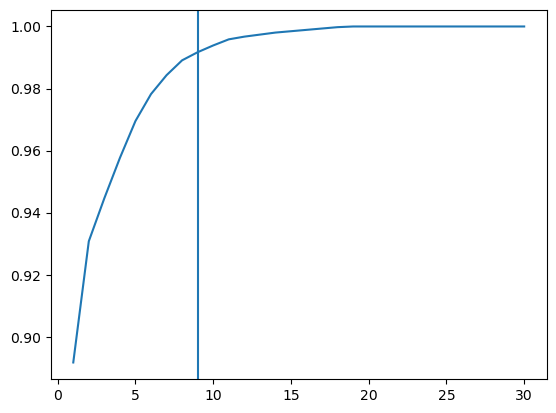

saving...
Estimating Gaussian KLD...
KLD:  743.2571824317818
train_stats:  (array([-4.3744165e-01,  7.4432150e-04,  2.5386389e-04, -4.2300113e-04,
        1.2056660e-03, -1.1084862e-03, -7.5301301e-04, -1.7610064e-04,
        8.4817398e-04], dtype=float32), array([[ 1.30069088e-03, -4.31170925e-04, -8.92571280e-05,
        -3.51029566e-04, -3.03783681e-04, -2.18357766e-05,
         1.09418992e-05, -1.17635194e-04,  1.05856368e-06],
       [-4.31170925e-04,  2.82373462e-02, -6.94227412e-06,
         1.52893917e-05, -2.93804573e-05,  3.60588885e-05,
         1.74678638e-05,  4.71704568e-06, -4.32519463e-05],
       [-8.92571280e-05, -6.94227412e-06,  9.95838728e-03,
         6.89281952e-05, -3.21317260e-05,  2.36609652e-05,
         8.27761306e-06,  2.17576312e-06, -1.45177091e-05],
       [-3.51029566e-04,  1.52893917e-05,  6.89281952e-05,
         8.90331317e-03, -1.23183359e-04,  2.33280583e-05,
         7.72728760e-06,  1.33859350e-06, -1.68333020e-05],
       [-3.03783681e-04, -2.93

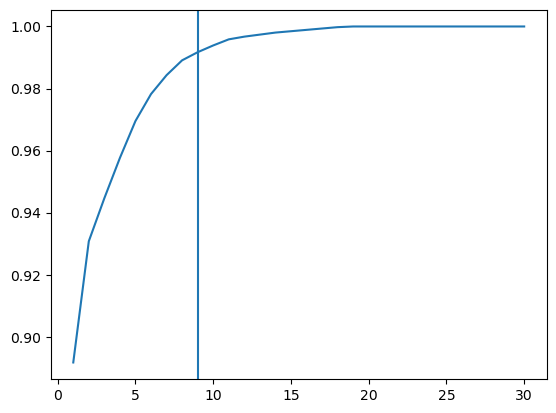

saving...
Estimating Gaussian KLD...
KLD:  743.2571342748764
train_stats:  (array([-4.3744171e-01,  7.4432226e-04,  2.5386171e-04, -4.2299915e-04,
        1.2056654e-03, -1.1084870e-03, -7.5301278e-04, -1.7610015e-04,
        8.4817427e-04], dtype=float32), array([[ 1.30069224e-03, -4.31179223e-04, -8.92569142e-05,
        -3.51030044e-04, -3.03784466e-04, -2.18359268e-05,
         1.09419710e-05, -1.17635254e-04,  1.05974562e-06],
       [-4.31179223e-04,  2.82372991e-02, -6.94165079e-06,
         1.52894029e-05, -2.93810762e-05,  3.60587935e-05,
         1.74678079e-05,  4.71706626e-06, -4.32519725e-05],
       [-8.92569142e-05, -6.94165079e-06,  9.95836891e-03,
         6.89286454e-05, -3.21311412e-05,  2.36609492e-05,
         8.27780415e-06,  2.17563719e-06, -1.45177701e-05],
       [-3.51030044e-04,  1.52894029e-05,  6.89286454e-05,
         8.90332775e-03, -1.23182235e-04,  2.33253520e-05,
         7.72748941e-06,  1.33995805e-06, -1.68325622e-05],
       [-3.03784466e-04, -2.93

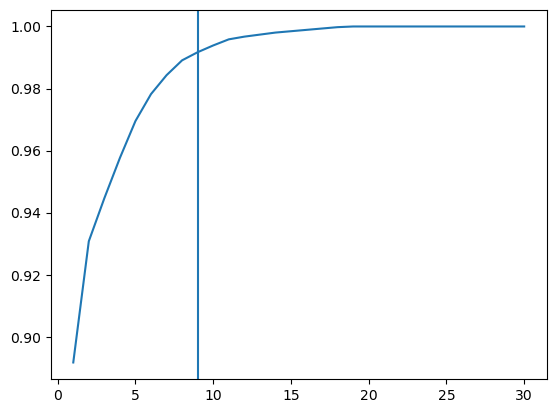

saving...
Estimating Gaussian KLD...
KLD:  743.2572119787112
train_stats:  (array([-4.3744165e-01,  7.4431725e-04,  2.5386515e-04, -4.2300450e-04,
        1.2056680e-03, -1.1084890e-03, -7.5301202e-04, -1.7610162e-04,
        8.4817369e-04], dtype=float32), array([[ 1.30069100e-03, -4.31178535e-04, -8.92569354e-05,
        -3.51029512e-04, -3.03783837e-04, -2.18360708e-05,
         1.09420256e-05, -1.17635034e-04,  1.05846496e-06],
       [-4.31178535e-04,  2.82373095e-02, -6.94171353e-06,
         1.52895120e-05, -2.93807246e-05,  3.60588355e-05,
         1.74678387e-05,  4.71710907e-06, -4.32519339e-05],
       [-8.92569354e-05, -6.94171353e-06,  9.95837433e-03,
         6.89300275e-05, -3.21306684e-05,  2.36609036e-05,
         8.27743977e-06,  2.17548715e-06, -1.45168306e-05],
       [-3.51029512e-04,  1.52895120e-05,  6.89300275e-05,
         8.90331925e-03, -1.23182730e-04,  2.33243294e-05,
         7.72789621e-06,  1.33925042e-06, -1.68333216e-05],
       [-3.03783837e-04, -2.93

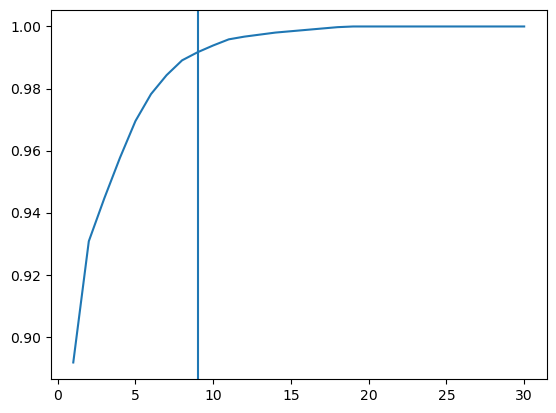

saving...
Estimating Gaussian KLD...
KLD:  743.2571813914093
train_stats:  (array([-4.3744165e-01,  7.4431929e-04,  2.5386320e-04, -4.2299670e-04,
        1.2056731e-03, -1.1084867e-03, -7.5301301e-04, -1.7610095e-04,
        8.4817316e-04], dtype=float32), array([[ 1.30069090e-03, -4.31172961e-04, -8.92564374e-05,
        -3.51030089e-04, -3.03781517e-04, -2.18350937e-05,
         1.09421571e-05, -1.17634661e-04,  1.05887829e-06],
       [-4.31172961e-04,  2.82372602e-02, -6.94163180e-06,
         1.52889278e-05, -2.93808402e-05,  3.60588381e-05,
         1.74677336e-05,  4.71712279e-06, -4.32517448e-05],
       [-8.92564374e-05, -6.94163180e-06,  9.95835310e-03,
         6.89287950e-05, -3.21334265e-05,  2.36597618e-05,
         8.27783782e-06,  2.17532200e-06, -1.45171362e-05],
       [-3.51030089e-04,  1.52889278e-05,  6.89287950e-05,
         8.90333438e-03, -1.23180242e-04,  2.33266233e-05,
         7.72809644e-06,  1.33854428e-06, -1.68337369e-05],
       [-3.03781517e-04, -2.93

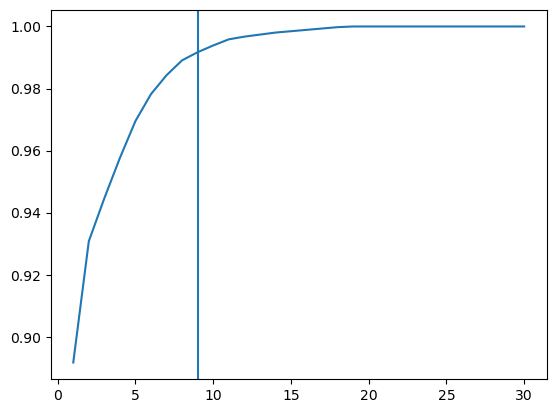

saving...
Estimating Gaussian KLD...
KLD:  743.2570950503366
train_stats:  (array([-4.3744165e-01,  7.4432784e-04,  2.5386366e-04, -4.2299851e-04,
        1.2056705e-03, -1.1084887e-03, -7.5301301e-04, -1.7610104e-04,
        8.4817625e-04], dtype=float32), array([[ 1.30069129e-03, -4.31158128e-04, -8.92599046e-05,
        -3.51030674e-04, -3.03782811e-04, -2.18356918e-05,
         1.09421753e-05, -1.17634823e-04,  1.05894574e-06],
       [-4.31158128e-04,  2.82373052e-02, -6.94157626e-06,
         1.52892877e-05, -2.93806620e-05,  3.60589268e-05,
         1.74678310e-05,  4.71711727e-06, -4.32521164e-05],
       [-8.92599046e-05, -6.94157626e-06,  9.95837020e-03,
         6.89250989e-05, -3.21315254e-05,  2.36603664e-05,
         8.27802084e-06,  2.17592870e-06, -1.45183793e-05],
       [-3.51030674e-04,  1.52892877e-05,  6.89250989e-05,
         8.90331420e-03, -1.23184630e-04,  2.33258659e-05,
         7.72780449e-06,  1.33937604e-06, -1.68333511e-05],
       [-3.03782811e-04, -2.93

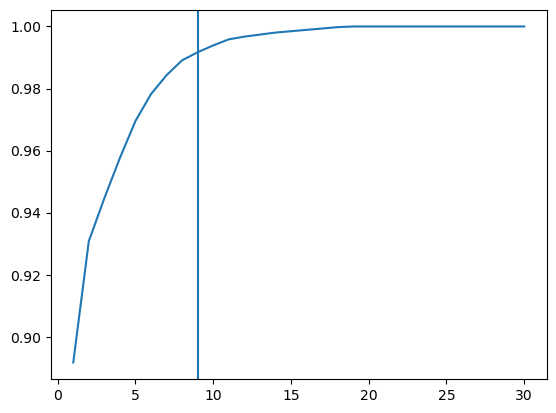

saving...
Estimating Gaussian KLD...
KLD:  743.2571314195311
train_stats:  (array([-4.3744168e-01,  7.4431754e-04,  2.5387196e-04, -4.2299420e-04,
        1.2056696e-03, -1.1084860e-03, -7.5301237e-04, -1.7610134e-04,
        8.4817404e-04], dtype=float32), array([[ 1.30069160e-03, -4.31175832e-04, -8.92536886e-05,
        -3.51031619e-04, -3.03781746e-04, -2.18357801e-05,
         1.09419605e-05, -1.17634307e-04,  1.05892927e-06],
       [-4.31175832e-04,  2.82373120e-02, -6.94207134e-06,
         1.52892469e-05, -2.93806479e-05,  3.60588949e-05,
         1.74678205e-05,  4.71710607e-06, -4.32519602e-05],
       [-8.92536886e-05, -6.94207134e-06,  9.95837631e-03,
         6.89315178e-05, -3.21277260e-05,  2.36614670e-05,
         8.27753856e-06,  2.17603299e-06, -1.45172277e-05],
       [-3.51031619e-04,  1.52892469e-05,  6.89315178e-05,
         8.90331933e-03, -1.23178401e-04,  2.33266025e-05,
         7.72819530e-06,  1.33981554e-06, -1.68330713e-05],
       [-3.03781746e-04, -2.93

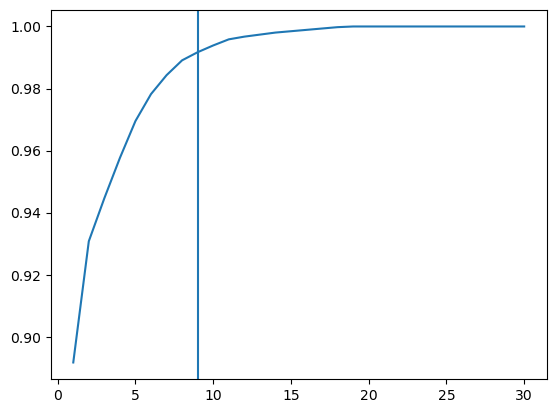

saving...
Estimating Gaussian KLD...
KLD:  743.257273261456
train_stats:  (array([-4.3744171e-01,  7.4431923e-04,  2.5386605e-04, -4.2299580e-04,
        1.2056761e-03, -1.1084889e-03, -7.5301150e-04, -1.7610067e-04,
        8.4817625e-04], dtype=float32), array([[ 1.30069201e-03, -4.31185503e-04, -8.92560734e-05,
        -3.51030727e-04, -3.03782556e-04, -2.18356533e-05,
         1.09419866e-05, -1.17634613e-04,  1.05920815e-06],
       [-4.31185503e-04,  2.82373151e-02, -6.94120138e-06,
         1.52893712e-05, -2.93807962e-05,  3.60588611e-05,
         1.74678113e-05,  4.71708700e-06, -4.32521146e-05],
       [-8.92560734e-05, -6.94120138e-06,  9.95836041e-03,
         6.89284465e-05, -3.21282372e-05,  2.36613469e-05,
         8.27724368e-06,  2.17573854e-06, -1.45173790e-05],
       [-3.51030727e-04,  1.52893712e-05,  6.89284465e-05,
         8.90332461e-03, -1.23180479e-04,  2.33252348e-05,
         7.72797383e-06,  1.33959143e-06, -1.68335232e-05],
       [-3.03782556e-04, -2.938

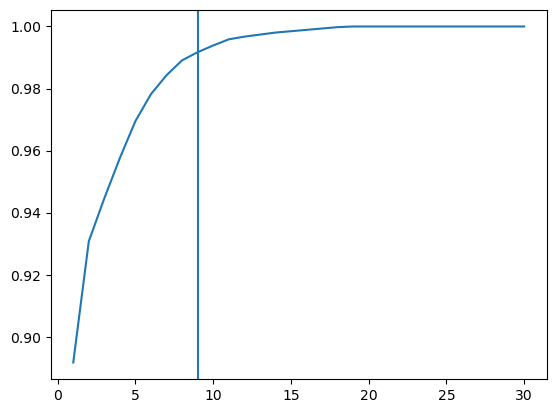

saving...
Estimating Gaussian KLD...
KLD:  743.2573723041996
train_stats:  (array([-4.3744165e-01,  7.4431632e-04,  2.5386523e-04, -4.2299822e-04,
        1.2056697e-03, -1.1084871e-03, -7.5301278e-04, -1.7610112e-04,
        8.4817759e-04], dtype=float32), array([[ 1.30069072e-03, -4.31174494e-04, -8.92555614e-05,
        -3.51030015e-04, -3.03782114e-04, -2.18342789e-05,
         1.09418462e-05, -1.17634924e-04,  1.05974836e-06],
       [-4.31174494e-04,  2.82372847e-02, -6.94169888e-06,
         1.52894584e-05, -2.93806458e-05,  3.60588042e-05,
         1.74678190e-05,  4.71710063e-06, -4.32520408e-05],
       [-8.92555614e-05, -6.94169888e-06,  9.95836855e-03,
         6.89309257e-05, -3.21346909e-05,  2.36598958e-05,
         8.27755501e-06,  2.17598937e-06, -1.45173200e-05],
       [-3.51030015e-04,  1.52894584e-05,  6.89309257e-05,
         8.90331834e-03, -1.23186237e-04,  2.33270818e-05,
         7.72773450e-06,  1.33879978e-06, -1.68324216e-05],
       [-3.03782114e-04, -2.93

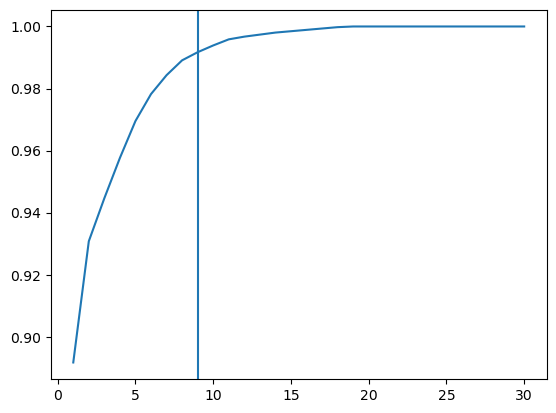

saving...
Estimating Gaussian KLD...
KLD:  743.2572535289396
train_stats:  (array([-4.3744171e-01,  7.4431935e-04,  2.5387082e-04, -4.2300500e-04,
        1.2056645e-03, -1.1084878e-03, -7.5301237e-04, -1.7610029e-04,
        8.4817607e-04], dtype=float32), array([[ 1.30069162e-03, -4.31173513e-04, -8.92578121e-05,
        -3.51028198e-04, -3.03783883e-04, -2.18353542e-05,
         1.09421102e-05, -1.17635322e-04,  1.05977519e-06],
       [-4.31173513e-04,  2.82373394e-02, -6.94043170e-06,
         1.52892993e-05, -2.93801897e-05,  3.60589662e-05,
         1.74679577e-05,  4.71681947e-06, -4.32517589e-05],
       [-8.92578121e-05, -6.94043170e-06,  9.95838353e-03,
         6.89279490e-05, -3.21291090e-05,  2.36614434e-05,
         8.27731501e-06,  2.17626046e-06, -1.45176192e-05],
       [-3.51028198e-04,  1.52892993e-05,  6.89279490e-05,
         8.90330169e-03, -1.23186296e-04,  2.33250481e-05,
         7.72741472e-06,  1.33930412e-06, -1.68338101e-05],
       [-3.03783883e-04, -2.93

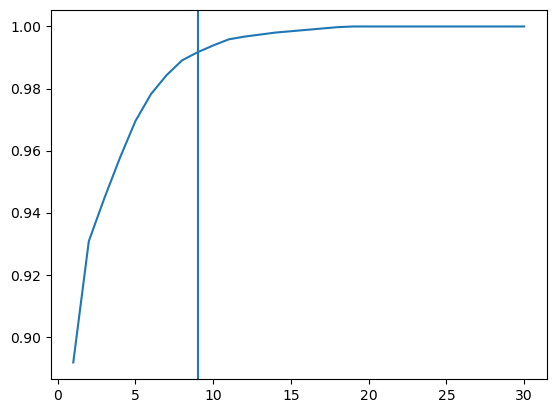

saving...
Estimating Gaussian KLD...
KLD:  743.2566121599266
train_stats:  (array([-4.3744171e-01,  7.4432313e-04,  2.5386561e-04, -4.2300153e-04,
        1.2056677e-03, -1.1084891e-03, -7.5301243e-04, -1.7609962e-04,
        8.4817287e-04], dtype=float32), array([[ 1.30069197e-03, -4.31175090e-04, -8.92591143e-05,
        -3.51030309e-04, -3.03782352e-04, -2.18346957e-05,
         1.09418592e-05, -1.17634371e-04,  1.05863670e-06],
       [-4.31175090e-04,  2.82373410e-02, -6.93975366e-06,
         1.52898440e-05, -2.93788286e-05,  3.60586747e-05,
         1.74677356e-05,  4.71730366e-06, -4.32517749e-05],
       [-8.92591143e-05, -6.93975366e-06,  9.95839419e-03,
         6.89286163e-05, -3.21308636e-05,  2.36610987e-05,
         8.27747480e-06,  2.17608796e-06, -1.45175416e-05],
       [-3.51030309e-04,  1.52898440e-05,  6.89286163e-05,
         8.90331301e-03, -1.23178327e-04,  2.33267504e-05,
         7.72692064e-06,  1.33857584e-06, -1.68328719e-05],
       [-3.03782352e-04, -2.93

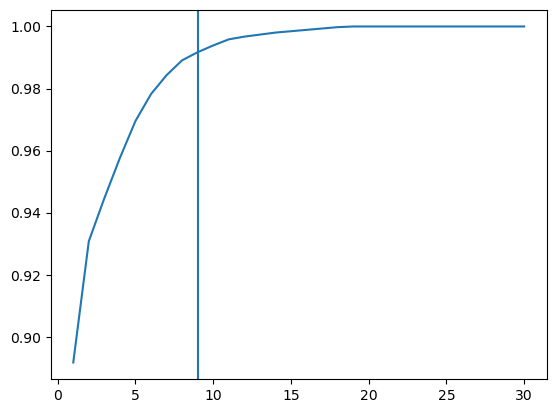

saving...
Estimating Gaussian KLD...
KLD:  743.2573233090963
train_stats:  (array([-4.3744171e-01,  7.4432278e-04,  2.5386811e-04, -4.2300203e-04,
        1.2056680e-03, -1.1084888e-03, -7.5301167e-04, -1.7610112e-04,
        8.4817514e-04], dtype=float32), array([[ 1.30069157e-03, -4.31172247e-04, -8.92524684e-05,
        -3.51029966e-04, -3.03783839e-04, -2.18353168e-05,
         1.09424177e-05, -1.17635038e-04,  1.05930033e-06],
       [-4.31172247e-04,  2.82372924e-02, -6.94161110e-06,
         1.52890377e-05, -2.93804132e-05,  3.60588538e-05,
         1.74678522e-05,  4.71710955e-06, -4.32520114e-05],
       [-8.92524684e-05, -6.94161110e-06,  9.95835796e-03,
         6.89369292e-05, -3.21281487e-05,  2.36614205e-05,
         8.27891206e-06,  2.17544468e-06, -1.45163550e-05],
       [-3.51029966e-04,  1.52890377e-05,  6.89369292e-05,
         8.90330570e-03, -1.23184217e-04,  2.33259503e-05,
         7.72834456e-06,  1.33950200e-06, -1.68333848e-05],
       [-3.03783839e-04, -2.93

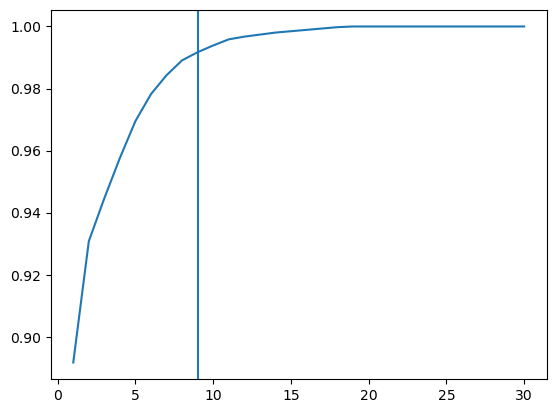

saving...
Estimating Gaussian KLD...
KLD:  743.2569871384574
train_stats:  (array([-4.3744165e-01,  7.4431789e-04,  2.5386710e-04, -4.2300310e-04,
        1.2056645e-03, -1.1084870e-03, -7.5301295e-04, -1.7610115e-04,
        8.4817392e-04], dtype=float32), array([[ 1.30069079e-03, -4.31175916e-04, -8.92579461e-05,
        -3.51029508e-04, -3.03783959e-04, -2.18355377e-05,
         1.09425409e-05, -1.17634942e-04,  1.05890472e-06],
       [-4.31175916e-04,  2.82373253e-02, -6.94178916e-06,
         1.52898378e-05, -2.93806253e-05,  3.60588916e-05,
         1.74678022e-05,  4.71708932e-06, -4.32517507e-05],
       [-8.92579461e-05, -6.94178916e-06,  9.95836716e-03,
         6.89276010e-05, -3.21269999e-05,  2.36620871e-05,
         8.27736370e-06,  2.17578625e-06, -1.45177261e-05],
       [-3.51029508e-04,  1.52898378e-05,  6.89276010e-05,
         8.90330725e-03, -1.23187181e-04,  2.33251760e-05,
         7.72806595e-06,  1.33907691e-06, -1.68326765e-05],
       [-3.03783959e-04, -2.93

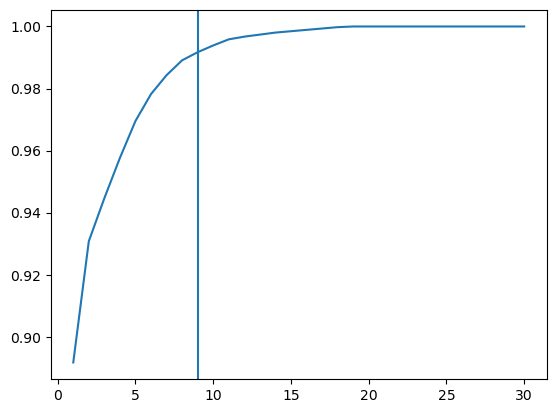

saving...
Estimating Gaussian KLD...
KLD:  743.2570951645491
train_stats:  (array([-4.3744171e-01,  7.4433419e-04,  2.5386532e-04, -4.2299798e-04,
        1.2056716e-03, -1.1084852e-03, -7.5301237e-04, -1.7610005e-04,
        8.4817479e-04], dtype=float32), array([[ 1.30069122e-03, -4.31157994e-04, -8.92564042e-05,
        -3.51030516e-04, -3.03782871e-04, -2.18352295e-05,
         1.09415708e-05, -1.17634739e-04,  1.05820873e-06],
       [-4.31157994e-04,  2.82373061e-02, -6.94178586e-06,
         1.52896490e-05, -2.93806504e-05,  3.60587716e-05,
         1.74677853e-05,  4.71709019e-06, -4.32520515e-05],
       [-8.92564042e-05, -6.94178586e-06,  9.95837482e-03,
         6.89285886e-05, -3.21303320e-05,  2.36638980e-05,
         8.27759722e-06,  2.17613236e-06, -1.45189239e-05],
       [-3.51030516e-04,  1.52896490e-05,  6.89285886e-05,
         8.90330787e-03, -1.23180443e-04,  2.33253834e-05,
         7.72737011e-06,  1.33939598e-06, -1.68338644e-05],
       [-3.03782871e-04, -2.93

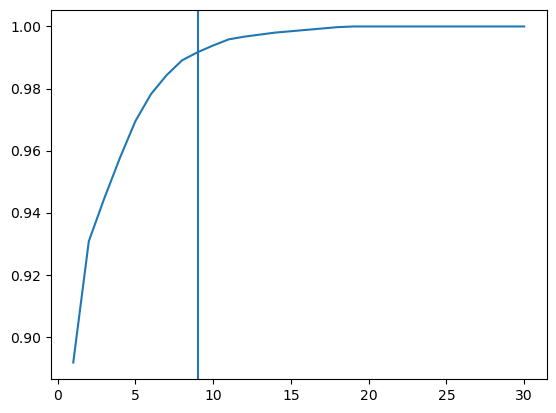

saving...
Estimating Gaussian KLD...
KLD:  743.257067034982
train_stats:  (array([-4.3744171e-01,  7.4431882e-04,  2.5386989e-04, -4.2300121e-04,
        1.2056674e-03, -1.1084887e-03, -7.5301109e-04, -1.7610083e-04,
        8.4817543e-04], dtype=float32), array([[ 1.30069167e-03, -4.31171330e-04, -8.92540709e-05,
        -3.51030226e-04, -3.03783718e-04, -2.18353815e-05,
         1.09421241e-05, -1.17635015e-04,  1.05933408e-06],
       [-4.31171330e-04,  2.82373081e-02, -6.94203286e-06,
         1.52895896e-05, -2.93805414e-05,  3.60588375e-05,
         1.74677795e-05,  4.71708001e-06, -4.32519285e-05],
       [-8.92540709e-05, -6.94203286e-06,  9.95837018e-03,
         6.89323745e-05, -3.21285678e-05,  2.36631175e-05,
         8.27763835e-06,  2.17562926e-06, -1.45166696e-05],
       [-3.51030226e-04,  1.52895896e-05,  6.89323745e-05,
         8.90331769e-03, -1.23182713e-04,  2.33249619e-05,
         7.72695025e-06,  1.33971651e-06, -1.68341875e-05],
       [-3.03783718e-04, -2.938

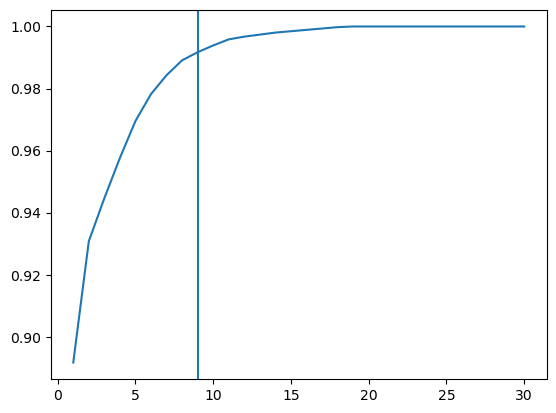

saving...
Estimating Gaussian KLD...
KLD:  743.257211221526
train_stats:  (array([-4.3744171e-01,  7.4431358e-04,  2.5386535e-04, -4.2299568e-04,
        1.2056699e-03, -1.1084880e-03, -7.5301126e-04, -1.7610281e-04,
        8.4817584e-04], dtype=float32), array([[ 1.30069196e-03, -4.31179691e-04, -8.92577041e-05,
        -3.51030128e-04, -3.03780717e-04, -2.18353868e-05,
         1.09420759e-05, -1.17635133e-04,  1.05954060e-06],
       [-4.31179691e-04,  2.82373144e-02, -6.94178905e-06,
         1.52892079e-05, -2.93803345e-05,  3.60588501e-05,
         1.74677844e-05,  4.71717096e-06, -4.32520901e-05],
       [-8.92577041e-05, -6.94178905e-06,  9.95836296e-03,
         6.89276477e-05, -3.21298234e-05,  2.36608847e-05,
         8.27768521e-06,  2.17624776e-06, -1.45178335e-05],
       [-3.51030128e-04,  1.52892079e-05,  6.89276477e-05,
         8.90329958e-03, -1.23175360e-04,  2.33258047e-05,
         7.72765880e-06,  1.34065520e-06, -1.68351113e-05],
       [-3.03780717e-04, -2.938

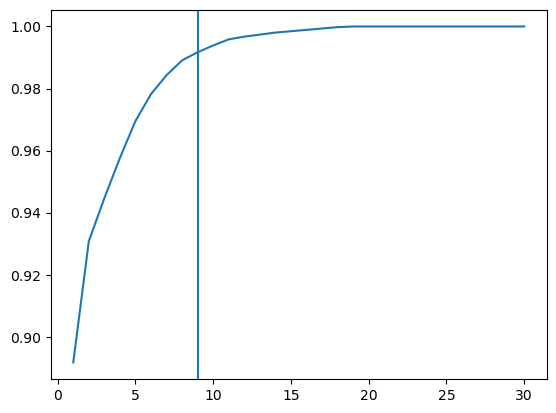

saving...
Estimating Gaussian KLD...
KLD:  743.2574062819403
train_stats:  (array([-4.3744165e-01,  7.4432261e-04,  2.5386416e-04, -4.2300040e-04,
        1.2056679e-03, -1.1084871e-03, -7.5300946e-04, -1.7610239e-04,
        8.4817514e-04], dtype=float32), array([[ 1.30069111e-03, -4.31175263e-04, -8.92563938e-05,
        -3.51029720e-04, -3.03782696e-04, -2.18356223e-05,
         1.09424032e-05, -1.17634165e-04,  1.05853197e-06],
       [-4.31175263e-04,  2.82373280e-02, -6.94166815e-06,
         1.52894433e-05, -2.93805533e-05,  3.60588706e-05,
         1.74677525e-05,  4.71714214e-06, -4.32520502e-05],
       [-8.92563938e-05, -6.94166815e-06,  9.95836577e-03,
         6.89298907e-05, -3.21274130e-05,  2.36611747e-05,
         8.27749885e-06,  2.17607352e-06, -1.45176108e-05],
       [-3.51029720e-04,  1.52894433e-05,  6.89298907e-05,
         8.90331711e-03, -1.23181096e-04,  2.33242951e-05,
         7.72766204e-06,  1.33942530e-06, -1.68339864e-05],
       [-3.03782696e-04, -2.93

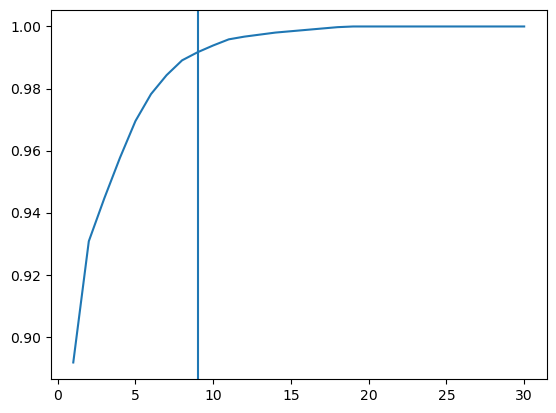

saving...
Estimating Gaussian KLD...
KLD:  743.2573591643238
train_stats:  (array([-4.3744165e-01,  7.4432377e-04,  2.5386285e-04, -4.2299795e-04,
        1.2056697e-03, -1.1084878e-03, -7.5301278e-04, -1.7610144e-04,
        8.4817631e-04], dtype=float32), array([[ 1.30069090e-03, -4.31174261e-04, -8.92578617e-05,
        -3.51029492e-04, -3.03781960e-04, -2.18353453e-05,
         1.09422980e-05, -1.17634612e-04,  1.05939031e-06],
       [-4.31174261e-04,  2.82373042e-02, -6.94212864e-06,
         1.52888778e-05, -2.93805713e-05,  3.60589382e-05,
         1.74678659e-05,  4.71717764e-06, -4.32520379e-05],
       [-8.92578617e-05, -6.94212864e-06,  9.95837834e-03,
         6.89261829e-05, -3.21323945e-05,  2.36613845e-05,
         8.27710020e-06,  2.17518469e-06, -1.45177206e-05],
       [-3.51029492e-04,  1.52888778e-05,  6.89261829e-05,
         8.90332823e-03, -1.23180862e-04,  2.33264998e-05,
         7.72814701e-06,  1.33956320e-06, -1.68336892e-05],
       [-3.03781960e-04, -2.93

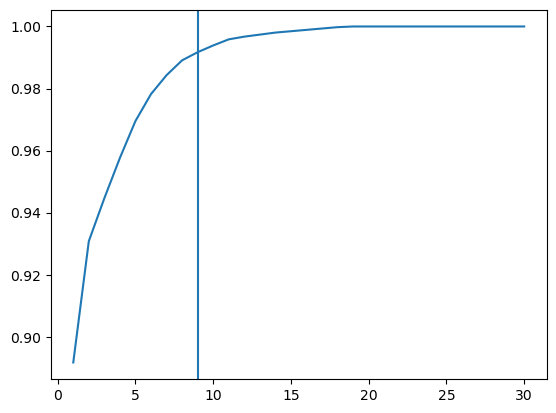

saving...
Estimating Gaussian KLD...
KLD:  743.256896267218
train_stats:  (array([-4.3744171e-01,  7.4431900e-04,  2.5386538e-04, -4.2300014e-04,
        1.2056658e-03, -1.1084860e-03, -7.5301470e-04, -1.7610064e-04,
        8.4817491e-04], dtype=float32), array([[ 1.30069195e-03, -4.31176649e-04, -8.92601825e-05,
        -3.51029781e-04, -3.03782267e-04, -2.18349573e-05,
         1.09416190e-05, -1.17635039e-04,  1.05860256e-06],
       [-4.31176649e-04,  2.82372782e-02, -6.94171989e-06,
         1.52891445e-05, -2.93805517e-05,  3.60587850e-05,
         1.74678494e-05,  4.71706689e-06, -4.32518115e-05],
       [-8.92601825e-05, -6.94171989e-06,  9.95836422e-03,
         6.89251685e-05, -3.21272885e-05,  2.36616635e-05,
         8.27708774e-06,  2.17583123e-06, -1.45173161e-05],
       [-3.51029781e-04,  1.52891445e-05,  6.89251685e-05,
         8.90331957e-03, -1.23178469e-04,  2.33261320e-05,
         7.72825471e-06,  1.33871229e-06, -1.68333700e-05],
       [-3.03782267e-04, -2.938

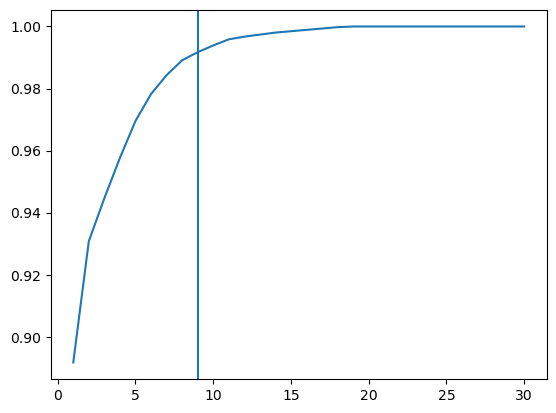

saving...
Estimating Gaussian KLD...
KLD:  743.2572631964117
train_stats:  (array([-4.3744168e-01,  7.4432563e-04,  2.5386745e-04, -4.2299976e-04,
        1.2056682e-03, -1.1084870e-03, -7.5301266e-04, -1.7610157e-04,
        8.4817607e-04], dtype=float32), array([[ 1.30069130e-03, -4.31163909e-04, -8.92573590e-05,
        -3.51032419e-04, -3.03782473e-04, -2.18357411e-05,
         1.09418316e-05, -1.17635313e-04,  1.05919712e-06],
       [-4.31163909e-04,  2.82372594e-02, -6.94188290e-06,
         1.52894434e-05, -2.93805815e-05,  3.60588333e-05,
         1.74677698e-05,  4.71713370e-06, -4.32520580e-05],
       [-8.92573590e-05, -6.94188290e-06,  9.95835535e-03,
         6.89295539e-05, -3.21299609e-05,  2.36618650e-05,
         8.27745561e-06,  2.17574564e-06, -1.45173890e-05],
       [-3.51032419e-04,  1.52894434e-05,  6.89295539e-05,
         8.90332710e-03, -1.23181146e-04,  2.33260011e-05,
         7.72807205e-06,  1.33910836e-06, -1.68335320e-05],
       [-3.03782473e-04, -2.93

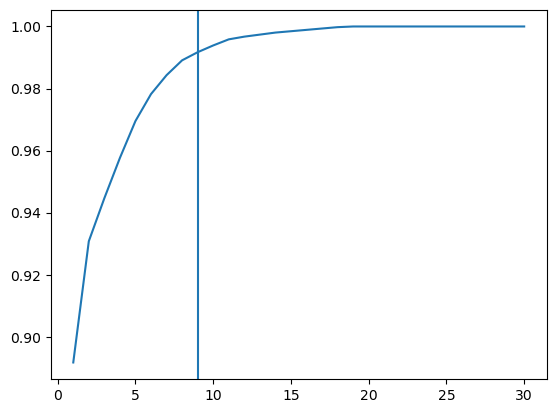

saving...
Estimating Gaussian KLD...
KLD:  743.2574441663493
train_stats:  (array([-4.3744165e-01,  7.4431981e-04,  2.5386966e-04, -4.2299682e-04,
        1.2056673e-03, -1.1084871e-03, -7.5301249e-04, -1.7610095e-04,
        8.4817683e-04], dtype=float32), array([[ 1.30069115e-03, -4.31173744e-04, -8.92530062e-05,
        -3.51031369e-04, -3.03783034e-04, -2.18356452e-05,
         1.09416727e-05, -1.17634824e-04,  1.05913990e-06],
       [-4.31173744e-04,  2.82372804e-02, -6.94429816e-06,
         1.52932897e-05, -2.93805704e-05,  3.60587674e-05,
         1.74677787e-05,  4.71721967e-06, -4.32520604e-05],
       [-8.92530062e-05, -6.94429816e-06,  9.95836719e-03,
         6.89363314e-05, -3.21279482e-05,  2.36605147e-05,
         8.27659432e-06,  2.17608217e-06, -1.45167432e-05],
       [-3.51031369e-04,  1.52932897e-05,  6.89363314e-05,
         8.90332574e-03, -1.23184032e-04,  2.33256913e-05,
         7.72853635e-06,  1.33895786e-06, -1.68340152e-05],
       [-3.03783034e-04, -2.93

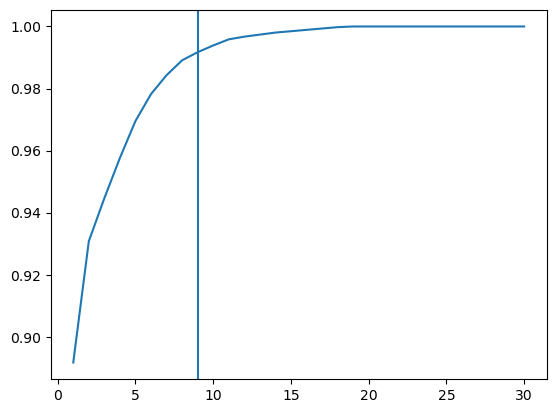

saving...
Estimating Gaussian KLD...
KLD:  743.257269439095
train_stats:  (array([-4.3744165e-01,  7.4431679e-04,  2.5386576e-04, -4.2299685e-04,
        1.2056699e-03, -1.1084874e-03, -7.5301190e-04, -1.7609980e-04,
        8.4817701e-04], dtype=float32), array([[ 1.30069206e-03, -4.31181181e-04, -8.92565504e-05,
        -3.51029764e-04, -3.03782255e-04, -2.18351576e-05,
         1.09419294e-05, -1.17634517e-04,  1.05903685e-06],
       [-4.31181181e-04,  2.82373015e-02, -6.94199819e-06,
         1.52893841e-05, -2.93809199e-05,  3.60587636e-05,
         1.74678495e-05,  4.71710671e-06, -4.32521584e-05],
       [-8.92565504e-05, -6.94199819e-06,  9.95836164e-03,
         6.89282724e-05, -3.21296961e-05,  2.36619666e-05,
         8.27750829e-06,  2.17561072e-06, -1.45175336e-05],
       [-3.51029764e-04,  1.52893841e-05,  6.89282724e-05,
         8.90331196e-03, -1.23176071e-04,  2.33262203e-05,
         7.72683660e-06,  1.33842829e-06, -1.68334582e-05],
       [-3.03782255e-04, -2.938

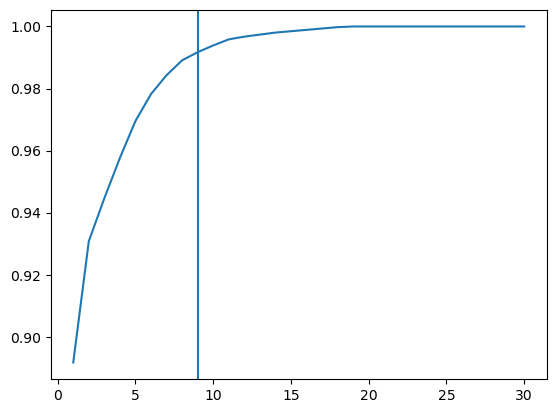

saving...
Estimating Gaussian KLD...
KLD:  743.2570053714403
train_stats:  (array([-4.3744171e-01,  7.4430689e-04,  2.5386611e-04, -4.2300805e-04,
        1.2056677e-03, -1.1084899e-03, -7.5301167e-04, -1.7610149e-04,
        8.4817538e-04], dtype=float32), array([[ 1.30069210e-03, -4.31178589e-04, -8.92568096e-05,
        -3.51026709e-04, -3.03785116e-04, -2.18366042e-05,
         1.09426815e-05, -1.17635156e-04,  1.05901727e-06],
       [-4.31178589e-04,  2.82373383e-02, -6.94144907e-06,
         1.52896020e-05, -2.93805353e-05,  3.60589628e-05,
         1.74678036e-05,  4.71711519e-06, -4.32520202e-05],
       [-8.92568096e-05, -6.94144907e-06,  9.95837436e-03,
         6.89299137e-05, -3.21315857e-05,  2.36616848e-05,
         8.27726955e-06,  2.17633749e-06, -1.45173126e-05],
       [-3.51026709e-04,  1.52896020e-05,  6.89299137e-05,
         8.90330004e-03, -1.23195323e-04,  2.33254492e-05,
         7.72833654e-06,  1.34024603e-06, -1.68330761e-05],
       [-3.03785116e-04, -2.93

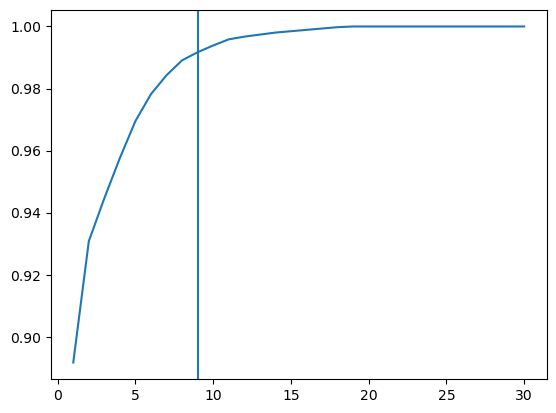

saving...
Estimating Gaussian KLD...
KLD:  743.2574512676351
train_stats:  (array([-4.3744171e-01,  7.4432243e-04,  2.5386832e-04, -4.2300145e-04,
        1.2056658e-03, -1.1084893e-03, -7.5301219e-04, -1.7610035e-04,
        8.4817718e-04], dtype=float32), array([[ 1.30069170e-03, -4.31172536e-04, -8.92588496e-05,
        -3.51029295e-04, -3.03783960e-04, -2.18352855e-05,
         1.09415208e-05, -1.17635007e-04,  1.05942284e-06],
       [-4.31172536e-04,  2.82373212e-02, -6.94187493e-06,
         1.52893829e-05, -2.93806070e-05,  3.60590384e-05,
         1.74677220e-05,  4.71711204e-06, -4.32521858e-05],
       [-8.92588496e-05, -6.94187493e-06,  9.95836454e-03,
         6.89266784e-05, -3.21302584e-05,  2.36609502e-05,
         8.27876526e-06,  2.17589811e-06, -1.45172985e-05],
       [-3.51029295e-04,  1.52893829e-05,  6.89266784e-05,
         8.90331256e-03, -1.23181766e-04,  2.33248370e-05,
         7.72754791e-06,  1.33946623e-06, -1.68337890e-05],
       [-3.03783960e-04, -2.93

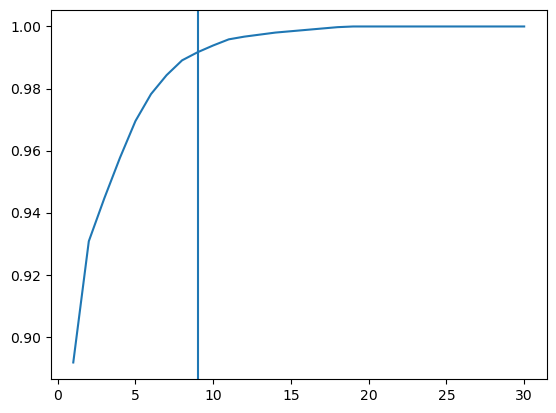

saving...
Estimating Gaussian KLD...
KLD:  743.2570317318493
train_stats:  (array([-4.3744171e-01,  7.4432505e-04,  2.5386648e-04, -4.2299955e-04,
        1.2056702e-03, -1.1084877e-03, -7.5301278e-04, -1.7609935e-04,
        8.4817235e-04], dtype=float32), array([[ 1.30069172e-03, -4.31172512e-04, -8.92585431e-05,
        -3.51031004e-04, -3.03782158e-04, -2.18348045e-05,
         1.09420445e-05, -1.17634731e-04,  1.05850980e-06],
       [-4.31172512e-04,  2.82373569e-02, -6.94227808e-06,
         1.52893263e-05, -2.93808010e-05,  3.60586398e-05,
         1.74677563e-05,  4.71707962e-06, -4.32518623e-05],
       [-8.92585431e-05, -6.94227808e-06,  9.95836811e-03,
         6.89237096e-05, -3.21307957e-05,  2.36597249e-05,
         8.27724651e-06,  2.17587645e-06, -1.45173002e-05],
       [-3.51031004e-04,  1.52893263e-05,  6.89237096e-05,
         8.90332523e-03, -1.23182400e-04,  2.33243594e-05,
         7.72823438e-06,  1.33924825e-06, -1.68333240e-05],
       [-3.03782158e-04, -2.93

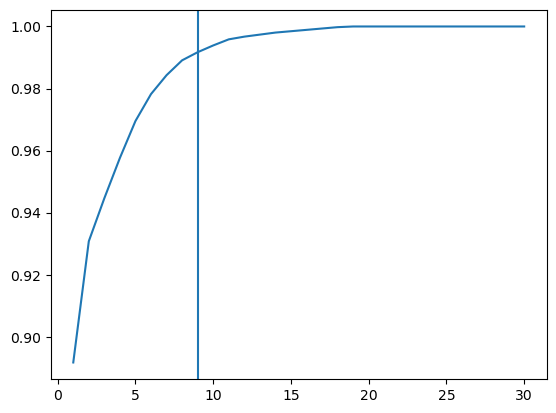

saving...
Estimating Gaussian KLD...
KLD:  743.2569823236915
train_stats:  (array([-4.3744171e-01,  7.4432069e-04,  2.5386162e-04, -4.2300817e-04,
        1.2056666e-03, -1.1084862e-03, -7.5301219e-04, -1.7609760e-04,
        8.4817444e-04], dtype=float32), array([[ 1.30069184e-03, -4.31172982e-04, -8.92602421e-05,
        -3.51027354e-04, -3.03784517e-04, -2.18349532e-05,
         1.09417063e-05, -1.17634759e-04,  1.05859851e-06],
       [-4.31172982e-04,  2.82372908e-02, -6.94135233e-06,
         1.52902284e-05, -2.93804514e-05,  3.60590513e-05,
         1.74678743e-05,  4.71701652e-06, -4.32521050e-05],
       [-8.92602421e-05, -6.94135233e-06,  9.95836372e-03,
         6.89228022e-05, -3.21305593e-05,  2.36600047e-05,
         8.27720688e-06,  2.17490438e-06, -1.45185249e-05],
       [-3.51027354e-04,  1.52902284e-05,  6.89228022e-05,
         8.90329630e-03, -1.23182808e-04,  2.33252412e-05,
         7.72758568e-06,  1.33838741e-06, -1.68343740e-05],
       [-3.03784517e-04, -2.93

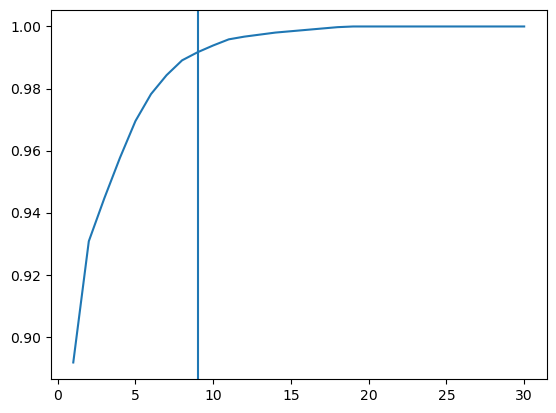

saving...
Estimating Gaussian KLD...
KLD:  743.2572577823137
train_stats:  (array([-4.3744171e-01,  7.4431638e-04,  2.5386389e-04, -4.2299152e-04,
        1.2056701e-03, -1.1084860e-03, -7.5301185e-04, -1.7610047e-04,
        8.4817741e-04], dtype=float32), array([[ 1.30069187e-03, -4.31173363e-04, -8.92560286e-05,
        -3.51030135e-04, -3.03781496e-04, -2.18354787e-05,
         1.09419755e-05, -1.17635003e-04,  1.05973047e-06],
       [-4.31173363e-04,  2.82372950e-02, -6.93983627e-06,
         1.52877487e-05, -2.93807839e-05,  3.60590481e-05,
         1.74678318e-05,  4.71710719e-06, -4.32521092e-05],
       [-8.92560286e-05, -6.93983627e-06,  9.95836760e-03,
         6.89281587e-05, -3.21321340e-05,  2.36613692e-05,
         8.27736723e-06,  2.17566252e-06, -1.45176015e-05],
       [-3.51030135e-04,  1.52877487e-05,  6.89281587e-05,
         8.90330669e-03, -1.23181209e-04,  2.33255121e-05,
         7.72811287e-06,  1.33934154e-06, -1.68339671e-05],
       [-3.03781496e-04, -2.93

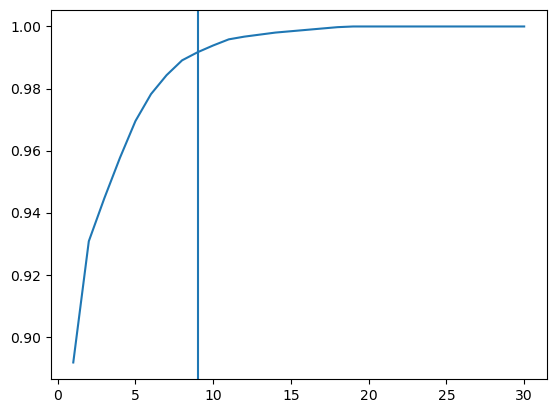

saving...
Estimating Gaussian KLD...
KLD:  743.2573459694661
train_stats:  (array([-4.3744165e-01,  7.4432307e-04,  2.5386532e-04, -4.2300372e-04,
        1.2056687e-03, -1.1084863e-03, -7.5301284e-04, -1.7610221e-04,
        8.4817421e-04], dtype=float32), array([[ 1.30069072e-03, -4.31173656e-04, -8.92574241e-05,
        -3.51029651e-04, -3.03783647e-04, -2.18351078e-05,
         1.09422854e-05, -1.17634429e-04,  1.05897270e-06],
       [-4.31173656e-04,  2.82373250e-02, -6.93960723e-06,
         1.52898951e-05, -2.93805976e-05,  3.60589183e-05,
         1.74677680e-05,  4.71714508e-06, -4.32519652e-05],
       [-8.92574241e-05, -6.93960723e-06,  9.95838629e-03,
         6.89261280e-05, -3.21311036e-05,  2.36614412e-05,
         8.27726377e-06,  2.17550752e-06, -1.45170067e-05],
       [-3.51029651e-04,  1.52898951e-05,  6.89261280e-05,
         8.90332474e-03, -1.23180476e-04,  2.33264638e-05,
         7.72778363e-06,  1.33983421e-06, -1.68336741e-05],
       [-3.03783647e-04, -2.93

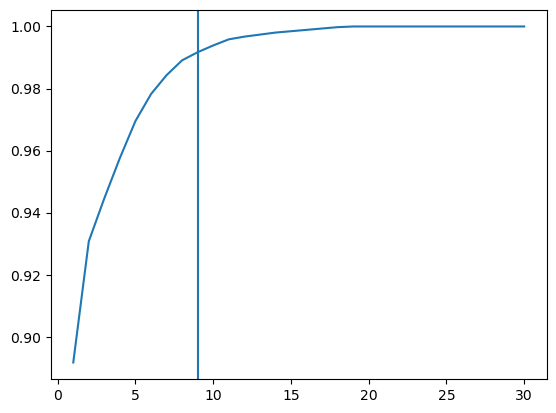

saving...
Estimating Gaussian KLD...
KLD:  743.2574577102015
train_stats:  (array([-4.3744171e-01,  7.4431981e-04,  2.5387041e-04, -4.2300488e-04,
        1.2056667e-03, -1.1084883e-03, -7.5301348e-04, -1.7610125e-04,
        8.4817846e-04], dtype=float32), array([[ 1.30069195e-03, -4.31176119e-04, -8.92567520e-05,
        -3.51028818e-04, -3.03782810e-04, -2.18353687e-05,
         1.09424641e-05, -1.17634923e-04,  1.05927377e-06],
       [-4.31176119e-04,  2.82373200e-02, -6.94174389e-06,
         1.52895482e-05, -2.93806587e-05,  3.60589130e-05,
         1.74677450e-05,  4.71704055e-06, -4.32522530e-05],
       [-8.92567520e-05, -6.94174389e-06,  9.95836407e-03,
         6.89286655e-05, -3.21274302e-05,  2.36614061e-05,
         8.27607182e-06,  2.17591358e-06, -1.45167768e-05],
       [-3.51028818e-04,  1.52895482e-05,  6.89286655e-05,
         8.90332478e-03, -1.23188407e-04,  2.33256796e-05,
         7.72798036e-06,  1.34002829e-06, -1.68337152e-05],
       [-3.03782810e-04, -2.93

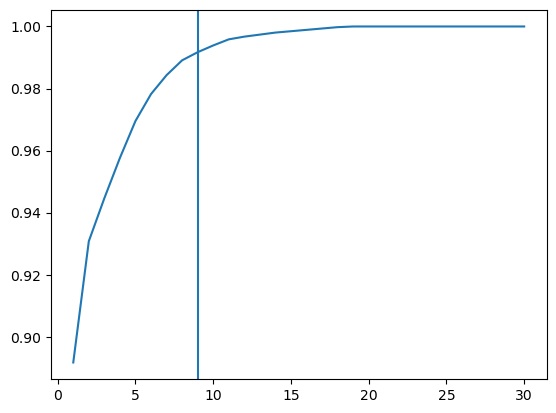

saving...
Estimating Gaussian KLD...
KLD:  743.2569868116632
train_stats:  (array([-4.3744165e-01,  7.4432301e-04,  2.5386878e-04, -4.2299187e-04,
        1.2056713e-03, -1.1084866e-03, -7.5301056e-04, -1.7610242e-04,
        8.4817386e-04], dtype=float32), array([[ 1.30069126e-03, -4.31177427e-04, -8.92584489e-05,
        -3.51031175e-04, -3.03781107e-04, -2.18358408e-05,
         1.09419246e-05, -1.17634603e-04,  1.05899132e-06],
       [-4.31177427e-04,  2.82373017e-02, -6.93968841e-06,
         1.52889718e-05, -2.93808683e-05,  3.60588548e-05,
         1.74677744e-05,  4.71711628e-06, -4.32519429e-05],
       [-8.92584489e-05, -6.93968841e-06,  9.95836266e-03,
         6.89278800e-05, -3.21318815e-05,  2.36614010e-05,
         8.27662819e-06,  2.17699021e-06, -1.45178092e-05],
       [-3.51031175e-04,  1.52889718e-05,  6.89278800e-05,
         8.90330907e-03, -1.23179015e-04,  2.33266525e-05,
         7.72634363e-06,  1.33980798e-06, -1.68330435e-05],
       [-3.03781107e-04, -2.93

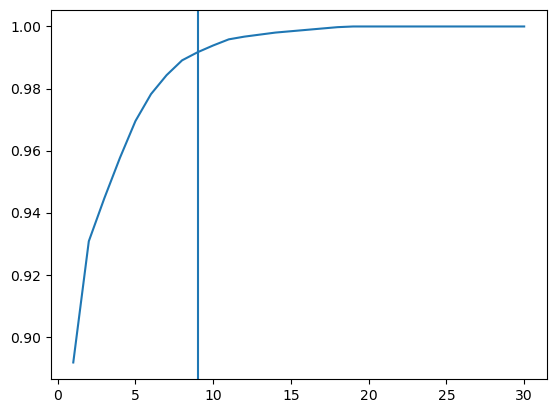

saving...
Estimating Gaussian KLD...
KLD:  743.2575837460056
train_stats:  (array([-4.3744165e-01,  7.4433000e-04,  2.5386337e-04, -4.2299391e-04,
        1.2056737e-03, -1.1084918e-03, -7.5300818e-04, -1.7610074e-04,
        8.4817520e-04], dtype=float32), array([[ 1.30069014e-03, -4.31158123e-04, -8.92587584e-05,
        -3.51031211e-04, -3.03780565e-04, -2.18353451e-05,
         1.09419030e-05, -1.17634718e-04,  1.05917853e-06],
       [-4.31158123e-04,  2.82372774e-02, -6.94162730e-06,
         1.52891264e-05, -2.93806113e-05,  3.60589215e-05,
         1.74676779e-05,  4.71712646e-06, -4.32519694e-05],
       [-8.92587584e-05, -6.94162730e-06,  9.95836729e-03,
         6.89222847e-05, -3.21315194e-05,  2.36613144e-05,
         8.27752902e-06,  2.17541296e-06, -1.45177796e-05],
       [-3.51031211e-04,  1.52891264e-05,  6.89222847e-05,
         8.90331227e-03, -1.23176905e-04,  2.33251833e-05,
         7.72744450e-06,  1.33906523e-06, -1.68330154e-05],
       [-3.03780565e-04, -2.93

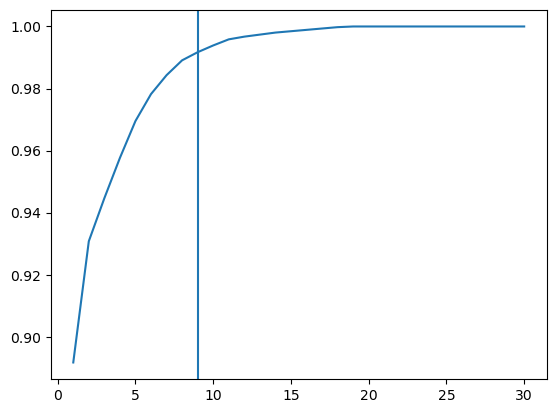

saving...
Estimating Gaussian KLD...
KLD:  743.2570391813509
train_stats:  (array([-4.3744171e-01,  7.4431696e-04,  2.5386523e-04, -4.2299216e-04,
        1.2056758e-03, -1.1084875e-03, -7.5301225e-04, -1.7610112e-04,
        8.4817572e-04], dtype=float32), array([[ 1.30069219e-03, -4.31180806e-04, -8.92574992e-05,
        -3.51032554e-04, -3.03781092e-04, -2.18350886e-05,
         1.09423395e-05, -1.17634942e-04,  1.05918328e-06],
       [-4.31180806e-04,  2.82373078e-02, -6.94149316e-06,
         1.52892854e-05, -2.93807199e-05,  3.60588219e-05,
         1.74677621e-05,  4.71710770e-06, -4.32520547e-05],
       [-8.92574992e-05, -6.94149316e-06,  9.95837753e-03,
         6.89259607e-05, -3.21287768e-05,  2.36624796e-05,
         8.27747351e-06,  2.17607103e-06, -1.45173051e-05],
       [-3.51032554e-04,  1.52892854e-05,  6.89259607e-05,
         8.90330829e-03, -1.23175394e-04,  2.33267248e-05,
         7.72740853e-06,  1.33939214e-06, -1.68337093e-05],
       [-3.03781092e-04, -2.93

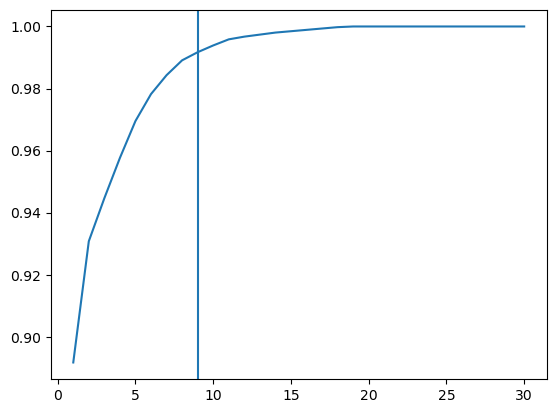

saving...
Estimating Gaussian KLD...
KLD:  743.2570998215217
train_stats:  (array([-4.3744171e-01,  7.4431853e-04,  2.5387015e-04, -4.2299202e-04,
        1.2056747e-03, -1.1084873e-03, -7.5300981e-04, -1.7610181e-04,
        8.4817433e-04], dtype=float32), array([[ 1.30069216e-03, -4.31179051e-04, -8.92501440e-05,
        -3.51034318e-04, -3.03781318e-04, -2.18354545e-05,
         1.09422022e-05, -1.17634799e-04,  1.05906048e-06],
       [-4.31179051e-04,  2.82372819e-02, -6.94310027e-06,
         1.52887165e-05, -2.93801983e-05,  3.60588413e-05,
         1.74677260e-05,  4.71711926e-06, -4.32519349e-05],
       [-8.92501440e-05, -6.94310027e-06,  9.95837841e-03,
         6.89345784e-05, -3.21268694e-05,  2.36600141e-05,
         8.27679409e-06,  2.17552114e-06, -1.45172205e-05],
       [-3.51034318e-04,  1.52887165e-05,  6.89345784e-05,
         8.90332575e-03, -1.23178531e-04,  2.33257308e-05,
         7.72764511e-06,  1.33939325e-06, -1.68334486e-05],
       [-3.03781318e-04, -2.93

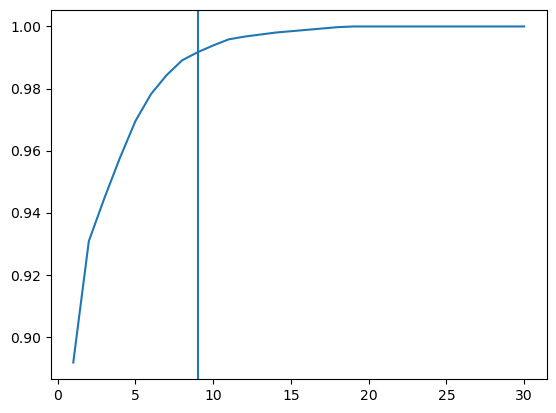

saving...
Estimating Gaussian KLD...
KLD:  743.257464108917
train_stats:  (array([-4.3744165e-01,  7.4432167e-04,  2.5386678e-04, -4.2299993e-04,
        1.2056694e-03, -1.1084909e-03, -7.5301190e-04, -1.7610136e-04,
        8.4817561e-04], dtype=float32), array([[ 1.30069093e-03, -4.31175125e-04, -8.92586183e-05,
        -3.51029952e-04, -3.03782123e-04, -2.18356916e-05,
         1.09414795e-05, -1.17634461e-04,  1.05936869e-06],
       [-4.31175125e-04,  2.82373404e-02, -6.94304657e-06,
         1.52895629e-05, -2.93806501e-05,  3.60587834e-05,
         1.74676246e-05,  4.71714733e-06, -4.32520765e-05],
       [-8.92586183e-05, -6.94304657e-06,  9.95836161e-03,
         6.89303072e-05, -3.21288698e-05,  2.36598974e-05,
         8.27665236e-06,  2.17629704e-06, -1.45172917e-05],
       [-3.51029952e-04,  1.52895629e-05,  6.89303072e-05,
         8.90331985e-03, -1.23183297e-04,  2.33252721e-05,
         7.72772729e-06,  1.33934403e-06, -1.68337416e-05],
       [-3.03782123e-04, -2.938

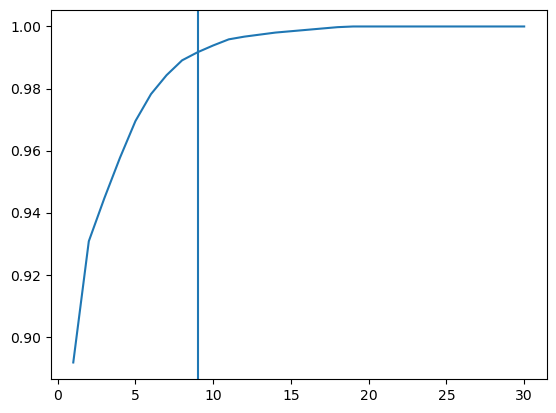

saving...
Estimating Gaussian KLD...
KLD:  743.2571023474816
train_stats:  (array([-4.3744171e-01,  7.4432034e-04,  2.5386614e-04, -4.2300255e-04,
        1.2056680e-03, -1.1084850e-03, -7.5301027e-04, -1.7610021e-04,
        8.4817479e-04], dtype=float32), array([[ 1.30069169e-03, -4.31172295e-04, -8.92585951e-05,
        -3.51028427e-04, -3.03783354e-04, -2.18357060e-05,
         1.09411534e-05, -1.17634729e-04,  1.05898884e-06],
       [-4.31172295e-04,  2.82373135e-02, -6.94166689e-06,
         1.52892695e-05, -2.93804259e-05,  3.60586865e-05,
         1.74676439e-05,  4.71706606e-06, -4.32519913e-05],
       [-8.92585951e-05, -6.94166689e-06,  9.95836864e-03,
         6.89273261e-05, -3.21288255e-05,  2.36606005e-05,
         8.27817878e-06,  2.17590726e-06, -1.45176864e-05],
       [-3.51028427e-04,  1.52892695e-05,  6.89273261e-05,
         8.90330576e-03, -1.23184971e-04,  2.33255572e-05,
         7.72803390e-06,  1.33863095e-06, -1.68334767e-05],
       [-3.03783354e-04, -2.93

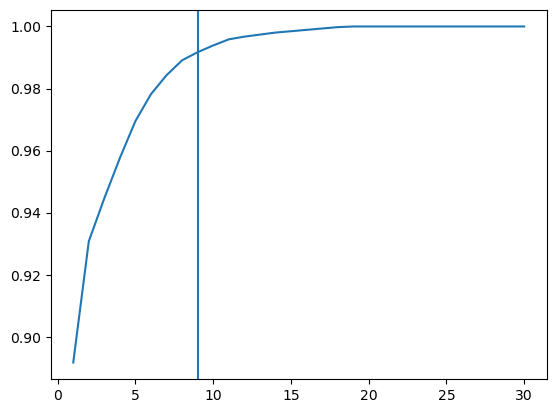

saving...
Estimating Gaussian KLD...
KLD:  743.2570226606936
train_stats:  (array([-4.3744165e-01,  7.4432779e-04,  2.5386779e-04, -4.2300191e-04,
        1.2056655e-03, -1.1084890e-03, -7.5301382e-04, -1.7610090e-04,
        8.4817421e-04], dtype=float32), array([[ 1.30069101e-03, -4.31154770e-04, -8.92551124e-05,
        -3.51030153e-04, -3.03782928e-04, -2.18354297e-05,
         1.09420146e-05, -1.17635077e-04,  1.05877044e-06],
       [-4.31154770e-04,  2.82372758e-02, -6.94186515e-06,
         1.52893777e-05, -2.93805391e-05,  3.60588636e-05,
         1.74678591e-05,  4.71709534e-06, -4.32518891e-05],
       [-8.92551124e-05, -6.94186515e-06,  9.95836940e-03,
         6.89300838e-05, -3.21275894e-05,  2.36611076e-05,
         8.27697152e-06,  2.17601288e-06, -1.45178541e-05],
       [-3.51030153e-04,  1.52893777e-05,  6.89300838e-05,
         8.90331342e-03, -1.23182199e-04,  2.33258517e-05,
         7.72795671e-06,  1.33893827e-06, -1.68327621e-05],
       [-3.03782928e-04, -2.93

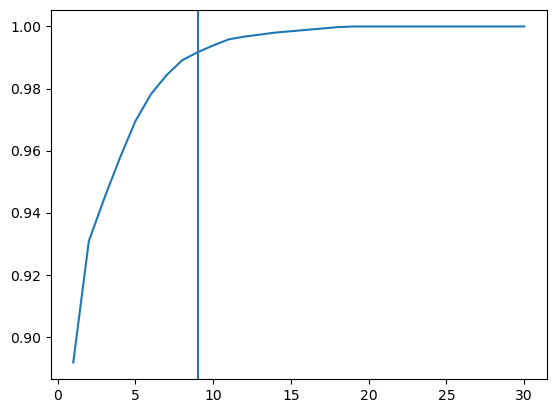

saving...
Estimating Gaussian KLD...
KLD:  743.2568163463418
train_stats:  (array([-4.3744171e-01,  7.4431772e-04,  2.5386506e-04, -4.2299693e-04,
        1.2056733e-03, -1.1084866e-03, -7.5301318e-04, -1.7610063e-04,
        8.4817660e-04], dtype=float32), array([[ 1.30069213e-03, -4.31172252e-04, -8.92555836e-05,
        -3.51031260e-04, -3.03781404e-04, -2.18357912e-05,
         1.09418689e-05, -1.17634969e-04,  1.05915757e-06],
       [-4.31172252e-04,  2.82373036e-02, -6.93924104e-06,
         1.52893107e-05, -2.93797056e-05,  3.60585248e-05,
         1.74678598e-05,  4.71708824e-06, -4.32520367e-05],
       [-8.92555836e-05, -6.93924104e-06,  9.95836644e-03,
         6.89277274e-05, -3.21296602e-05,  2.36610902e-05,
         8.27740789e-06,  2.17561074e-06, -1.45172810e-05],
       [-3.51031260e-04,  1.52893107e-05,  6.89277274e-05,
         8.90332094e-03, -1.23180328e-04,  2.33265237e-05,
         7.72701600e-06,  1.33995062e-06, -1.68338640e-05],
       [-3.03781404e-04, -2.93

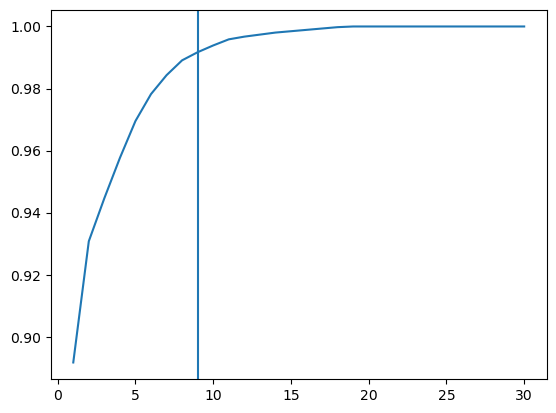

saving...
Estimating Gaussian KLD...
KLD:  743.2571589743624
train_stats:  (array([-4.3744171e-01,  7.4430776e-04,  2.5386771e-04, -4.2299044e-04,
        1.2056720e-03, -1.1084895e-03, -7.5301388e-04, -1.7610090e-04,
        8.4817572e-04], dtype=float32), array([[ 1.30069240e-03, -4.31181361e-04, -8.92552973e-05,
        -3.51033418e-04, -3.03780031e-04, -2.18348642e-05,
         1.09420034e-05, -1.17635611e-04,  1.05927401e-06],
       [-4.31181361e-04,  2.82373636e-02, -6.94199040e-06,
         1.52891959e-05, -2.93805020e-05,  3.60588586e-05,
         1.74678740e-05,  4.71709843e-06, -4.32519953e-05],
       [-8.92552973e-05, -6.94199040e-06,  9.95838693e-03,
         6.89286034e-05, -3.21268285e-05,  2.36624202e-05,
         8.27795107e-06,  2.17554851e-06, -1.45170704e-05],
       [-3.51033418e-04,  1.52891959e-05,  6.89286034e-05,
         8.90332598e-03, -1.23179968e-04,  2.33276958e-05,
         7.72804938e-06,  1.33949253e-06, -1.68333184e-05],
       [-3.03780031e-04, -2.93

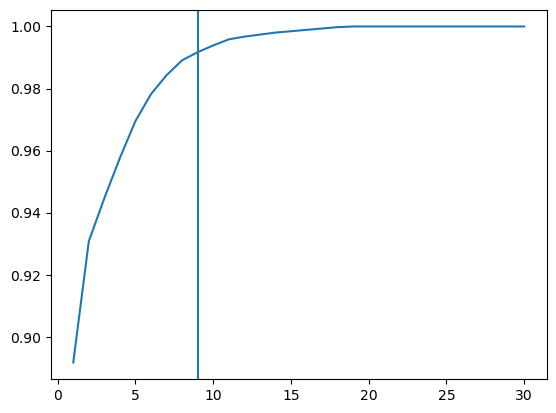

saving...
Estimating Gaussian KLD...
KLD:  743.2571935790716
train_stats:  (array([-4.3744171e-01,  7.4432208e-04,  2.5386523e-04, -4.2299452e-04,
        1.2056701e-03, -1.1084860e-03, -7.5301249e-04, -1.7610159e-04,
        8.4817584e-04], dtype=float32), array([[ 1.30069163e-03, -4.31174118e-04, -8.92574782e-05,
        -3.51031104e-04, -3.03781960e-04, -2.18357168e-05,
         1.09417756e-05, -1.17635010e-04,  1.05897127e-06],
       [-4.31174118e-04,  2.82373392e-02, -6.94180784e-06,
         1.52891346e-05, -2.93806025e-05,  3.60588435e-05,
         1.74677967e-05,  4.71714825e-06, -4.32520573e-05],
       [-8.92574782e-05, -6.94180784e-06,  9.95836788e-03,
         6.89280257e-05, -3.21284314e-05,  2.36621127e-05,
         8.27741169e-06,  2.17616688e-06, -1.45175778e-05],
       [-3.51031104e-04,  1.52891346e-05,  6.89280257e-05,
         8.90331031e-03, -1.23176734e-04,  2.33246267e-05,
         7.72773057e-06,  1.33901961e-06, -1.68339589e-05],
       [-3.03781960e-04, -2.93

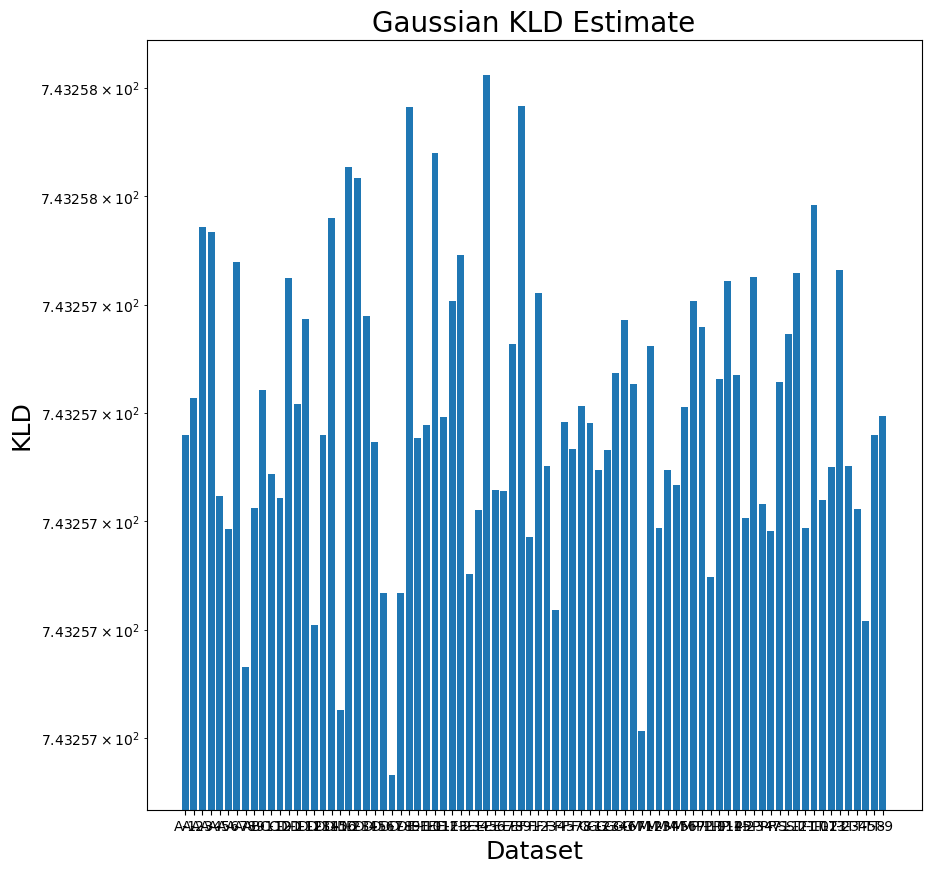

In [16]:
MSL_list = [file[:-4] for file in os.listdir(os.path.join("data", "MSL", "train"))]
kld = []
for data in MSL_list:
    train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
    e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, data, False)
    kld.append(e)

# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(MSL_list, kld)
plt.title('Gaussian KLD Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=18)
plt.show()   

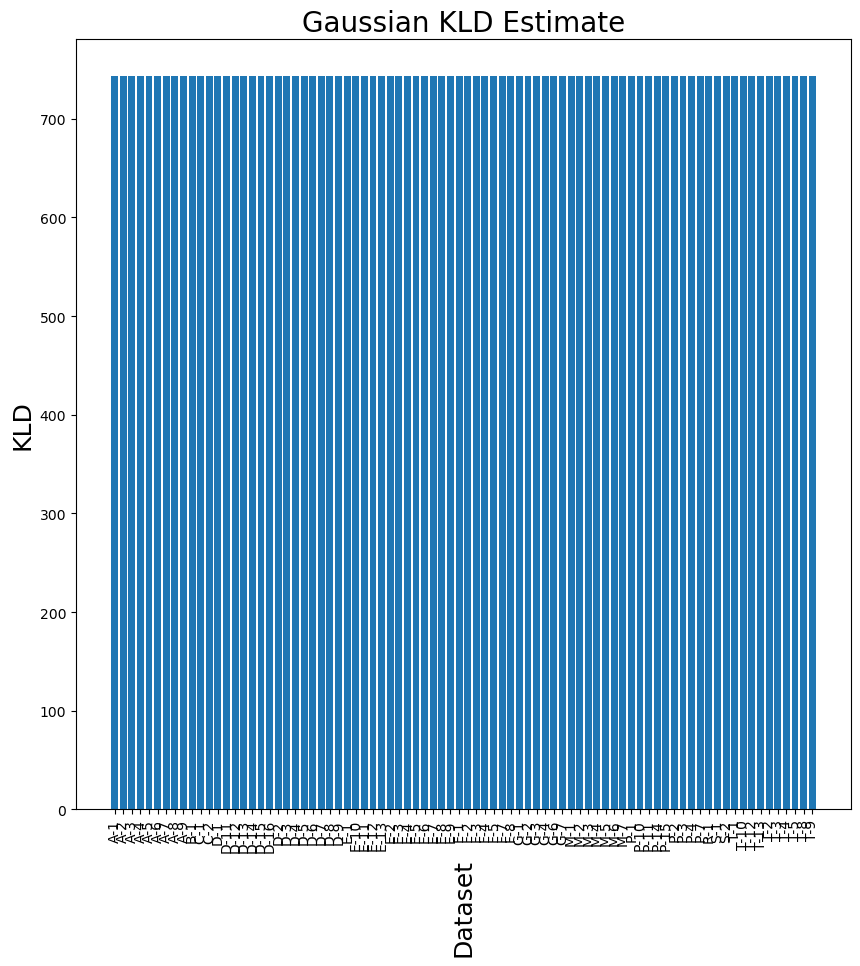

In [21]:
# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(MSL_list, kld)
plt.title('Gaussian KLD Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18, rotation=90)
plt.xticks(rotation="vertical")
#plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=18)
plt.show()   

In [ ]:
MSL_list.sort(key=lambda )

In [55]:
datasets_label = ["SWaT", "WADI", "PSM", "CreditCard", "MSL\n(P-15)", "SMD\n(1-4)", "Yahoo\n(Data-20)", "Pump"]
datasets = ["SWaT", "WADI", "PSM", "CreditCard", "MSL_P-15", "SMD_machine-1-4", "yahoo_20", "Pump"]

KLD for MSL_P-15
finding PCA...
(3682, 55) (3682,) (2856, 55) (2856,)
(3682, 55) (3682,) (2836, 55) (2856,)
(6518, 55)
Done!


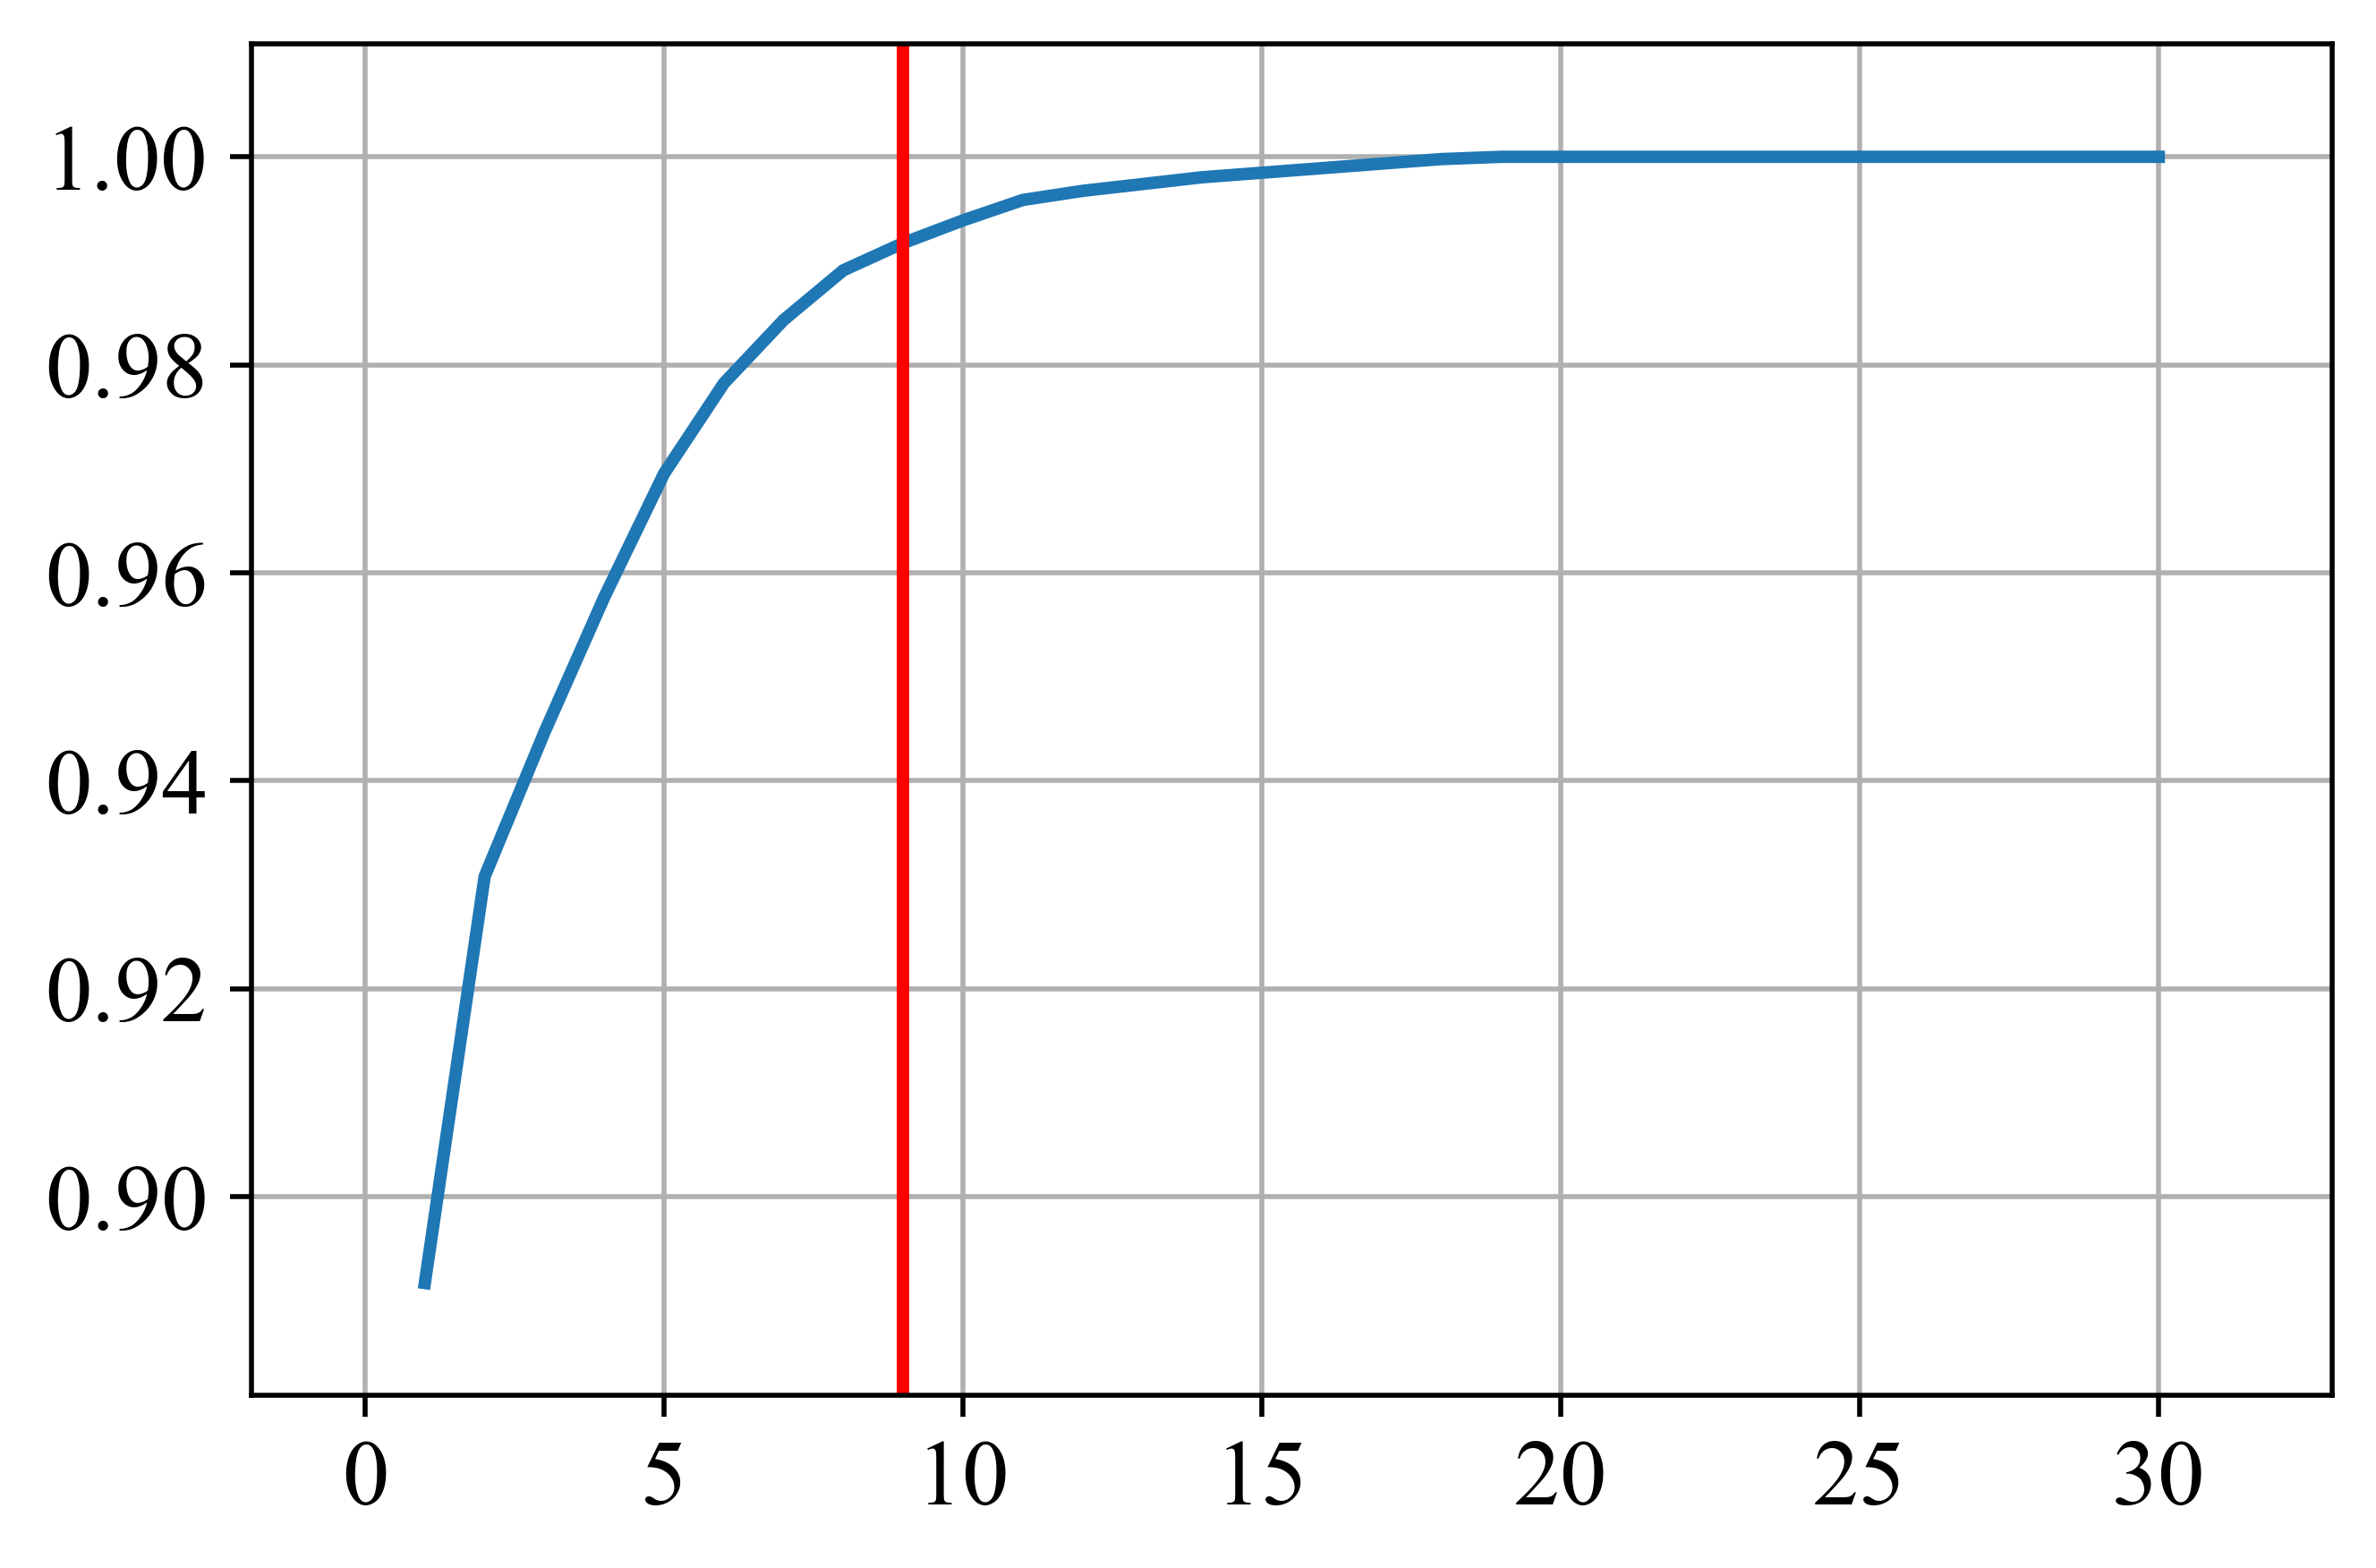

saving...
Estimating Gaussian KLD...
KLD:  743.257307142401
train_stats:  (array([-4.3744165e-01,  7.4433000e-04,  2.5386352e-04, -4.2300168e-04,
        1.2056667e-03, -1.1084882e-03, -7.5301010e-04, -1.7610076e-04,
        8.4817543e-04], dtype=float32), array([[ 1.30069127e-03, -4.31164565e-04, -8.92586545e-05,
        -3.51031234e-04, -3.03782771e-04, -2.18353075e-05,
         1.09421577e-05, -1.17634325e-04,  1.05897046e-06],
       [-4.31164565e-04,  2.82373113e-02, -6.94166885e-06,
         1.52896629e-05, -2.93804729e-05,  3.60588945e-05,
         1.74677533e-05,  4.71707156e-06, -4.32521504e-05],
       [-8.92586545e-05, -6.94166885e-06,  9.95836409e-03,
         6.89273275e-05, -3.21317585e-05,  2.36620394e-05,
         8.27725729e-06,  2.17596169e-06, -1.45170798e-05],
       [-3.51031234e-04,  1.52896629e-05,  6.89273275e-05,
         8.90331162e-03, -1.23183079e-04,  2.33256989e-05,
         7.72779365e-06,  1.33941963e-06, -1.68340432e-05],
       [-3.03782771e-04, -2.938

In [58]:
# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[4], False)

KLD for SWaT
Estimating Gaussian KLD...
KLD:  143.91222208812337
train_stats:  (array([ -1.6705731,   5.2914505,   7.6528034,  24.086998 , -17.860296 ,
         3.4094663], dtype=float32), array([[14969.14370043,  -983.66328347,   281.46421761,   -32.0104241 ,
           51.99849803,    67.15677732],
       [ -983.66328347, 18588.12709894,  -690.95972503,   518.08851302,
          426.54607852,   563.25074743],
       [  281.46421761,  -690.95972503,  2834.33070887,  1006.80290905,
          637.85931237,   110.76374396],
       [  -32.0104241 ,   518.08851302,  1006.80290905,  3749.17332058,
         1331.5161391 ,  -206.2802673 ],
       [   51.99849803,   426.54607852,   637.85931237,  1331.5161391 ,
          560.95310297,    80.69730099],
       [   67.15677732,   563.25074743,   110.76374396,  -206.2802673 ,
           80.69730099,   520.23971867]]))
test_stats:  (array([  2.7904286,  -6.267043 , -10.202734 , -29.617435 ,  22.932138 ,
         0.5329458], dtype=float32), array([[

KLD for CreditCard
Estimating Gaussian KLD...
KLD:  0.0010342001914978027
train_stats:  (array([2.3955376], dtype=float32), array([[60743.574]], dtype=float32))
test_stats:  (array([-2.3459609], dtype=float32), array([[64353.152]], dtype=float32))
done
KLD for MSL_P-15
Estimating Gaussian KLD...
KLD:  743.2572453162252
train_stats:  (array([-4.3744171e-01,  7.4432162e-04,  2.5386436e-04, -4.2299682e-04,
        1.2056696e-03, -1.1084866e-03, -7.5301330e-04, -1.7610066e-04,
        8.4817637e-04], dtype=float32), array([[ 1.30069183e-03, -4.31173024e-04, -8.92581984e-05,
        -3.51030100e-04, -3.03781871e-04, -2.18355052e-05,
         1.09416823e-05, -1.17634924e-04,  1.05882338e-06],
       [-4.31173024e-04,  2.82372872e-02, -6.94085833e-06,
         1.52892741e-05, -2.93797205e-05,  3.60589522e-05,
         1.74677714e-05,  4.71707085e-06, -4.32520197e-05],
       [-8.92581984e-05, -6.94085833e-06,  9.95837196e-03,
         6.89280741e-05, -3.21341253e-05,  2.36621451e-05,
        

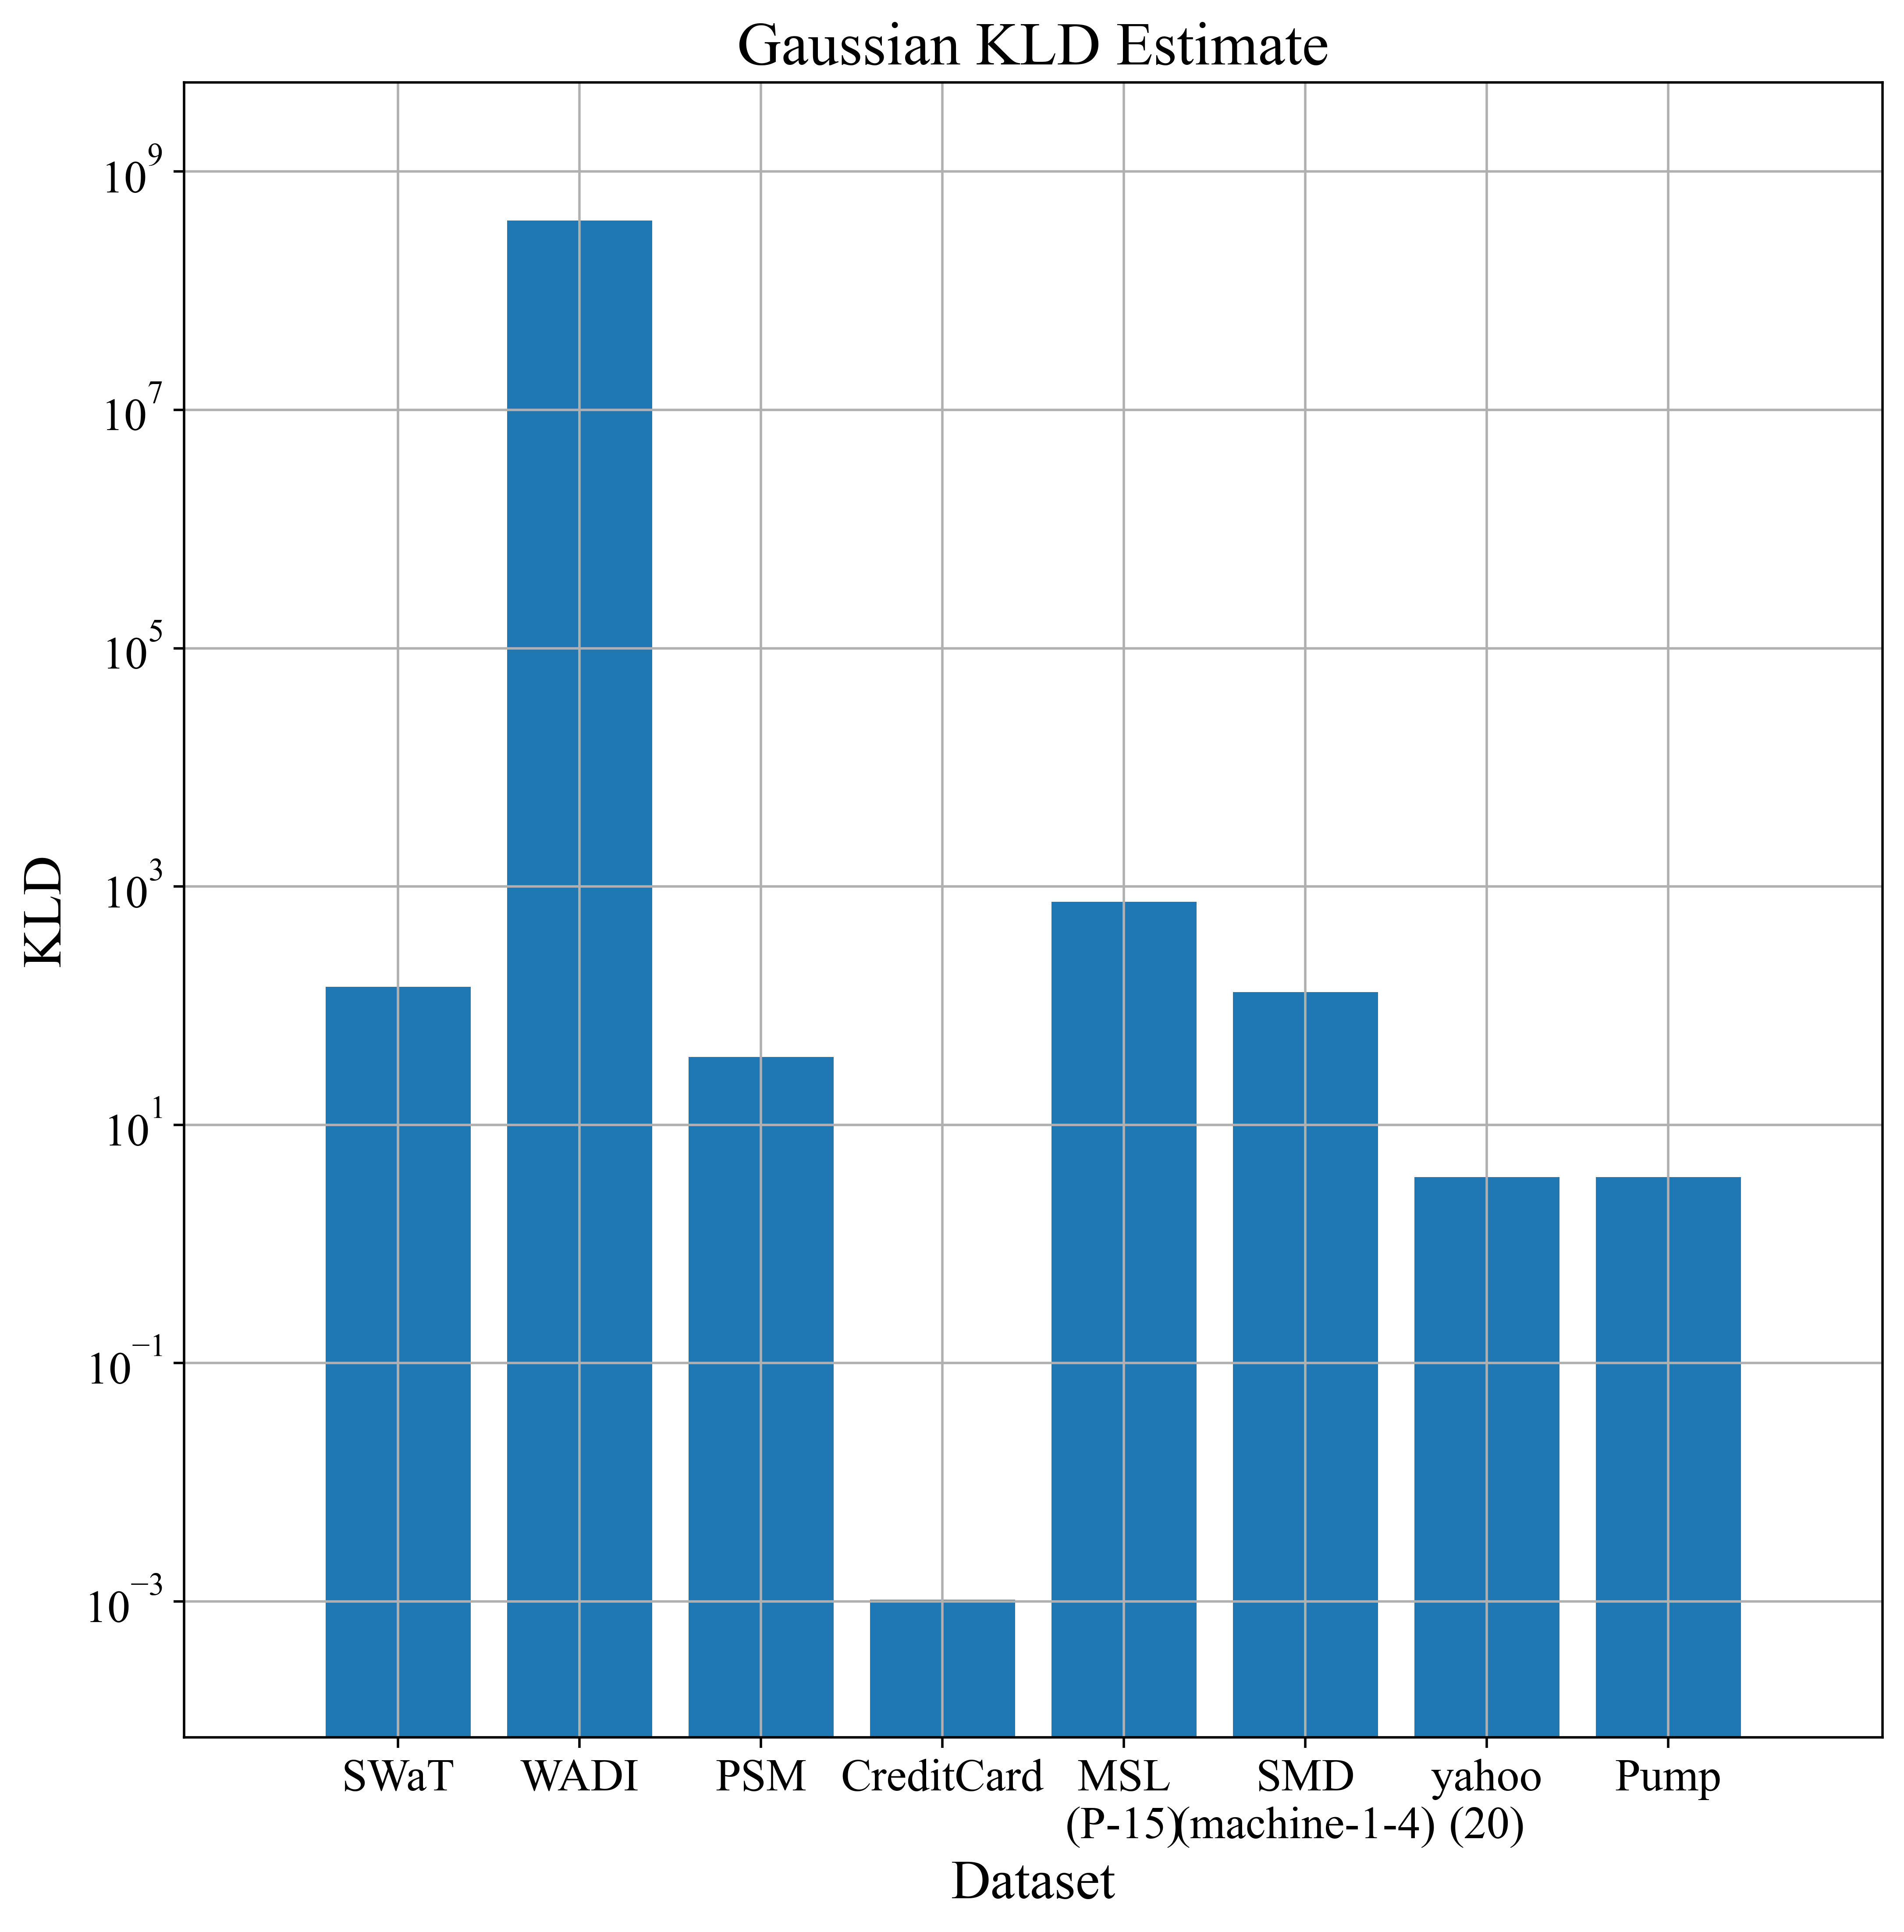

In [52]:
entropies = []

# SWaT
train_X, train_y, test_X, test_y = DataFactory.load_SWaT()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[0])
entropies.append(e)

# WADI
train_X, train_y, test_X, test_y = DataFactory.load_WADI()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[1])
entropies.append(e)

# PSM
train_X, train_y, test_X, test_y = DataFactory.load_PSM()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[2])
entropies.append(e)

# CreditCard
train_X, train_y, test_X, test_y = DataFactory.load_CreditCard()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[3])
entropies.append(e)

# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[4])
entropies.append(e)

# SMD_machine-1-4
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-1-4")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[5])
entropies.append(e)

# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("20")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[6])
entropies.append(e)

# Pump
train_X, train_y, test_X, test_y = DataFactory.load_Pump()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[7])
entropies.append(e)



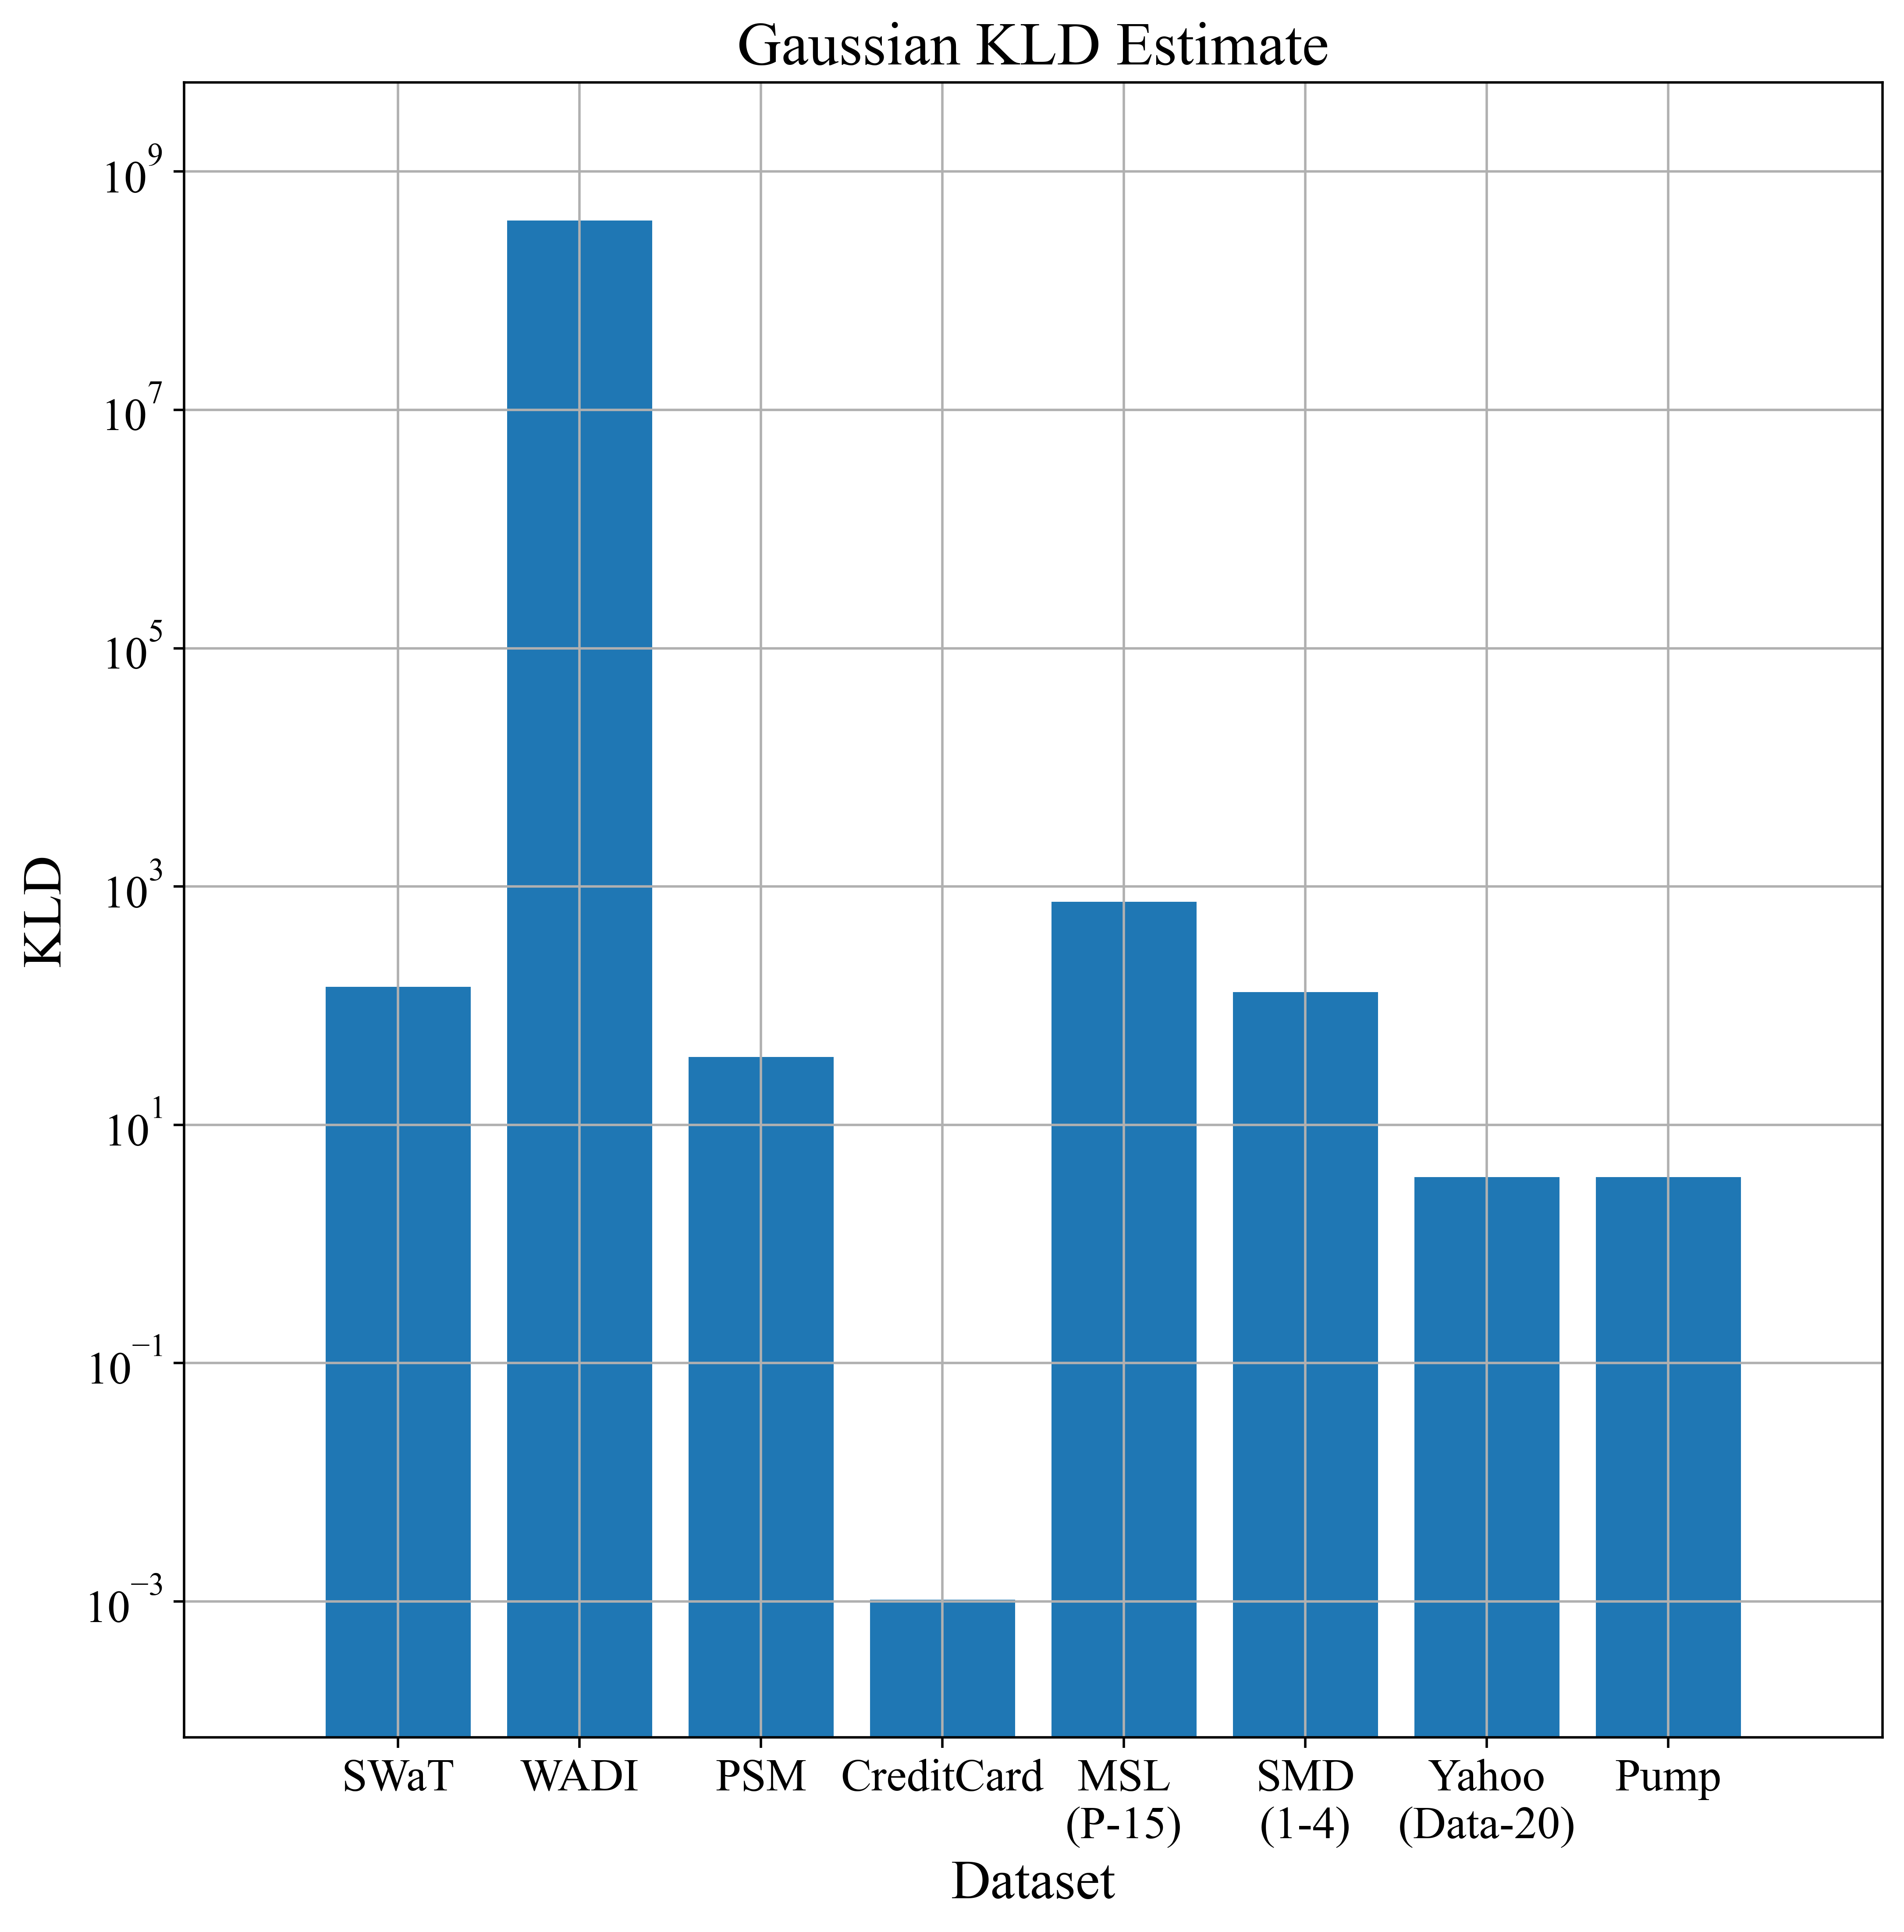

In [56]:
# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(datasets_label, entropies)
plt.title('Gaussian KLD Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=18)
plt.show()

In [62]:
with open(os.path.join("figures", "PCA", "KLD.npy"), "wb") as f:
    np.save(f, entropies)

In [63]:
kld = np.load(os.path.join("figures", "PCA", "KLD.npy"))

In [64]:
kld

array([1.43912222e+02, 3.88179916e+08, 3.70687401e+01, 1.03420019e-03,
       7.43257245e+02, 1.30357132e+02, 3.62813282e+00, 3.62813282e+00])

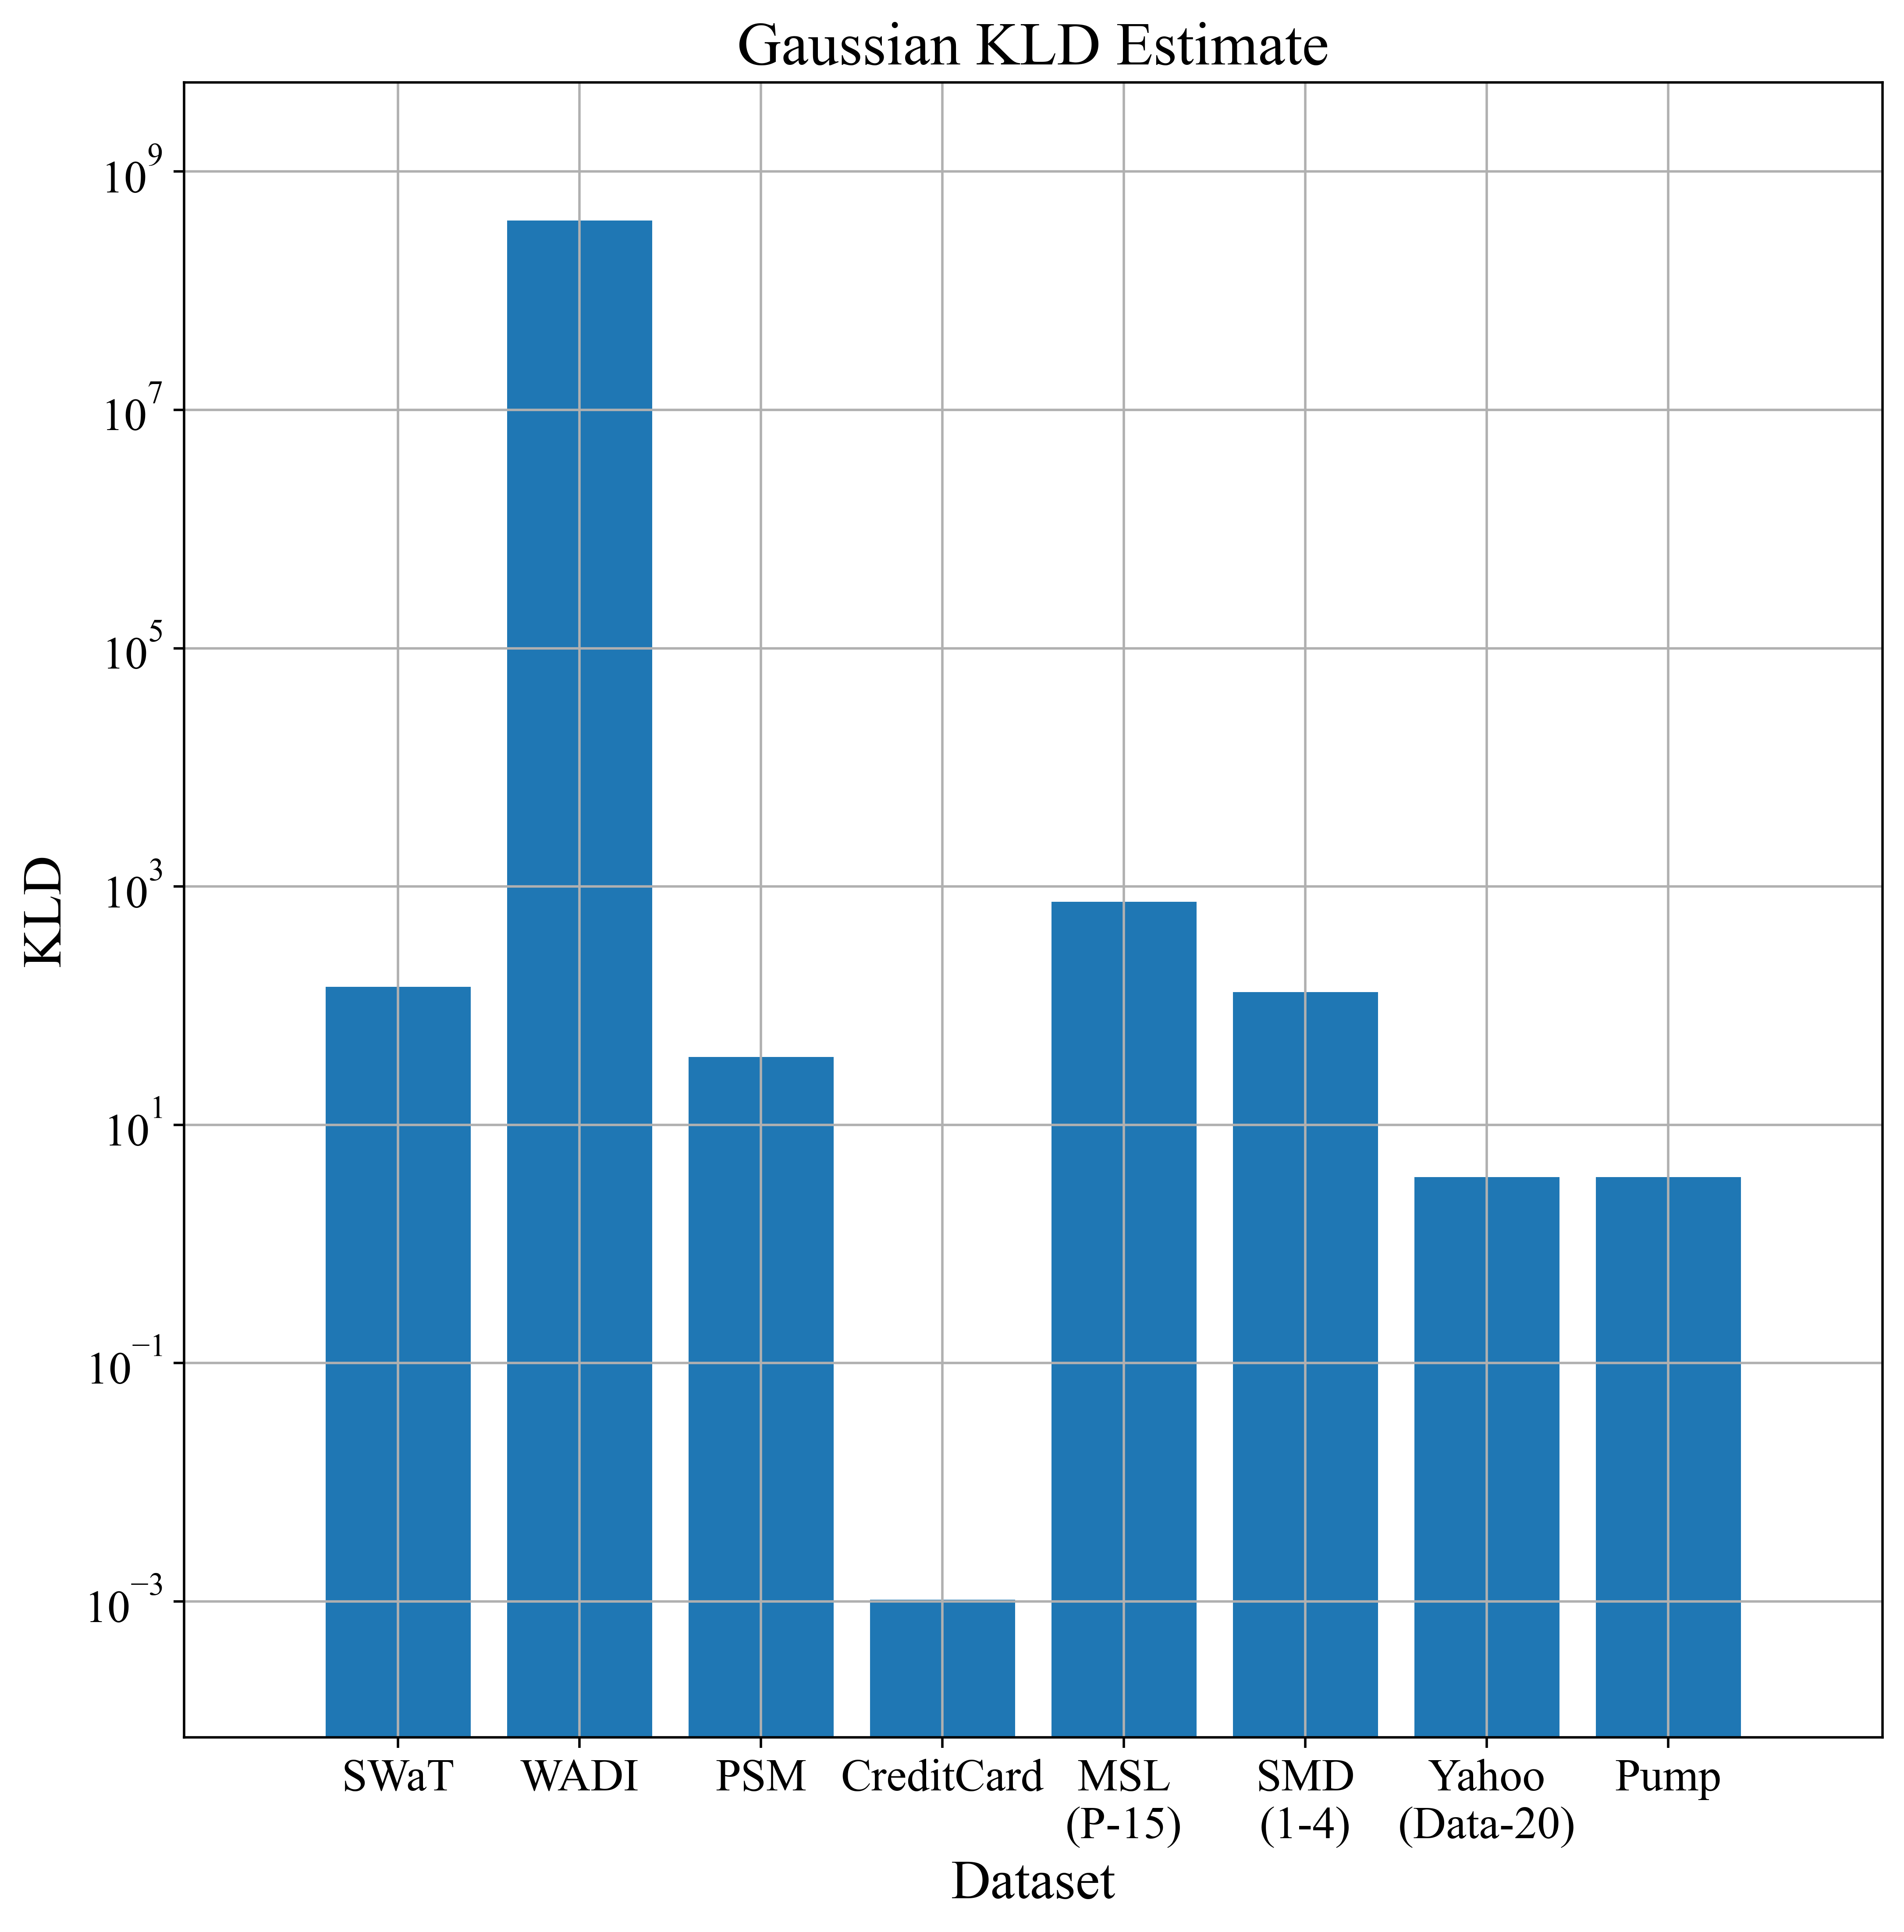

In [66]:
# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(datasets_label, kld)
plt.title('Gaussian KLD Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=18)
plt.show()

In [80]:
off = np.array([0.7627829568, 0.1301139533, 0.5359979503, 0.1486068111, 0.358974359, 0.1, 0.06342913776, 0.1])
on = np.array([0.7903205183, 0.1422824922, 0.5375672963, 0.1009753299, 0.6153846154, 0.3, 0.6571428571428571, 0.3])

In [81]:
len(kld)

8

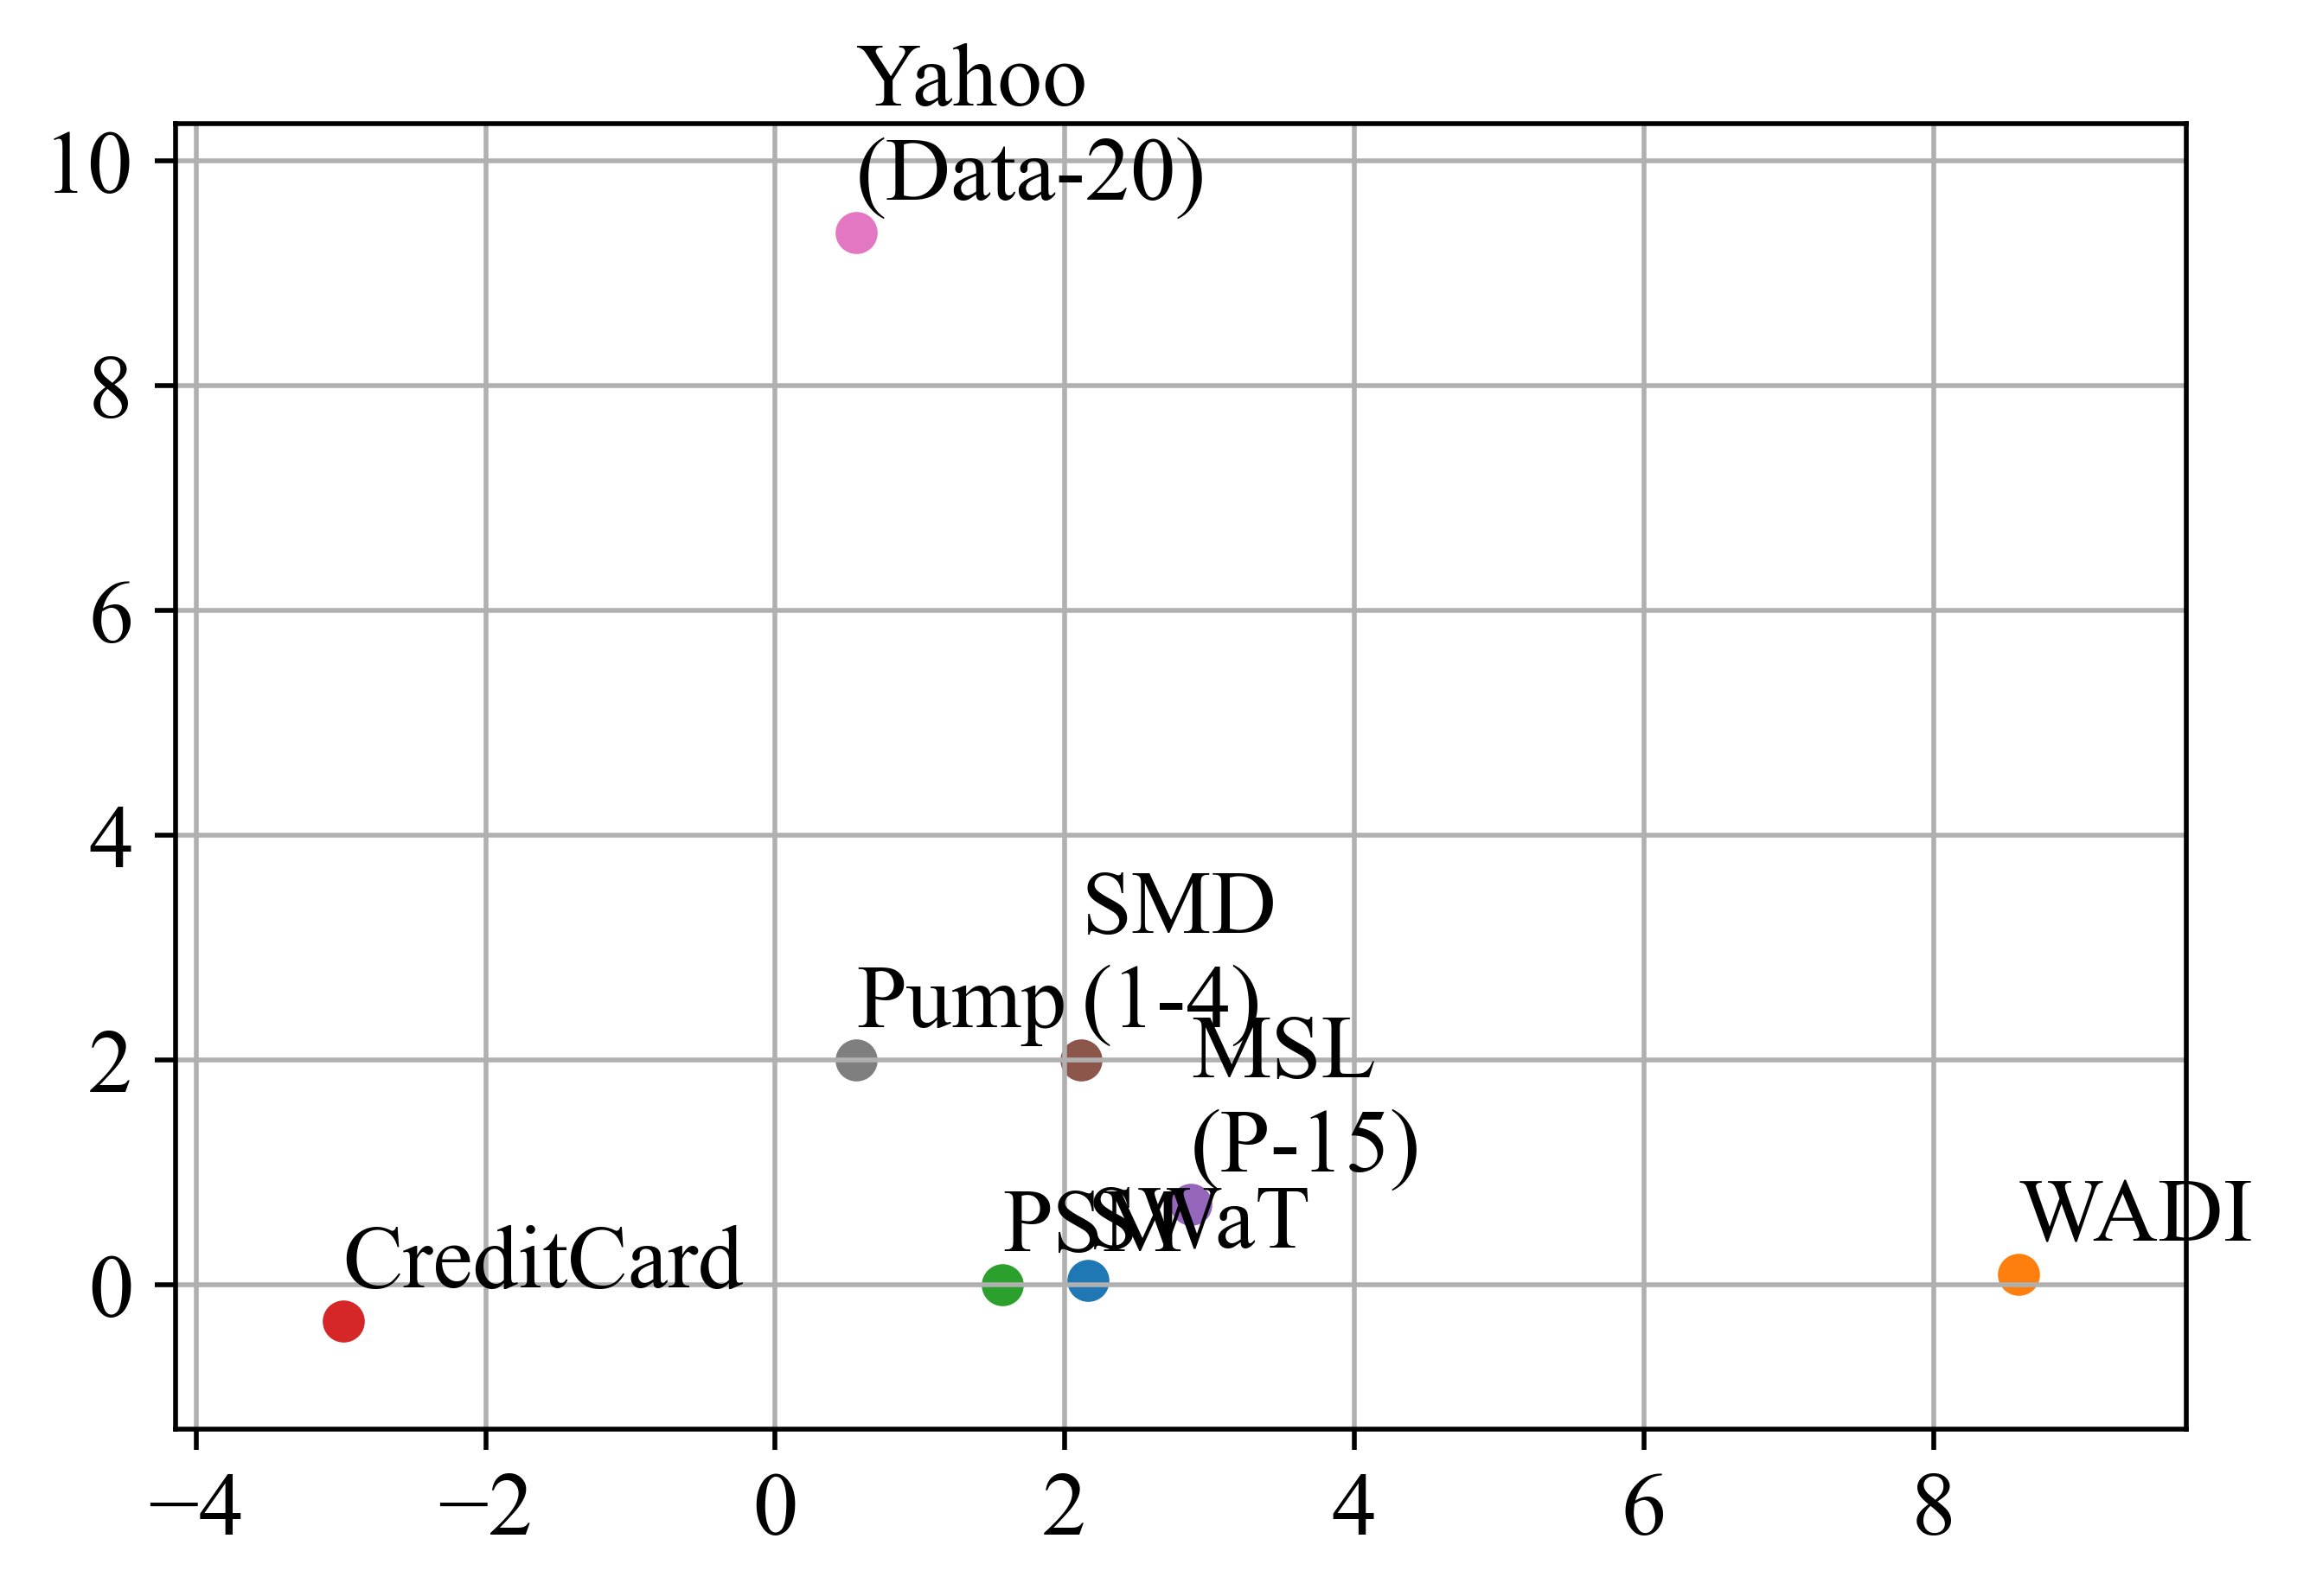

In [82]:
for x, y, data in zip(np.log10(kld), (on-off)/off, datasets_label):
    plt.scatter(x, y)
    plt.text(x, y+0.3, data)